In [ ]:
## 1. 전처리 및 모델 부분

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# 데이터 로드
df = pd.read_csv('./encoded_data.csv')

# change_date 열을 제외한 나머지 열 선택
X = df.drop(columns=['change_date'])
y = df['change_date'].values  # 예측값

# 결측값 처리 (예: 평균값으로 대체)
X.replace('-', np.nan, inplace=True)
X = X.astype(np.float32)
X.fillna(X.mean(), inplace=True)

y = y.astype(np.float32)

# NaN 값이 있는지 확인 
if np.any(np.isnan(X)) or np.any(np.isnan(y)):
    print("결측값이 존재합니다.")
else:
    print("결측값이 없습니다.")

# train/test 데이터셋 나누기 (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# train 데이터셋의 일부를 다시 train(sub)/val 데이터셋으로 나누기 (80% sub(train), 20% val)
X_sub, X_val, y_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

# 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_sub = scaler.transform(X_sub)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Functional API를 사용하여 모델 생성
inputs = tf.keras.Input(shape=(X.shape[1],))
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)  # 릿지 규제 적용
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01))(x)  # 라쏘 규제 적용
#x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01))(x)  # L1과 L2 규제 함께 적용
x = tf.keras.layers.Dense(16, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='linear')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# 회귀를 위한 손실 함수(mean squared error)와 메트릭스(mean absolute error) 사용하여 모델 컴파일
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error'])

model.summary()

결측값이 없습니다.


C:\Users\user\AppData\Local\Temp\ipykernel_29052\3099151436.py:10: DtypeWarning: Columns (4,5,6,7,8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./encoded_data.csv')


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 291)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          37,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,257 (188.50 KB)

 Trainable params: 48,257 (188.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
## 2. 모델학습 부터

In [ ]:
# 조기 종료 콜백 추가 (과적합 방지)
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2000, batch_size=2000)#(, callbacks=[early_stopping])

# 학습 결과 시각화 (학습 곡선 시각화)
plt.figure(figsize=(10, 5))

# subplot 1: Mean Squared Error 손실 함수의 변화
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# subplot 2: Mean Absolute Error 매트릭스의 변화
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Val MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()

plt.show()

# 모델 평가 - 테스트 데이터셋 사용
loss_test, mae_test = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss_test}')
print(f'Test MAE: {mae_test}')

# 모델 평가 - 검증 데이터셋 사용
loss_val, mae_val = model.evaluate(X_val, y_val)
print(f'Validation Loss: {loss_val}')
print(f'Validation MAE: {mae_val}')

# 예측값 생성
predictions = model.predict(X_val)

# NaN 값이 있는지 확인 및 처리 #@!
if np.any(np.isnan(predictions)):
    print("예측값에 NaN이 존재합니다. NaN 값을 0으로 대체합니다.")
    predictions = np.nan_to_num(predictions)

# 결정계수 계산
r2 = r2_score(y_val, predictions)
print(f'R2 Score: {r2}')

# 마지막에 결과창에 에러나는부분은 나눠서 밑의 셀 부분에 있습니다.

Epoch 1/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2925 - mean_absolute_error: 0.1956 - val_loss: 0.2479 - val_mean_absolute_error: 0.1361
Epoch 2/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2982 - mean_absolute_error: 0.2062 - val_loss: 0.2674 - val_mean_absolute_error: 0.1803
Epoch 3/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2935 - mean_absolute_error: 0.2142 - val_loss: 0.2915 - val_mean_absolute_error: 0.2167
Epoch 4/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3302 - mean_absolute_error: 0.2580 - val_loss: 0.2581 - val_mean_absolute_error: 0.1432
Epoch 5/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2908 - mean_absolute_error: 0.2028 - val_loss: 0.2589 - val_mean_absolute_error: 0.1396
Epoch 6/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2833 - mean_absolute_error: 0.1909 - val_loss: 0.2849 - val_mean_absolute_error: 0.1887
Epoch 7/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3192 - mean_absolute_error: 0.2381 - val_loss

Test Loss: 0.6521784663200378


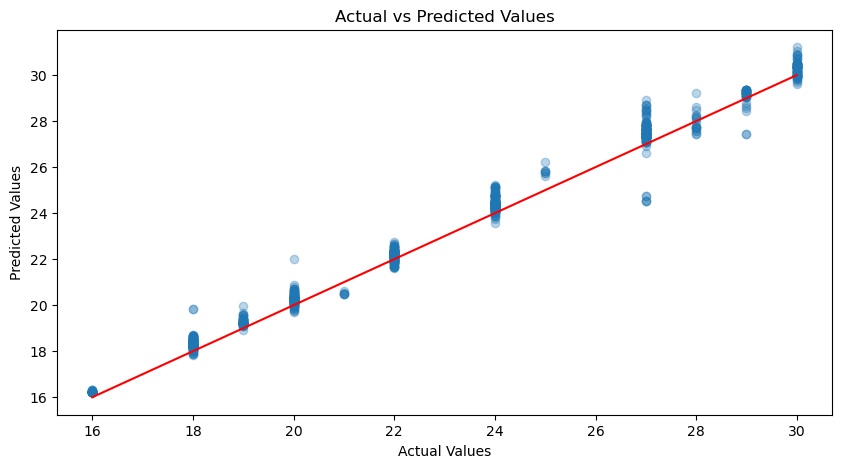

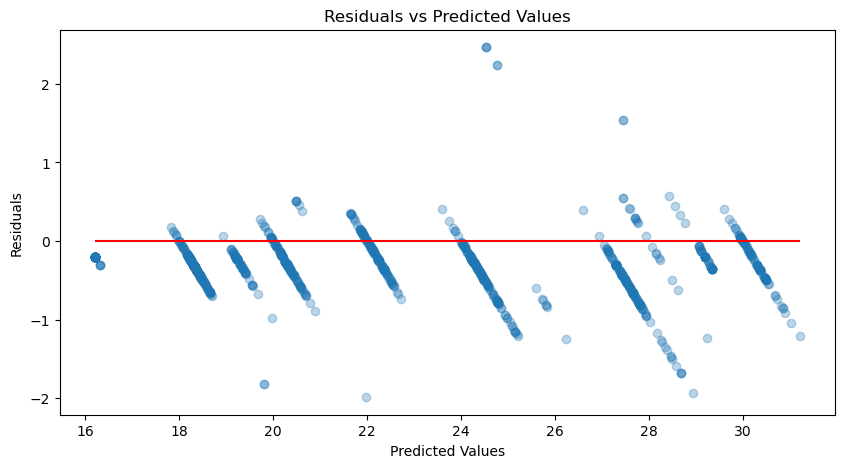

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
171/171 ━━━

PermutationExplainer explainer:   3%|█▉                                                      | 35/1036 [00:00<?, ?it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step


PermutationExplainer explainer:   4%|█▋                                              | 37/1036 [00:10<01:55,  8.63it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


PermutationExplainer explainer:   4%|█▊                                              | 38/1036 [00:10<02:44,  6.06it/s]

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step


PermutationExplainer explainer:   4%|█▊                                              | 39/1036 [00:10<03:14,  5.14it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step


PermutationExplainer explainer:   4%|█▊                                              | 40/1036 [00:11<03:38,  4.56it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step


PermutationExplainer explainer:   4%|█▉                                              | 41/1036 [00:11<03:35,  4.61it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step


PermutationExplainer explainer:   4%|█▉                                              | 42/1036 [00:11<03:44,  4.42it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step


PermutationExplainer explainer:   4%|█▉                                              | 43/1036 [00:11<03:56,  4.20it/s]

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step


PermutationExplainer explainer:   4%|██                                              | 44/1036 [00:11<03:51,  4.29it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:   4%|██                                              | 45/1036 [00:12<03:51,  4.28it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step


PermutationExplainer explainer:   4%|██▏                                             | 46/1036 [00:12<03:56,  4.19it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step


PermutationExplainer explainer:   5%|██▏                                             | 47/1036 [00:12<03:45,  4.38it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step


PermutationExplainer explainer:   5%|██▏                                             | 48/1036 [00:12<03:51,  4.26it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step


PermutationExplainer explainer:   5%|██▎                                             | 49/1036 [00:13<03:44,  4.40it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step


PermutationExplainer explainer:   5%|██▎                                             | 50/1036 [00:13<03:49,  4.29it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


PermutationExplainer explainer:   5%|██▎                                             | 51/1036 [00:13<04:08,  3.97it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


PermutationExplainer explainer:   5%|██▍                                             | 52/1036 [00:13<03:58,  4.13it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step


PermutationExplainer explainer:   5%|██▍                                             | 53/1036 [00:14<03:46,  4.33it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:   5%|██▌                                             | 54/1036 [00:14<04:05,  3.99it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step


PermutationExplainer explainer:   5%|██▌                                             | 55/1036 [00:14<03:55,  4.17it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step


PermutationExplainer explainer:   5%|██▌                                             | 56/1036 [00:14<03:55,  4.15it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step


PermutationExplainer explainer:   6%|██▋                                             | 57/1036 [00:15<03:44,  4.36it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step


PermutationExplainer explainer:   6%|██▋                                             | 58/1036 [00:15<03:50,  4.24it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


PermutationExplainer explainer:   6%|██▋                                             | 59/1036 [00:15<03:41,  4.40it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step


PermutationExplainer explainer:   6%|██▊                                             | 60/1036 [00:15<03:45,  4.33it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step


PermutationExplainer explainer:   6%|██▊                                             | 61/1036 [00:15<03:38,  4.47it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step


PermutationExplainer explainer:   6%|██▊                                             | 62/1036 [00:16<03:47,  4.27it/s]

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


PermutationExplainer explainer:   6%|██▉                                             | 63/1036 [00:16<03:50,  4.22it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step


PermutationExplainer explainer:   6%|██▉                                             | 64/1036 [00:16<03:38,  4.44it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step


PermutationExplainer explainer:   6%|███                                             | 65/1036 [00:16<03:32,  4.56it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


PermutationExplainer explainer:   6%|███                                             | 66/1036 [00:17<03:34,  4.52it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


PermutationExplainer explainer:   6%|███                                             | 67/1036 [00:17<03:41,  4.37it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step


PermutationExplainer explainer:   7%|███▏                                            | 68/1036 [00:17<03:44,  4.31it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


PermutationExplainer explainer:   7%|███▏                                            | 69/1036 [00:17<03:36,  4.47it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step


PermutationExplainer explainer:   7%|███▏                                            | 70/1036 [00:17<03:39,  4.41it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


PermutationExplainer explainer:   7%|███▎                                            | 71/1036 [00:18<03:48,  4.23it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:   7%|███▎                                            | 72/1036 [00:18<03:47,  4.24it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step


PermutationExplainer explainer:   7%|███▍                                            | 73/1036 [00:18<03:52,  4.14it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step


PermutationExplainer explainer:   7%|███▍                                            | 74/1036 [00:19<04:24,  3.64it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step


PermutationExplainer explainer:   7%|███▍                                            | 75/1036 [00:19<04:16,  3.74it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step


PermutationExplainer explainer:   7%|███▌                                            | 76/1036 [00:19<03:56,  4.05it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step


PermutationExplainer explainer:   7%|███▌                                            | 77/1036 [00:19<03:43,  4.29it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step


PermutationExplainer explainer:   8%|███▌                                            | 78/1036 [00:19<03:35,  4.45it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step


PermutationExplainer explainer:   8%|███▋                                            | 79/1036 [00:20<03:43,  4.28it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


PermutationExplainer explainer:   8%|███▋                                            | 80/1036 [00:20<03:40,  4.33it/s]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step


PermutationExplainer explainer:   8%|███▊                                            | 81/1036 [00:20<03:52,  4.11it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


PermutationExplainer explainer:   8%|███▊                                            | 82/1036 [00:20<03:56,  4.04it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step


PermutationExplainer explainer:   8%|███▊                                            | 83/1036 [00:21<03:55,  4.05it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step


PermutationExplainer explainer:   8%|███▉                                            | 84/1036 [00:21<03:42,  4.28it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


PermutationExplainer explainer:   8%|███▉                                            | 85/1036 [00:21<03:31,  4.49it/s]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step


PermutationExplainer explainer:   8%|███▉                                            | 86/1036 [00:21<03:43,  4.24it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step


PermutationExplainer explainer:   8%|████                                            | 87/1036 [00:22<03:33,  4.45it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


PermutationExplainer explainer:   8%|████                                            | 88/1036 [00:22<03:42,  4.27it/s]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step


PermutationExplainer explainer:   9%|████                                            | 89/1036 [00:22<03:53,  4.05it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


PermutationExplainer explainer:   9%|████▏                                           | 90/1036 [00:22<03:41,  4.28it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step


PermutationExplainer explainer:   9%|████▏                                           | 91/1036 [00:23<03:31,  4.48it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


PermutationExplainer explainer:   9%|████▎                                           | 92/1036 [00:23<03:41,  4.26it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step


PermutationExplainer explainer:   9%|████▎                                           | 93/1036 [00:23<03:31,  4.45it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step


PermutationExplainer explainer:   9%|████▎                                           | 94/1036 [00:23<03:23,  4.62it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step


PermutationExplainer explainer:   9%|████▍                                           | 95/1036 [00:23<03:17,  4.76it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


PermutationExplainer explainer:   9%|████▍                                           | 96/1036 [00:24<03:22,  4.65it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step


PermutationExplainer explainer:   9%|████▍                                           | 97/1036 [00:24<03:23,  4.62it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step


PermutationExplainer explainer:   9%|████▌                                           | 98/1036 [00:24<03:18,  4.74it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


PermutationExplainer explainer:  10%|████▌                                           | 99/1036 [00:24<03:27,  4.51it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


PermutationExplainer explainer:  10%|████▌                                          | 100/1036 [00:24<03:34,  4.37it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  10%|████▌                                          | 101/1036 [00:25<03:38,  4.29it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step


PermutationExplainer explainer:  10%|████▋                                          | 102/1036 [00:25<03:40,  4.23it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


PermutationExplainer explainer:  10%|████▋                                          | 103/1036 [00:25<03:46,  4.11it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step


PermutationExplainer explainer:  10%|████▋                                          | 104/1036 [00:25<03:42,  4.19it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step


PermutationExplainer explainer:  10%|████▊                                          | 105/1036 [00:26<03:46,  4.12it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step


PermutationExplainer explainer:  10%|████▊                                          | 106/1036 [00:26<03:45,  4.13it/s]

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step


PermutationExplainer explainer:  10%|████▊                                          | 107/1036 [00:26<03:43,  4.15it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step


PermutationExplainer explainer:  10%|████▉                                          | 108/1036 [00:26<03:32,  4.36it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step


PermutationExplainer explainer:  11%|████▉                                          | 109/1036 [00:27<03:43,  4.15it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


PermutationExplainer explainer:  11%|████▉                                          | 110/1036 [00:27<03:32,  4.37it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step


PermutationExplainer explainer:  11%|█████                                          | 111/1036 [00:27<03:25,  4.51it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step


PermutationExplainer explainer:  11%|█████                                          | 112/1036 [00:27<03:17,  4.68it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step


PermutationExplainer explainer:  11%|█████▏                                         | 113/1036 [00:27<03:17,  4.68it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step


PermutationExplainer explainer:  11%|█████▏                                         | 114/1036 [00:28<03:27,  4.45it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step


PermutationExplainer explainer:  11%|█████▏                                         | 115/1036 [00:28<03:47,  4.05it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step


PermutationExplainer explainer:  11%|█████▎                                         | 116/1036 [00:28<03:45,  4.08it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step


PermutationExplainer explainer:  11%|█████▎                                         | 117/1036 [00:29<03:46,  4.06it/s]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step


PermutationExplainer explainer:  11%|█████▎                                         | 118/1036 [00:29<03:58,  3.85it/s]

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


PermutationExplainer explainer:  11%|█████▍                                         | 119/1036 [00:29<03:43,  4.11it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step


PermutationExplainer explainer:  12%|█████▍                                         | 120/1036 [00:29<03:46,  4.04it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step


PermutationExplainer explainer:  12%|█████▍                                         | 121/1036 [00:30<03:49,  3.99it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step


PermutationExplainer explainer:  12%|█████▌                                         | 122/1036 [00:30<03:43,  4.10it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step


PermutationExplainer explainer:  12%|█████▌                                         | 123/1036 [00:30<03:51,  3.94it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step


PermutationExplainer explainer:  12%|█████▋                                         | 124/1036 [00:30<03:44,  4.05it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step


PermutationExplainer explainer:  12%|█████▋                                         | 125/1036 [00:31<03:53,  3.90it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step


PermutationExplainer explainer:  12%|█████▋                                         | 126/1036 [00:31<03:56,  3.85it/s]

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step


PermutationExplainer explainer:  12%|█████▊                                         | 127/1036 [00:31<03:44,  4.05it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


PermutationExplainer explainer:  12%|█████▊                                         | 128/1036 [00:31<03:45,  4.03it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step


PermutationExplainer explainer:  12%|█████▊                                         | 129/1036 [00:31<03:31,  4.28it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step


PermutationExplainer explainer:  13%|█████▉                                         | 130/1036 [00:32<03:23,  4.45it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step


PermutationExplainer explainer:  13%|█████▉                                         | 131/1036 [00:32<03:33,  4.23it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step


PermutationExplainer explainer:  13%|█████▉                                         | 132/1036 [00:32<03:42,  4.06it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step


PermutationExplainer explainer:  13%|██████                                         | 133/1036 [00:32<03:38,  4.13it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step


PermutationExplainer explainer:  13%|██████                                         | 134/1036 [00:33<03:46,  3.98it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step


PermutationExplainer explainer:  13%|██████                                         | 135/1036 [00:33<03:44,  4.02it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step


PermutationExplainer explainer:  13%|██████▏                                        | 136/1036 [00:33<03:46,  3.98it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  13%|██████▏                                        | 137/1036 [00:33<03:33,  4.22it/s]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step


PermutationExplainer explainer:  13%|██████▎                                        | 138/1036 [00:34<04:03,  3.69it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step


PermutationExplainer explainer:  13%|██████▎                                        | 139/1036 [00:34<04:17,  3.48it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  14%|██████▎                                        | 140/1036 [00:34<04:00,  3.73it/s]

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step


PermutationExplainer explainer:  14%|██████▍                                        | 141/1036 [00:35<03:52,  3.85it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step


PermutationExplainer explainer:  14%|██████▍                                        | 142/1036 [00:35<03:40,  4.05it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


PermutationExplainer explainer:  14%|██████▍                                        | 143/1036 [00:35<03:33,  4.18it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step


PermutationExplainer explainer:  14%|██████▌                                        | 144/1036 [00:35<03:24,  4.36it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step


PermutationExplainer explainer:  14%|██████▌                                        | 145/1036 [00:35<03:16,  4.53it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


PermutationExplainer explainer:  14%|██████▌                                        | 146/1036 [00:36<03:11,  4.65it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step


PermutationExplainer explainer:  14%|██████▋                                        | 147/1036 [00:36<03:07,  4.73it/s]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


PermutationExplainer explainer:  14%|██████▋                                        | 148/1036 [00:36<03:23,  4.37it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step


PermutationExplainer explainer:  14%|██████▊                                        | 149/1036 [00:36<03:21,  4.39it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  14%|██████▊                                        | 150/1036 [00:37<03:15,  4.54it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


PermutationExplainer explainer:  15%|██████▊                                        | 151/1036 [00:37<03:25,  4.31it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


PermutationExplainer explainer:  15%|██████▉                                        | 152/1036 [00:37<03:35,  4.09it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step


PermutationExplainer explainer:  15%|██████▉                                        | 153/1036 [00:37<03:25,  4.30it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step


PermutationExplainer explainer:  15%|██████▉                                        | 154/1036 [00:37<03:18,  4.45it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step


PermutationExplainer explainer:  15%|███████                                        | 155/1036 [00:38<03:13,  4.55it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step


PermutationExplainer explainer:  15%|███████                                        | 156/1036 [00:38<03:17,  4.45it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step


PermutationExplainer explainer:  15%|███████                                        | 157/1036 [00:38<03:10,  4.62it/s]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


PermutationExplainer explainer:  15%|███████▏                                       | 158/1036 [00:38<03:18,  4.43it/s]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step


PermutationExplainer explainer:  15%|███████▏                                       | 159/1036 [00:39<03:25,  4.28it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step


PermutationExplainer explainer:  15%|███████▎                                       | 160/1036 [00:39<03:31,  4.15it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


PermutationExplainer explainer:  16%|███████▎                                       | 161/1036 [00:39<03:20,  4.35it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step


PermutationExplainer explainer:  16%|███████▎                                       | 162/1036 [00:39<03:14,  4.50it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  16%|███████▍                                       | 163/1036 [00:39<03:10,  4.59it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step


PermutationExplainer explainer:  16%|███████▍                                       | 164/1036 [00:40<03:06,  4.67it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step


PermutationExplainer explainer:  16%|███████▍                                       | 165/1036 [00:40<03:01,  4.81it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step


PermutationExplainer explainer:  16%|███████▌                                       | 166/1036 [00:40<03:06,  4.65it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


PermutationExplainer explainer:  16%|███████▌                                       | 167/1036 [00:40<03:12,  4.51it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  16%|███████▌                                       | 168/1036 [00:41<03:05,  4.69it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


PermutationExplainer explainer:  16%|███████▋                                       | 169/1036 [00:41<03:02,  4.74it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  16%|███████▋                                       | 170/1036 [00:41<03:01,  4.77it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


PermutationExplainer explainer:  17%|███████▊                                       | 171/1036 [00:41<03:05,  4.67it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  17%|███████▊                                       | 172/1036 [00:41<03:05,  4.65it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step


PermutationExplainer explainer:  17%|███████▊                                       | 173/1036 [00:42<03:01,  4.76it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step


PermutationExplainer explainer:  17%|███████▉                                       | 174/1036 [00:42<03:13,  4.46it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step


PermutationExplainer explainer:  17%|███████▉                                       | 175/1036 [00:42<03:09,  4.54it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


PermutationExplainer explainer:  17%|███████▉                                       | 176/1036 [00:42<03:04,  4.67it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step


PermutationExplainer explainer:  17%|████████                                       | 177/1036 [00:42<03:10,  4.52it/s]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


PermutationExplainer explainer:  17%|████████                                       | 178/1036 [00:43<03:39,  3.91it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step


PermutationExplainer explainer:  17%|████████                                       | 179/1036 [00:43<03:39,  3.90it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step


PermutationExplainer explainer:  17%|████████▏                                      | 180/1036 [00:43<03:23,  4.21it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step


PermutationExplainer explainer:  17%|████████▏                                      | 181/1036 [00:44<03:29,  4.08it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step


PermutationExplainer explainer:  18%|████████▎                                      | 182/1036 [00:44<03:28,  4.10it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step


PermutationExplainer explainer:  18%|████████▎                                      | 183/1036 [00:44<03:26,  4.13it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


PermutationExplainer explainer:  18%|████████▎                                      | 184/1036 [00:44<03:16,  4.34it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step


PermutationExplainer explainer:  18%|████████▍                                      | 185/1036 [00:44<03:09,  4.49it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step


PermutationExplainer explainer:  18%|████████▍                                      | 186/1036 [00:45<03:04,  4.62it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step


PermutationExplainer explainer:  18%|████████▍                                      | 187/1036 [00:45<03:15,  4.34it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


PermutationExplainer explainer:  18%|████████▌                                      | 188/1036 [00:45<03:19,  4.26it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step


PermutationExplainer explainer:  18%|████████▌                                      | 189/1036 [00:45<03:08,  4.49it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


PermutationExplainer explainer:  18%|████████▌                                      | 190/1036 [00:46<03:02,  4.64it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step


PermutationExplainer explainer:  18%|████████▋                                      | 191/1036 [00:46<02:58,  4.74it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step


PermutationExplainer explainer:  19%|████████▋                                      | 192/1036 [00:46<02:52,  4.89it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  19%|████████▊                                      | 193/1036 [00:46<02:52,  4.90it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step


PermutationExplainer explainer:  19%|████████▊                                      | 194/1036 [00:46<02:51,  4.91it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step


PermutationExplainer explainer:  19%|████████▊                                      | 195/1036 [00:47<02:49,  4.96it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


PermutationExplainer explainer:  19%|████████▉                                      | 196/1036 [00:47<02:57,  4.74it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step


PermutationExplainer explainer:  19%|████████▉                                      | 197/1036 [00:47<03:10,  4.40it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step


PermutationExplainer explainer:  19%|████████▉                                      | 198/1036 [00:47<03:11,  4.37it/s]

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step


PermutationExplainer explainer:  19%|█████████                                      | 199/1036 [00:48<03:16,  4.26it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step


PermutationExplainer explainer:  19%|█████████                                      | 200/1036 [00:48<03:09,  4.40it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step


PermutationExplainer explainer:  19%|█████████                                      | 201/1036 [00:48<03:06,  4.47it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


PermutationExplainer explainer:  19%|█████████▏                                     | 202/1036 [00:48<02:59,  4.64it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


PermutationExplainer explainer:  20%|█████████▏                                     | 203/1036 [00:48<03:03,  4.55it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step


PermutationExplainer explainer:  20%|█████████▎                                     | 204/1036 [00:49<02:56,  4.73it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  20%|█████████▎                                     | 205/1036 [00:49<02:53,  4.78it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step


PermutationExplainer explainer:  20%|█████████▎                                     | 206/1036 [00:49<02:52,  4.83it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step


PermutationExplainer explainer:  20%|█████████▍                                     | 207/1036 [00:49<02:59,  4.61it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  20%|█████████▍                                     | 208/1036 [00:49<02:55,  4.71it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step


PermutationExplainer explainer:  20%|█████████▍                                     | 209/1036 [00:50<03:02,  4.53it/s]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step


PermutationExplainer explainer:  20%|█████████▌                                     | 210/1036 [00:50<03:11,  4.32it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step


PermutationExplainer explainer:  20%|█████████▌                                     | 211/1036 [00:50<03:17,  4.17it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step


PermutationExplainer explainer:  20%|█████████▌                                     | 212/1036 [00:50<03:16,  4.18it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step


PermutationExplainer explainer:  21%|█████████▋                                     | 213/1036 [00:51<03:15,  4.22it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step


PermutationExplainer explainer:  21%|█████████▋                                     | 214/1036 [00:51<03:16,  4.18it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step


PermutationExplainer explainer:  21%|█████████▊                                     | 215/1036 [00:51<03:21,  4.07it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step


PermutationExplainer explainer:  21%|█████████▊                                     | 216/1036 [00:51<03:17,  4.15it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step


PermutationExplainer explainer:  21%|█████████▊                                     | 217/1036 [00:52<03:14,  4.21it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


PermutationExplainer explainer:  21%|█████████▉                                     | 218/1036 [00:52<03:05,  4.42it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step


PermutationExplainer explainer:  21%|█████████▉                                     | 219/1036 [00:52<03:00,  4.53it/s]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


PermutationExplainer explainer:  21%|█████████▉                                     | 220/1036 [00:52<03:08,  4.32it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step


PermutationExplainer explainer:  21%|██████████                                     | 221/1036 [00:52<03:01,  4.48it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step


PermutationExplainer explainer:  21%|██████████                                     | 222/1036 [00:53<02:55,  4.63it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step


PermutationExplainer explainer:  22%|██████████                                     | 223/1036 [00:53<03:02,  4.46it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step


PermutationExplainer explainer:  22%|██████████▏                                    | 224/1036 [00:53<02:58,  4.55it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step


PermutationExplainer explainer:  22%|██████████▏                                    | 225/1036 [00:53<02:54,  4.66it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step


PermutationExplainer explainer:  22%|██████████▎                                    | 226/1036 [00:54<03:05,  4.36it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step


PermutationExplainer explainer:  22%|██████████▎                                    | 227/1036 [00:54<03:14,  4.16it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step


PermutationExplainer explainer:  22%|██████████▎                                    | 228/1036 [00:54<03:05,  4.37it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step


PermutationExplainer explainer:  22%|██████████▍                                    | 229/1036 [00:54<03:08,  4.28it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step


PermutationExplainer explainer:  22%|██████████▍                                    | 230/1036 [00:54<03:01,  4.44it/s]

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step


PermutationExplainer explainer:  22%|██████████▍                                    | 231/1036 [00:55<03:01,  4.45it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step


PermutationExplainer explainer:  22%|██████████▌                                    | 232/1036 [00:55<02:56,  4.55it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step


PermutationExplainer explainer:  22%|██████████▌                                    | 233/1036 [00:55<02:51,  4.67it/s]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step


PermutationExplainer explainer:  23%|██████████▌                                    | 234/1036 [00:55<02:49,  4.72it/s]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step


PermutationExplainer explainer:  23%|██████████▋                                    | 235/1036 [00:56<02:49,  4.72it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step


PermutationExplainer explainer:  23%|██████████▋                                    | 236/1036 [00:56<02:55,  4.56it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


PermutationExplainer explainer:  23%|██████████▊                                    | 237/1036 [00:56<03:02,  4.37it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  23%|██████████▊                                    | 238/1036 [00:56<02:56,  4.52it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step


PermutationExplainer explainer:  23%|██████████▊                                    | 239/1036 [00:56<02:53,  4.60it/s]

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step


PermutationExplainer explainer:  23%|██████████▉                                    | 240/1036 [00:57<03:00,  4.42it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step


PermutationExplainer explainer:  23%|██████████▉                                    | 241/1036 [00:57<03:10,  4.17it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step


PermutationExplainer explainer:  23%|██████████▉                                    | 242/1036 [00:57<03:16,  4.04it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  23%|███████████                                    | 243/1036 [00:57<03:05,  4.28it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step


PermutationExplainer explainer:  24%|███████████                                    | 244/1036 [00:58<02:58,  4.44it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step


PermutationExplainer explainer:  24%|███████████                                    | 245/1036 [00:58<03:04,  4.29it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step


PermutationExplainer explainer:  24%|███████████▏                                   | 246/1036 [00:58<03:02,  4.34it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step


PermutationExplainer explainer:  24%|███████████▏                                   | 247/1036 [00:58<03:00,  4.38it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step


PermutationExplainer explainer:  24%|███████████▎                                   | 248/1036 [00:59<02:53,  4.54it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


PermutationExplainer explainer:  24%|███████████▎                                   | 249/1036 [00:59<02:50,  4.61it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step


PermutationExplainer explainer:  24%|███████████▎                                   | 250/1036 [00:59<03:05,  4.25it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step


PermutationExplainer explainer:  24%|███████████▍                                   | 251/1036 [00:59<03:06,  4.20it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step


PermutationExplainer explainer:  24%|███████████▍                                   | 252/1036 [00:59<03:00,  4.35it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


PermutationExplainer explainer:  24%|███████████▍                                   | 253/1036 [01:00<02:58,  4.39it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step


PermutationExplainer explainer:  25%|███████████▌                                   | 254/1036 [01:00<03:03,  4.26it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step


PermutationExplainer explainer:  25%|███████████▌                                   | 255/1036 [01:00<03:00,  4.33it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  25%|███████████▌                                   | 256/1036 [01:00<02:52,  4.51it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step


PermutationExplainer explainer:  25%|███████████▋                                   | 257/1036 [01:01<02:58,  4.36it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step


PermutationExplainer explainer:  25%|███████████▋                                   | 258/1036 [01:01<02:55,  4.44it/s]

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step


PermutationExplainer explainer:  25%|███████████▊                                   | 259/1036 [01:01<02:50,  4.55it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step


PermutationExplainer explainer:  25%|███████████▊                                   | 260/1036 [01:01<02:53,  4.47it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step


PermutationExplainer explainer:  25%|███████████▊                                   | 261/1036 [01:02<03:00,  4.29it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step


PermutationExplainer explainer:  25%|███████████▉                                   | 262/1036 [01:02<03:00,  4.28it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step


PermutationExplainer explainer:  25%|███████████▉                                   | 263/1036 [01:02<02:54,  4.43it/s]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step


PermutationExplainer explainer:  25%|███████████▉                                   | 264/1036 [01:02<03:05,  4.16it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


PermutationExplainer explainer:  26%|████████████                                   | 265/1036 [01:02<03:04,  4.18it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step


PermutationExplainer explainer:  26%|████████████                                   | 266/1036 [01:03<03:02,  4.22it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step


PermutationExplainer explainer:  26%|████████████                                   | 267/1036 [01:03<03:11,  4.01it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step


PermutationExplainer explainer:  26%|████████████▏                                  | 268/1036 [01:03<03:11,  4.01it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step


PermutationExplainer explainer:  26%|████████████▏                                  | 269/1036 [01:03<03:09,  4.04it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step


PermutationExplainer explainer:  26%|████████████▏                                  | 270/1036 [01:04<03:05,  4.13it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step


PermutationExplainer explainer:  26%|████████████▎                                  | 271/1036 [01:04<03:05,  4.13it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step


PermutationExplainer explainer:  26%|████████████▎                                  | 272/1036 [01:04<02:58,  4.29it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  26%|████████████▍                                  | 273/1036 [01:04<02:50,  4.48it/s]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step


PermutationExplainer explainer:  26%|████████████▍                                  | 274/1036 [01:05<03:02,  4.17it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step


PermutationExplainer explainer:  27%|████████████▍                                  | 275/1036 [01:05<03:08,  4.04it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step


PermutationExplainer explainer:  27%|████████████▌                                  | 276/1036 [01:05<02:58,  4.25it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step


PermutationExplainer explainer:  27%|████████████▌                                  | 277/1036 [01:05<02:54,  4.34it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step


PermutationExplainer explainer:  27%|████████████▌                                  | 278/1036 [01:06<02:49,  4.48it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step


PermutationExplainer explainer:  27%|████████████▋                                  | 279/1036 [01:06<02:57,  4.25it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step


PermutationExplainer explainer:  27%|████████████▋                                  | 280/1036 [01:06<02:51,  4.41it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step


PermutationExplainer explainer:  27%|████████████▋                                  | 281/1036 [01:06<02:47,  4.52it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step


PermutationExplainer explainer:  27%|████████████▊                                  | 282/1036 [01:06<02:50,  4.43it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  27%|████████████▊                                  | 283/1036 [01:07<02:46,  4.53it/s]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step


PermutationExplainer explainer:  27%|████████████▉                                  | 284/1036 [01:07<02:53,  4.35it/s]

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step


PermutationExplainer explainer:  28%|████████████▉                                  | 285/1036 [01:07<02:47,  4.48it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


PermutationExplainer explainer:  28%|████████████▉                                  | 286/1036 [01:07<02:41,  4.64it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step


PermutationExplainer explainer:  28%|█████████████                                  | 287/1036 [01:08<02:37,  4.75it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step


PermutationExplainer explainer:  28%|█████████████                                  | 288/1036 [01:08<02:43,  4.58it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step


PermutationExplainer explainer:  28%|█████████████                                  | 289/1036 [01:08<02:49,  4.40it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step


PermutationExplainer explainer:  28%|█████████████▏                                 | 290/1036 [01:08<02:45,  4.51it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step


PermutationExplainer explainer:  28%|█████████████▏                                 | 291/1036 [01:08<02:40,  4.63it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step


PermutationExplainer explainer:  28%|█████████████▏                                 | 292/1036 [01:09<02:40,  4.64it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step


PermutationExplainer explainer:  28%|█████████████▎                                 | 293/1036 [01:09<02:41,  4.61it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step


PermutationExplainer explainer:  28%|█████████████▎                                 | 294/1036 [01:09<02:44,  4.51it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step


PermutationExplainer explainer:  28%|█████████████▍                                 | 295/1036 [01:09<02:44,  4.50it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step


PermutationExplainer explainer:  29%|█████████████▍                                 | 296/1036 [01:10<02:49,  4.36it/s]

136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step


PermutationExplainer explainer:  29%|█████████████▍                                 | 297/1036 [01:10<02:43,  4.51it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step


PermutationExplainer explainer:  29%|█████████████▌                                 | 298/1036 [01:10<02:42,  4.55it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step


PermutationExplainer explainer:  29%|█████████████▌                                 | 299/1036 [01:10<02:40,  4.60it/s]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step


PermutationExplainer explainer:  29%|█████████████▌                                 | 300/1036 [01:10<02:49,  4.35it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step


PermutationExplainer explainer:  29%|█████████████▋                                 | 301/1036 [01:11<02:47,  4.40it/s]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step


PermutationExplainer explainer:  29%|█████████████▋                                 | 302/1036 [01:11<02:54,  4.20it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step


PermutationExplainer explainer:  29%|█████████████▋                                 | 303/1036 [01:11<02:49,  4.33it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step


PermutationExplainer explainer:  29%|█████████████▊                                 | 304/1036 [01:11<02:47,  4.38it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step


PermutationExplainer explainer:  29%|█████████████▊                                 | 305/1036 [01:12<02:55,  4.17it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step


PermutationExplainer explainer:  30%|█████████████▉                                 | 306/1036 [01:12<02:56,  4.14it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step


PermutationExplainer explainer:  30%|█████████████▉                                 | 307/1036 [01:12<02:48,  4.33it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step


PermutationExplainer explainer:  30%|█████████████▉                                 | 308/1036 [01:12<02:45,  4.39it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step


PermutationExplainer explainer:  30%|██████████████                                 | 309/1036 [01:13<02:44,  4.41it/s]

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


PermutationExplainer explainer:  30%|██████████████                                 | 310/1036 [01:13<02:49,  4.28it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step


PermutationExplainer explainer:  30%|██████████████                                 | 311/1036 [01:13<02:54,  4.15it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step


PermutationExplainer explainer:  30%|██████████████▏                                | 312/1036 [01:13<03:00,  4.00it/s]

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step


PermutationExplainer explainer:  30%|██████████████▏                                | 313/1036 [01:14<02:53,  4.16it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step


PermutationExplainer explainer:  30%|██████████████▏                                | 314/1036 [01:14<02:47,  4.32it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step


PermutationExplainer explainer:  30%|██████████████▎                                | 315/1036 [01:14<02:42,  4.44it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  31%|██████████████▎                                | 316/1036 [01:14<02:37,  4.56it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step


PermutationExplainer explainer:  31%|██████████████▍                                | 317/1036 [01:14<02:43,  4.40it/s]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step


PermutationExplainer explainer:  31%|██████████████▍                                | 318/1036 [01:15<02:38,  4.52it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step


PermutationExplainer explainer:  31%|██████████████▍                                | 319/1036 [01:15<02:44,  4.36it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step


PermutationExplainer explainer:  31%|██████████████▌                                | 320/1036 [01:15<02:46,  4.30it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step


PermutationExplainer explainer:  31%|██████████████▌                                | 321/1036 [01:15<02:41,  4.43it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step


PermutationExplainer explainer:  31%|██████████████▌                                | 322/1036 [01:16<02:44,  4.33it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step


PermutationExplainer explainer:  31%|██████████████▋                                | 323/1036 [01:16<02:39,  4.46it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step


PermutationExplainer explainer:  31%|██████████████▋                                | 324/1036 [01:16<02:47,  4.25it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step


PermutationExplainer explainer:  31%|██████████████▋                                | 325/1036 [01:16<02:52,  4.11it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step


PermutationExplainer explainer:  31%|██████████████▊                                | 326/1036 [01:16<02:43,  4.34it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step


PermutationExplainer explainer:  32%|██████████████▊                                | 327/1036 [01:17<02:40,  4.42it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step


PermutationExplainer explainer:  32%|██████████████▉                                | 328/1036 [01:17<02:43,  4.34it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step


PermutationExplainer explainer:  32%|██████████████▉                                | 329/1036 [01:17<02:36,  4.51it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step


PermutationExplainer explainer:  32%|██████████████▉                                | 330/1036 [01:17<02:35,  4.54it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


PermutationExplainer explainer:  32%|███████████████                                | 331/1036 [01:18<02:32,  4.63it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  32%|███████████████                                | 332/1036 [01:18<02:31,  4.66it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  32%|███████████████                                | 333/1036 [01:18<02:29,  4.70it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step


PermutationExplainer explainer:  32%|███████████████▏                               | 334/1036 [01:18<02:29,  4.70it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step


PermutationExplainer explainer:  32%|███████████████▏                               | 335/1036 [01:18<02:32,  4.61it/s]

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step


PermutationExplainer explainer:  32%|███████████████▏                               | 336/1036 [01:19<02:30,  4.65it/s]

174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step


PermutationExplainer explainer:  33%|███████████████▎                               | 337/1036 [01:19<02:34,  4.53it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step


PermutationExplainer explainer:  33%|███████████████▎                               | 338/1036 [01:19<02:58,  3.92it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step


PermutationExplainer explainer:  33%|███████████████▍                               | 339/1036 [01:19<02:57,  3.93it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step


PermutationExplainer explainer:  33%|███████████████▍                               | 340/1036 [01:20<03:00,  3.85it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step


PermutationExplainer explainer:  33%|███████████████▍                               | 341/1036 [01:20<02:56,  3.93it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step


PermutationExplainer explainer:  33%|███████████████▌                               | 342/1036 [01:20<02:50,  4.08it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


PermutationExplainer explainer:  33%|███████████████▌                               | 343/1036 [01:20<02:53,  4.00it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step


PermutationExplainer explainer:  33%|███████████████▌                               | 344/1036 [01:21<02:52,  4.02it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step


PermutationExplainer explainer:  33%|███████████████▋                               | 345/1036 [01:21<02:44,  4.19it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step


PermutationExplainer explainer:  33%|███████████████▋                               | 346/1036 [01:21<02:37,  4.37it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step


PermutationExplainer explainer:  33%|███████████████▋                               | 347/1036 [01:21<02:41,  4.26it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step


PermutationExplainer explainer:  34%|███████████████▊                               | 348/1036 [01:22<02:45,  4.16it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step


PermutationExplainer explainer:  34%|███████████████▊                               | 349/1036 [01:22<02:44,  4.17it/s]

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step


PermutationExplainer explainer:  34%|███████████████▉                               | 350/1036 [01:22<02:43,  4.19it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step


PermutationExplainer explainer:  34%|███████████████▉                               | 351/1036 [01:22<02:53,  3.96it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step


PermutationExplainer explainer:  34%|███████████████▉                               | 352/1036 [01:23<02:54,  3.93it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step


PermutationExplainer explainer:  34%|████████████████                               | 353/1036 [01:23<02:45,  4.12it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step


PermutationExplainer explainer:  34%|████████████████                               | 354/1036 [01:23<02:38,  4.30it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step


PermutationExplainer explainer:  34%|████████████████                               | 355/1036 [01:23<02:36,  4.36it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step


PermutationExplainer explainer:  34%|████████████████▏                              | 356/1036 [01:24<02:32,  4.46it/s]

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step


PermutationExplainer explainer:  34%|████████████████▏                              | 357/1036 [01:24<02:38,  4.28it/s]

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step


PermutationExplainer explainer:  35%|████████████████▏                              | 358/1036 [01:24<02:35,  4.37it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step


PermutationExplainer explainer:  35%|████████████████▎                              | 359/1036 [01:24<02:31,  4.45it/s]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step


PermutationExplainer explainer:  35%|████████████████▎                              | 360/1036 [01:24<02:40,  4.21it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step


PermutationExplainer explainer:  35%|████████████████▍                              | 361/1036 [01:25<02:38,  4.27it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step


PermutationExplainer explainer:  35%|████████████████▍                              | 362/1036 [01:25<02:32,  4.42it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step


PermutationExplainer explainer:  35%|████████████████▍                              | 363/1036 [01:25<02:29,  4.50it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step


PermutationExplainer explainer:  35%|████████████████▌                              | 364/1036 [01:25<02:37,  4.26it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step


PermutationExplainer explainer:  35%|████████████████▌                              | 365/1036 [01:26<02:32,  4.39it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step


PermutationExplainer explainer:  35%|████████████████▌                              | 366/1036 [01:26<02:33,  4.37it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step


PermutationExplainer explainer:  35%|████████████████▋                              | 367/1036 [01:26<02:33,  4.35it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step


PermutationExplainer explainer:  36%|████████████████▋                              | 368/1036 [01:26<02:36,  4.27it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step


PermutationExplainer explainer:  36%|████████████████▋                              | 369/1036 [01:27<02:34,  4.33it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


PermutationExplainer explainer:  36%|████████████████▊                              | 370/1036 [01:27<02:36,  4.24it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step


PermutationExplainer explainer:  36%|████████████████▊                              | 371/1036 [01:27<02:32,  4.37it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step


PermutationExplainer explainer:  36%|████████████████▉                              | 372/1036 [01:27<02:32,  4.35it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step


PermutationExplainer explainer:  36%|████████████████▉                              | 373/1036 [01:27<02:37,  4.21it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step


PermutationExplainer explainer:  36%|████████████████▉                              | 374/1036 [01:28<02:42,  4.08it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step


PermutationExplainer explainer:  36%|█████████████████                              | 375/1036 [01:28<02:33,  4.30it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  36%|█████████████████                              | 376/1036 [01:28<02:33,  4.30it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step


PermutationExplainer explainer:  36%|█████████████████                              | 377/1036 [01:28<02:34,  4.25it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step


PermutationExplainer explainer:  36%|█████████████████▏                             | 378/1036 [01:29<02:28,  4.42it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step


PermutationExplainer explainer:  37%|█████████████████▏                             | 379/1036 [01:29<02:30,  4.36it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step


PermutationExplainer explainer:  37%|█████████████████▏                             | 380/1036 [01:29<02:26,  4.47it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step


PermutationExplainer explainer:  37%|█████████████████▎                             | 381/1036 [01:29<02:31,  4.32it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  37%|█████████████████▎                             | 382/1036 [01:30<02:25,  4.49it/s]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step


PermutationExplainer explainer:  37%|█████████████████▍                             | 383/1036 [01:30<02:35,  4.21it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step


PermutationExplainer explainer:  37%|█████████████████▍                             | 384/1036 [01:30<02:28,  4.40it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step


PermutationExplainer explainer:  37%|█████████████████▍                             | 385/1036 [01:30<02:37,  4.14it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step


PermutationExplainer explainer:  37%|█████████████████▌                             | 386/1036 [01:31<02:38,  4.09it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step


PermutationExplainer explainer:  37%|█████████████████▌                             | 387/1036 [01:31<02:33,  4.23it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


PermutationExplainer explainer:  37%|█████████████████▌                             | 388/1036 [01:31<02:30,  4.30it/s]

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step


PermutationExplainer explainer:  38%|█████████████████▋                             | 389/1036 [01:31<02:34,  4.19it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


PermutationExplainer explainer:  38%|█████████████████▋                             | 390/1036 [01:31<02:33,  4.20it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


PermutationExplainer explainer:  38%|█████████████████▋                             | 391/1036 [01:32<02:27,  4.38it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


PermutationExplainer explainer:  38%|█████████████████▊                             | 392/1036 [01:32<02:21,  4.55it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step


PermutationExplainer explainer:  38%|█████████████████▊                             | 393/1036 [01:32<02:24,  4.44it/s]

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step


PermutationExplainer explainer:  38%|█████████████████▊                             | 394/1036 [01:32<02:28,  4.33it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step


PermutationExplainer explainer:  38%|█████████████████▉                             | 395/1036 [01:33<02:34,  4.15it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step


PermutationExplainer explainer:  38%|█████████████████▉                             | 396/1036 [01:33<02:32,  4.19it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step


PermutationExplainer explainer:  38%|██████████████████                             | 397/1036 [01:33<02:32,  4.19it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step


PermutationExplainer explainer:  38%|██████████████████                             | 398/1036 [01:33<02:33,  4.16it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step


PermutationExplainer explainer:  39%|██████████████████                             | 399/1036 [01:34<02:25,  4.37it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step


PermutationExplainer explainer:  39%|██████████████████▏                            | 400/1036 [01:34<02:30,  4.22it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


PermutationExplainer explainer:  39%|██████████████████▏                            | 401/1036 [01:34<02:24,  4.41it/s]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step


PermutationExplainer explainer:  39%|██████████████████▏                            | 402/1036 [01:34<02:31,  4.19it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


PermutationExplainer explainer:  39%|██████████████████▎                            | 403/1036 [01:34<02:33,  4.11it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step


PermutationExplainer explainer:  39%|██████████████████▎                            | 404/1036 [01:35<02:25,  4.35it/s]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step


PermutationExplainer explainer:  39%|██████████████████▎                            | 405/1036 [01:35<02:31,  4.15it/s]

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step


PermutationExplainer explainer:  39%|██████████████████▍                            | 406/1036 [01:35<02:34,  4.08it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step


PermutationExplainer explainer:  39%|██████████████████▍                            | 407/1036 [01:35<02:35,  4.05it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


PermutationExplainer explainer:  39%|██████████████████▌                            | 408/1036 [01:36<02:32,  4.13it/s]

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step


PermutationExplainer explainer:  39%|██████████████████▌                            | 409/1036 [01:36<02:32,  4.11it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step


PermutationExplainer explainer:  40%|██████████████████▌                            | 410/1036 [01:36<02:35,  4.03it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step


PermutationExplainer explainer:  40%|██████████████████▋                            | 411/1036 [01:36<02:28,  4.22it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step


PermutationExplainer explainer:  40%|██████████████████▋                            | 412/1036 [01:37<02:21,  4.40it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step


PermutationExplainer explainer:  40%|██████████████████▋                            | 413/1036 [01:37<02:22,  4.37it/s]

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step


PermutationExplainer explainer:  40%|██████████████████▊                            | 414/1036 [01:37<02:26,  4.26it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step


PermutationExplainer explainer:  40%|██████████████████▊                            | 415/1036 [01:37<02:23,  4.32it/s]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step


PermutationExplainer explainer:  40%|██████████████████▊                            | 416/1036 [01:38<02:29,  4.15it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step


PermutationExplainer explainer:  40%|██████████████████▉                            | 417/1036 [01:38<02:23,  4.32it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  40%|██████████████████▉                            | 418/1036 [01:38<02:17,  4.50it/s]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step


PermutationExplainer explainer:  40%|███████████████████                            | 419/1036 [01:38<02:43,  3.78it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step


PermutationExplainer explainer:  41%|███████████████████                            | 420/1036 [01:39<02:39,  3.86it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step


PermutationExplainer explainer:  41%|███████████████████                            | 421/1036 [01:39<02:30,  4.08it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step


PermutationExplainer explainer:  41%|███████████████████▏                           | 422/1036 [01:39<02:33,  3.99it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step


PermutationExplainer explainer:  41%|███████████████████▏                           | 423/1036 [01:39<02:26,  4.19it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step


PermutationExplainer explainer:  41%|███████████████████▏                           | 424/1036 [01:39<02:19,  4.39it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  41%|███████████████████▎                           | 425/1036 [01:40<02:15,  4.50it/s]

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step


PermutationExplainer explainer:  41%|███████████████████▎                           | 426/1036 [01:40<02:17,  4.43it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step


PermutationExplainer explainer:  41%|███████████████████▎                           | 427/1036 [01:40<02:18,  4.40it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  41%|███████████████████▍                           | 428/1036 [01:40<02:15,  4.48it/s]

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step


PermutationExplainer explainer:  41%|███████████████████▍                           | 429/1036 [01:41<02:23,  4.24it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  42%|███████████████████▌                           | 430/1036 [01:41<02:25,  4.18it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step


PermutationExplainer explainer:  42%|███████████████████▌                           | 431/1036 [01:41<02:28,  4.07it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


PermutationExplainer explainer:  42%|███████████████████▌                           | 432/1036 [01:41<02:20,  4.29it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step


PermutationExplainer explainer:  42%|███████████████████▋                           | 433/1036 [01:42<02:15,  4.45it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step


PermutationExplainer explainer:  42%|███████████████████▋                           | 434/1036 [01:42<02:24,  4.17it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step


PermutationExplainer explainer:  42%|███████████████████▋                           | 435/1036 [01:42<02:20,  4.28it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step


PermutationExplainer explainer:  42%|███████████████████▊                           | 436/1036 [01:42<02:24,  4.15it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step


PermutationExplainer explainer:  42%|███████████████████▊                           | 437/1036 [01:43<02:28,  4.03it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step


PermutationExplainer explainer:  42%|███████████████████▊                           | 438/1036 [01:43<02:21,  4.22it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


PermutationExplainer explainer:  42%|███████████████████▉                           | 439/1036 [01:43<02:15,  4.39it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step


PermutationExplainer explainer:  42%|███████████████████▉                           | 440/1036 [01:43<02:10,  4.56it/s]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step


PermutationExplainer explainer:  43%|████████████████████                           | 441/1036 [01:43<02:19,  4.26it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step


PermutationExplainer explainer:  43%|████████████████████                           | 442/1036 [01:44<02:16,  4.37it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step


PermutationExplainer explainer:  43%|████████████████████                           | 443/1036 [01:44<02:19,  4.26it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step


PermutationExplainer explainer:  43%|████████████████████▏                          | 444/1036 [01:44<02:15,  4.36it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step


PermutationExplainer explainer:  43%|████████████████████▏                          | 445/1036 [01:44<02:14,  4.39it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


PermutationExplainer explainer:  43%|████████████████████▏                          | 446/1036 [01:45<02:22,  4.14it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step


PermutationExplainer explainer:  43%|████████████████████▎                          | 447/1036 [01:45<02:19,  4.22it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step


PermutationExplainer explainer:  43%|████████████████████▎                          | 448/1036 [01:45<02:23,  4.10it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step


PermutationExplainer explainer:  43%|████████████████████▎                          | 449/1036 [01:45<02:18,  4.23it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step


PermutationExplainer explainer:  43%|████████████████████▍                          | 450/1036 [01:46<02:19,  4.21it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step


PermutationExplainer explainer:  44%|████████████████████▍                          | 451/1036 [01:46<02:22,  4.10it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step


PermutationExplainer explainer:  44%|████████████████████▌                          | 452/1036 [01:46<02:19,  4.18it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step


PermutationExplainer explainer:  44%|████████████████████▌                          | 453/1036 [01:46<02:20,  4.15it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step


PermutationExplainer explainer:  44%|████████████████████▌                          | 454/1036 [01:47<02:24,  4.03it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step


PermutationExplainer explainer:  44%|████████████████████▋                          | 455/1036 [01:47<02:29,  3.89it/s]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step


PermutationExplainer explainer:  44%|████████████████████▋                          | 456/1036 [01:47<02:30,  3.86it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  44%|████████████████████▋                          | 457/1036 [01:47<02:27,  3.93it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step


PermutationExplainer explainer:  44%|████████████████████▊                          | 458/1036 [01:48<02:32,  3.80it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step


PermutationExplainer explainer:  44%|████████████████████▊                          | 459/1036 [01:48<02:31,  3.81it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step


PermutationExplainer explainer:  44%|████████████████████▊                          | 460/1036 [01:48<02:26,  3.93it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


PermutationExplainer explainer:  44%|████████████████████▉                          | 461/1036 [01:48<02:25,  3.95it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step


PermutationExplainer explainer:  45%|████████████████████▉                          | 462/1036 [01:49<02:24,  3.96it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step


PermutationExplainer explainer:  45%|█████████████████████                          | 463/1036 [01:49<02:22,  4.02it/s]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step


PermutationExplainer explainer:  45%|█████████████████████                          | 464/1036 [01:49<02:26,  3.90it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step


PermutationExplainer explainer:  45%|█████████████████████                          | 465/1036 [01:49<02:23,  3.97it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


PermutationExplainer explainer:  45%|█████████████████████▏                         | 466/1036 [01:50<02:14,  4.23it/s]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


PermutationExplainer explainer:  45%|█████████████████████▏                         | 467/1036 [01:50<02:20,  4.05it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


PermutationExplainer explainer:  45%|█████████████████████▏                         | 468/1036 [01:50<02:16,  4.15it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step


PermutationExplainer explainer:  45%|█████████████████████▎                         | 469/1036 [01:50<02:20,  4.05it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step


PermutationExplainer explainer:  45%|█████████████████████▎                         | 470/1036 [01:51<02:19,  4.06it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step


PermutationExplainer explainer:  45%|█████████████████████▎                         | 471/1036 [01:51<02:12,  4.27it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step


PermutationExplainer explainer:  46%|█████████████████████▍                         | 472/1036 [01:51<02:13,  4.23it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step


PermutationExplainer explainer:  46%|█████████████████████▍                         | 473/1036 [01:51<02:07,  4.41it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  46%|█████████████████████▌                         | 474/1036 [01:51<02:04,  4.52it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step


PermutationExplainer explainer:  46%|█████████████████████▌                         | 475/1036 [01:52<02:07,  4.39it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


PermutationExplainer explainer:  46%|█████████████████████▌                         | 476/1036 [01:52<02:11,  4.27it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step


PermutationExplainer explainer:  46%|█████████████████████▋                         | 477/1036 [01:52<02:13,  4.20it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step


PermutationExplainer explainer:  46%|█████████████████████▋                         | 478/1036 [01:52<02:08,  4.35it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step


PermutationExplainer explainer:  46%|█████████████████████▋                         | 479/1036 [01:53<02:04,  4.48it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step


PermutationExplainer explainer:  46%|█████████████████████▊                         | 480/1036 [01:53<02:02,  4.52it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step


PermutationExplainer explainer:  46%|█████████████████████▊                         | 481/1036 [01:53<02:06,  4.39it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step


PermutationExplainer explainer:  47%|█████████████████████▊                         | 482/1036 [01:53<02:08,  4.32it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  47%|█████████████████████▉                         | 483/1036 [01:54<02:12,  4.18it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step


PermutationExplainer explainer:  47%|█████████████████████▉                         | 484/1036 [01:54<02:13,  4.14it/s]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step


PermutationExplainer explainer:  47%|██████████████████████                         | 485/1036 [01:54<02:21,  3.90it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


PermutationExplainer explainer:  47%|██████████████████████                         | 486/1036 [01:54<02:12,  4.15it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step


PermutationExplainer explainer:  47%|██████████████████████                         | 487/1036 [01:55<02:16,  4.01it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


PermutationExplainer explainer:  47%|██████████████████████▏                        | 488/1036 [01:55<02:09,  4.22it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


PermutationExplainer explainer:  47%|██████████████████████▏                        | 489/1036 [01:55<02:11,  4.17it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step


PermutationExplainer explainer:  47%|██████████████████████▏                        | 490/1036 [01:55<02:11,  4.15it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step


PermutationExplainer explainer:  47%|██████████████████████▎                        | 491/1036 [01:56<02:14,  4.05it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step


PermutationExplainer explainer:  47%|██████████████████████▎                        | 492/1036 [01:56<02:07,  4.26it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step


PermutationExplainer explainer:  48%|██████████████████████▎                        | 493/1036 [01:56<02:07,  4.26it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step


PermutationExplainer explainer:  48%|██████████████████████▍                        | 494/1036 [01:56<02:07,  4.24it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  48%|██████████████████████▍                        | 495/1036 [01:57<02:13,  4.06it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step


PermutationExplainer explainer:  48%|██████████████████████▌                        | 496/1036 [01:57<02:06,  4.28it/s]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step


PermutationExplainer explainer:  48%|██████████████████████▌                        | 497/1036 [01:57<02:12,  4.05it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step


PermutationExplainer explainer:  48%|██████████████████████▌                        | 498/1036 [01:57<02:15,  3.98it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step


PermutationExplainer explainer:  48%|██████████████████████▋                        | 499/1036 [01:57<02:11,  4.09it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step


PermutationExplainer explainer:  48%|██████████████████████▋                        | 500/1036 [01:58<02:12,  4.04it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step


PermutationExplainer explainer:  48%|██████████████████████▋                        | 501/1036 [01:58<02:16,  3.92it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step


PermutationExplainer explainer:  48%|██████████████████████▊                        | 502/1036 [01:58<02:11,  4.08it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step


PermutationExplainer explainer:  49%|██████████████████████▊                        | 503/1036 [01:58<02:14,  3.97it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step


PermutationExplainer explainer:  49%|██████████████████████▊                        | 504/1036 [01:59<02:12,  4.02it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step


PermutationExplainer explainer:  49%|██████████████████████▉                        | 505/1036 [01:59<02:07,  4.15it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step


PermutationExplainer explainer:  49%|██████████████████████▉                        | 506/1036 [01:59<02:11,  4.02it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step


PermutationExplainer explainer:  49%|███████████████████████                        | 507/1036 [01:59<02:11,  4.01it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step


PermutationExplainer explainer:  49%|███████████████████████                        | 508/1036 [02:00<02:04,  4.23it/s]

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step


PermutationExplainer explainer:  49%|███████████████████████                        | 509/1036 [02:00<02:08,  4.10it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step


PermutationExplainer explainer:  49%|███████████████████████▏                       | 510/1036 [02:00<02:04,  4.24it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step


PermutationExplainer explainer:  49%|███████████████████████▏                       | 511/1036 [02:00<02:09,  4.06it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step


PermutationExplainer explainer:  49%|███████████████████████▏                       | 512/1036 [02:01<02:09,  4.04it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step


PermutationExplainer explainer:  50%|███████████████████████▎                       | 513/1036 [02:01<02:06,  4.12it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step


PermutationExplainer explainer:  50%|███████████████████████▎                       | 514/1036 [02:01<02:04,  4.21it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step


PermutationExplainer explainer:  50%|███████████████████████▎                       | 515/1036 [02:01<02:08,  4.06it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step


PermutationExplainer explainer:  50%|███████████████████████▍                       | 516/1036 [02:02<02:19,  3.74it/s]

136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step


PermutationExplainer explainer:  50%|███████████████████████▍                       | 517/1036 [02:02<02:14,  3.86it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step


PermutationExplainer explainer:  50%|███████████████████████▌                       | 518/1036 [02:02<02:16,  3.80it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step


PermutationExplainer explainer:  50%|███████████████████████▌                       | 519/1036 [02:02<02:09,  4.00it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step


PermutationExplainer explainer:  50%|███████████████████████▌                       | 520/1036 [02:03<02:12,  3.89it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step


PermutationExplainer explainer:  50%|███████████████████████▋                       | 521/1036 [02:03<02:11,  3.90it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step


PermutationExplainer explainer:  50%|███████████████████████▋                       | 522/1036 [02:03<02:12,  3.87it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


PermutationExplainer explainer:  50%|███████████████████████▋                       | 523/1036 [02:03<02:10,  3.94it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


PermutationExplainer explainer:  51%|███████████████████████▊                       | 524/1036 [02:04<02:02,  4.17it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step


PermutationExplainer explainer:  51%|███████████████████████▊                       | 525/1036 [02:04<02:06,  4.04it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step


PermutationExplainer explainer:  51%|███████████████████████▊                       | 526/1036 [02:04<02:03,  4.11it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step


PermutationExplainer explainer:  51%|███████████████████████▉                       | 527/1036 [02:04<02:01,  4.20it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step


PermutationExplainer explainer:  51%|███████████████████████▉                       | 528/1036 [02:05<02:02,  4.13it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step


PermutationExplainer explainer:  51%|███████████████████████▉                       | 529/1036 [02:05<01:57,  4.32it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  51%|████████████████████████                       | 530/1036 [02:05<01:57,  4.31it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step


PermutationExplainer explainer:  51%|████████████████████████                       | 531/1036 [02:05<01:56,  4.34it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step


PermutationExplainer explainer:  51%|████████████████████████▏                      | 532/1036 [02:06<02:00,  4.17it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step


PermutationExplainer explainer:  51%|████████████████████████▏                      | 533/1036 [02:06<01:55,  4.36it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step


PermutationExplainer explainer:  52%|████████████████████████▏                      | 534/1036 [02:06<01:56,  4.29it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step


PermutationExplainer explainer:  52%|████████████████████████▎                      | 535/1036 [02:06<01:54,  4.38it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step


PermutationExplainer explainer:  52%|████████████████████████▎                      | 536/1036 [02:07<01:55,  4.31it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step


PermutationExplainer explainer:  52%|████████████████████████▎                      | 537/1036 [02:07<02:00,  4.12it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


PermutationExplainer explainer:  52%|████████████████████████▍                      | 538/1036 [02:07<01:54,  4.36it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step


PermutationExplainer explainer:  52%|████████████████████████▍                      | 539/1036 [02:07<01:54,  4.35it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step


PermutationExplainer explainer:  52%|████████████████████████▍                      | 540/1036 [02:07<01:50,  4.50it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step


PermutationExplainer explainer:  52%|████████████████████████▌                      | 541/1036 [02:08<01:51,  4.46it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step


PermutationExplainer explainer:  52%|████████████████████████▌                      | 542/1036 [02:08<01:48,  4.55it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step


PermutationExplainer explainer:  52%|████████████████████████▋                      | 543/1036 [02:08<01:54,  4.29it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  53%|████████████████████████▋                      | 544/1036 [02:08<01:50,  4.44it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step


PermutationExplainer explainer:  53%|████████████████████████▋                      | 545/1036 [02:09<01:47,  4.59it/s]

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step


PermutationExplainer explainer:  53%|████████████████████████▊                      | 546/1036 [02:09<01:52,  4.35it/s]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step


PermutationExplainer explainer:  53%|████████████████████████▊                      | 547/1036 [02:09<01:59,  4.08it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step


PermutationExplainer explainer:  53%|████████████████████████▊                      | 548/1036 [02:09<01:53,  4.31it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step


PermutationExplainer explainer:  53%|████████████████████████▉                      | 549/1036 [02:09<01:48,  4.50it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step


PermutationExplainer explainer:  53%|████████████████████████▉                      | 550/1036 [02:10<01:52,  4.32it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step


PermutationExplainer explainer:  53%|████████████████████████▉                      | 551/1036 [02:10<01:56,  4.17it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  53%|█████████████████████████                      | 552/1036 [02:10<01:51,  4.36it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step


PermutationExplainer explainer:  53%|█████████████████████████                      | 553/1036 [02:10<01:51,  4.32it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step


PermutationExplainer explainer:  53%|█████████████████████████▏                     | 554/1036 [02:11<01:54,  4.20it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


PermutationExplainer explainer:  54%|█████████████████████████▏                     | 555/1036 [02:11<01:52,  4.29it/s]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


PermutationExplainer explainer:  54%|█████████████████████████▏                     | 556/1036 [02:11<01:56,  4.13it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step


PermutationExplainer explainer:  54%|█████████████████████████▎                     | 557/1036 [02:11<01:49,  4.37it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step


PermutationExplainer explainer:  54%|█████████████████████████▎                     | 558/1036 [02:12<01:46,  4.47it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step


PermutationExplainer explainer:  54%|█████████████████████████▎                     | 559/1036 [02:12<01:49,  4.37it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step


PermutationExplainer explainer:  54%|█████████████████████████▍                     | 560/1036 [02:12<01:45,  4.50it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


PermutationExplainer explainer:  54%|█████████████████████████▍                     | 561/1036 [02:12<01:47,  4.43it/s]

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step


PermutationExplainer explainer:  54%|█████████████████████████▍                     | 562/1036 [02:12<01:44,  4.54it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step


PermutationExplainer explainer:  54%|█████████████████████████▌                     | 563/1036 [02:13<01:42,  4.63it/s]

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


PermutationExplainer explainer:  54%|█████████████████████████▌                     | 564/1036 [02:13<01:40,  4.69it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step


PermutationExplainer explainer:  55%|█████████████████████████▋                     | 565/1036 [02:13<01:39,  4.73it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step


PermutationExplainer explainer:  55%|█████████████████████████▋                     | 566/1036 [02:13<01:43,  4.54it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step


PermutationExplainer explainer:  55%|█████████████████████████▋                     | 567/1036 [02:14<01:40,  4.68it/s]

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step


PermutationExplainer explainer:  55%|█████████████████████████▊                     | 568/1036 [02:14<01:42,  4.55it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step


PermutationExplainer explainer:  55%|█████████████████████████▊                     | 569/1036 [02:14<01:40,  4.67it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  55%|█████████████████████████▊                     | 570/1036 [02:14<01:43,  4.50it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  55%|█████████████████████████▉                     | 571/1036 [02:14<01:40,  4.64it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step


PermutationExplainer explainer:  55%|█████████████████████████▉                     | 572/1036 [02:15<01:43,  4.49it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


PermutationExplainer explainer:  55%|█████████████████████████▉                     | 573/1036 [02:15<01:41,  4.54it/s]

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  55%|██████████████████████████                     | 574/1036 [02:15<01:39,  4.63it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step


PermutationExplainer explainer:  56%|██████████████████████████                     | 575/1036 [02:15<01:44,  4.39it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step


PermutationExplainer explainer:  56%|██████████████████████████▏                    | 576/1036 [02:16<01:43,  4.46it/s]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


PermutationExplainer explainer:  56%|██████████████████████████▏                    | 577/1036 [02:16<01:45,  4.34it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step


PermutationExplainer explainer:  56%|██████████████████████████▏                    | 578/1036 [02:16<01:46,  4.31it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step


PermutationExplainer explainer:  56%|██████████████████████████▎                    | 579/1036 [02:16<01:45,  4.33it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step


PermutationExplainer explainer:  56%|██████████████████████████▎                    | 580/1036 [02:16<01:41,  4.48it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step


PermutationExplainer explainer:  56%|██████████████████████████▎                    | 581/1036 [02:17<01:42,  4.46it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step


PermutationExplainer explainer:  56%|██████████████████████████▍                    | 582/1036 [02:17<01:39,  4.58it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step


PermutationExplainer explainer:  56%|██████████████████████████▍                    | 583/1036 [02:17<01:36,  4.71it/s]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


PermutationExplainer explainer:  56%|██████████████████████████▍                    | 584/1036 [02:17<01:40,  4.48it/s]

227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step


PermutationExplainer explainer:  56%|██████████████████████████▌                    | 585/1036 [02:18<01:49,  4.12it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step


PermutationExplainer explainer:  57%|██████████████████████████▌                    | 586/1036 [02:18<01:44,  4.29it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step


PermutationExplainer explainer:  57%|██████████████████████████▋                    | 587/1036 [02:18<01:48,  4.15it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


PermutationExplainer explainer:  57%|██████████████████████████▋                    | 588/1036 [02:18<01:43,  4.31it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step


PermutationExplainer explainer:  57%|██████████████████████████▋                    | 589/1036 [02:19<01:43,  4.32it/s]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step


PermutationExplainer explainer:  57%|██████████████████████████▊                    | 590/1036 [02:19<01:49,  4.08it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step


PermutationExplainer explainer:  57%|██████████████████████████▊                    | 591/1036 [02:19<01:44,  4.27it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step


PermutationExplainer explainer:  57%|██████████████████████████▊                    | 592/1036 [02:19<01:46,  4.17it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step


PermutationExplainer explainer:  57%|██████████████████████████▉                    | 593/1036 [02:19<01:48,  4.10it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  57%|██████████████████████████▉                    | 594/1036 [02:20<01:43,  4.28it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step


PermutationExplainer explainer:  57%|██████████████████████████▉                    | 595/1036 [02:20<01:40,  4.40it/s]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step


PermutationExplainer explainer:  58%|███████████████████████████                    | 596/1036 [02:20<01:46,  4.13it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step


PermutationExplainer explainer:  58%|███████████████████████████                    | 597/1036 [02:20<01:42,  4.27it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step


PermutationExplainer explainer:  58%|███████████████████████████▏                   | 598/1036 [02:21<01:46,  4.10it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step


PermutationExplainer explainer:  58%|███████████████████████████▏                   | 599/1036 [02:21<01:43,  4.22it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step


PermutationExplainer explainer:  58%|███████████████████████████▏                   | 600/1036 [02:21<01:41,  4.30it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


PermutationExplainer explainer:  58%|███████████████████████████▎                   | 601/1036 [02:21<01:37,  4.47it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step


PermutationExplainer explainer:  58%|███████████████████████████▎                   | 602/1036 [02:22<01:41,  4.26it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


PermutationExplainer explainer:  58%|███████████████████████████▎                   | 603/1036 [02:22<01:37,  4.45it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step


PermutationExplainer explainer:  58%|███████████████████████████▍                   | 604/1036 [02:22<01:40,  4.31it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step


PermutationExplainer explainer:  58%|███████████████████████████▍                   | 605/1036 [02:22<01:37,  4.41it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step


PermutationExplainer explainer:  58%|███████████████████████████▍                   | 606/1036 [02:22<01:38,  4.36it/s]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step


PermutationExplainer explainer:  59%|███████████████████████████▌                   | 607/1036 [02:23<01:43,  4.13it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step


PermutationExplainer explainer:  59%|███████████████████████████▌                   | 608/1036 [02:23<01:44,  4.11it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step


PermutationExplainer explainer:  59%|███████████████████████████▋                   | 609/1036 [02:23<01:42,  4.17it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step


PermutationExplainer explainer:  59%|███████████████████████████▋                   | 610/1036 [02:23<01:43,  4.12it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


PermutationExplainer explainer:  59%|███████████████████████████▋                   | 611/1036 [02:24<01:38,  4.31it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step


PermutationExplainer explainer:  59%|███████████████████████████▊                   | 612/1036 [02:24<01:39,  4.28it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


PermutationExplainer explainer:  59%|███████████████████████████▊                   | 613/1036 [02:24<01:42,  4.14it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step


PermutationExplainer explainer:  59%|███████████████████████████▊                   | 614/1036 [02:24<01:36,  4.37it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step


PermutationExplainer explainer:  59%|███████████████████████████▉                   | 615/1036 [02:25<01:39,  4.24it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step


PermutationExplainer explainer:  59%|███████████████████████████▉                   | 616/1036 [02:25<01:34,  4.46it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step


PermutationExplainer explainer:  60%|███████████████████████████▉                   | 617/1036 [02:25<01:36,  4.34it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


PermutationExplainer explainer:  60%|████████████████████████████                   | 618/1036 [02:25<01:37,  4.27it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step


PermutationExplainer explainer:  60%|████████████████████████████                   | 619/1036 [02:26<01:38,  4.24it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step


PermutationExplainer explainer:  60%|████████████████████████████▏                  | 620/1036 [02:26<01:39,  4.19it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step


PermutationExplainer explainer:  60%|████████████████████████████▏                  | 621/1036 [02:26<01:37,  4.24it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step


PermutationExplainer explainer:  60%|████████████████████████████▏                  | 622/1036 [02:26<01:38,  4.19it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step


PermutationExplainer explainer:  60%|████████████████████████████▎                  | 623/1036 [02:27<01:38,  4.17it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step


PermutationExplainer explainer:  60%|████████████████████████████▎                  | 624/1036 [02:27<01:40,  4.11it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  60%|████████████████████████████▎                  | 625/1036 [02:27<01:34,  4.33it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step


PermutationExplainer explainer:  60%|████████████████████████████▍                  | 626/1036 [02:27<01:36,  4.24it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step


PermutationExplainer explainer:  61%|████████████████████████████▍                  | 627/1036 [02:27<01:33,  4.39it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step


PermutationExplainer explainer:  61%|████████████████████████████▍                  | 628/1036 [02:28<01:30,  4.52it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


PermutationExplainer explainer:  61%|████████████████████████████▌                  | 629/1036 [02:28<01:29,  4.54it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step


PermutationExplainer explainer:  61%|████████████████████████████▌                  | 630/1036 [02:28<01:32,  4.38it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step


PermutationExplainer explainer:  61%|████████████████████████████▋                  | 631/1036 [02:28<01:28,  4.60it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


PermutationExplainer explainer:  61%|████████████████████████████▋                  | 632/1036 [02:29<01:30,  4.46it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step


PermutationExplainer explainer:  61%|████████████████████████████▋                  | 633/1036 [02:29<01:31,  4.41it/s]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step


PermutationExplainer explainer:  61%|████████████████████████████▊                  | 634/1036 [02:29<01:38,  4.09it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step


PermutationExplainer explainer:  61%|████████████████████████████▊                  | 635/1036 [02:29<01:34,  4.25it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step


PermutationExplainer explainer:  61%|████████████████████████████▊                  | 636/1036 [02:30<01:35,  4.19it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


PermutationExplainer explainer:  61%|████████████████████████████▉                  | 637/1036 [02:30<01:34,  4.24it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step


PermutationExplainer explainer:  62%|████████████████████████████▉                  | 638/1036 [02:30<01:32,  4.29it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step


PermutationExplainer explainer:  62%|████████████████████████████▉                  | 639/1036 [02:30<01:33,  4.23it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step


PermutationExplainer explainer:  62%|█████████████████████████████                  | 640/1036 [02:30<01:30,  4.40it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


PermutationExplainer explainer:  62%|█████████████████████████████                  | 641/1036 [02:31<01:26,  4.54it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step


PermutationExplainer explainer:  62%|█████████████████████████████▏                 | 642/1036 [02:31<01:26,  4.57it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step


PermutationExplainer explainer:  62%|█████████████████████████████▏                 | 643/1036 [02:31<01:23,  4.70it/s]

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step


PermutationExplainer explainer:  62%|█████████████████████████████▏                 | 644/1036 [02:31<01:22,  4.75it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step


PermutationExplainer explainer:  62%|█████████████████████████████▎                 | 645/1036 [02:31<01:21,  4.82it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step


PermutationExplainer explainer:  62%|█████████████████████████████▎                 | 646/1036 [02:32<01:22,  4.73it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step


PermutationExplainer explainer:  62%|█████████████████████████████▎                 | 647/1036 [02:32<01:21,  4.77it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step


PermutationExplainer explainer:  63%|█████████████████████████████▍                 | 648/1036 [02:32<01:20,  4.81it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


PermutationExplainer explainer:  63%|█████████████████████████████▍                 | 649/1036 [02:32<01:22,  4.69it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step


PermutationExplainer explainer:  63%|█████████████████████████████▍                 | 650/1036 [02:33<01:29,  4.32it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step


PermutationExplainer explainer:  63%|█████████████████████████████▌                 | 651/1036 [02:33<01:33,  4.14it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step


PermutationExplainer explainer:  63%|█████████████████████████████▌                 | 652/1036 [02:33<01:28,  4.32it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step


PermutationExplainer explainer:  63%|█████████████████████████████▌                 | 653/1036 [02:33<01:30,  4.22it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step


PermutationExplainer explainer:  63%|█████████████████████████████▋                 | 654/1036 [02:34<01:33,  4.07it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step


PermutationExplainer explainer:  63%|█████████████████████████████▋                 | 655/1036 [02:34<01:34,  4.02it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  63%|█████████████████████████████▊                 | 656/1036 [02:34<01:29,  4.25it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step


PermutationExplainer explainer:  63%|█████████████████████████████▊                 | 657/1036 [02:34<01:30,  4.18it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step


PermutationExplainer explainer:  64%|█████████████████████████████▊                 | 658/1036 [02:35<01:32,  4.11it/s]

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step


PermutationExplainer explainer:  64%|█████████████████████████████▉                 | 659/1036 [02:35<01:33,  4.02it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step


PermutationExplainer explainer:  64%|█████████████████████████████▉                 | 660/1036 [02:35<01:31,  4.11it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step


PermutationExplainer explainer:  64%|█████████████████████████████▉                 | 661/1036 [02:35<01:28,  4.25it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step


PermutationExplainer explainer:  64%|██████████████████████████████                 | 662/1036 [02:35<01:25,  4.36it/s]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step


PermutationExplainer explainer:  64%|██████████████████████████████                 | 663/1036 [02:36<01:29,  4.16it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step


PermutationExplainer explainer:  64%|██████████████████████████████                 | 664/1036 [02:36<01:29,  4.17it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step


PermutationExplainer explainer:  64%|██████████████████████████████▏                | 665/1036 [02:36<01:28,  4.19it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  64%|██████████████████████████████▏                | 666/1036 [02:36<01:30,  4.09it/s]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step


PermutationExplainer explainer:  64%|██████████████████████████████▎                | 667/1036 [02:37<01:31,  4.02it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step


PermutationExplainer explainer:  64%|██████████████████████████████▎                | 668/1036 [02:37<01:33,  3.94it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step


PermutationExplainer explainer:  65%|██████████████████████████████▎                | 669/1036 [02:37<01:32,  3.96it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step


PermutationExplainer explainer:  65%|██████████████████████████████▍                | 670/1036 [02:37<01:27,  4.20it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


PermutationExplainer explainer:  65%|██████████████████████████████▍                | 671/1036 [02:38<01:22,  4.44it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step


PermutationExplainer explainer:  65%|██████████████████████████████▍                | 672/1036 [02:38<01:19,  4.61it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


PermutationExplainer explainer:  65%|██████████████████████████████▌                | 673/1036 [02:38<01:18,  4.60it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step


PermutationExplainer explainer:  65%|██████████████████████████████▌                | 674/1036 [02:38<01:16,  4.71it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step


PermutationExplainer explainer:  65%|██████████████████████████████▌                | 675/1036 [02:38<01:16,  4.72it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step


PermutationExplainer explainer:  65%|██████████████████████████████▋                | 676/1036 [02:39<01:19,  4.50it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step


PermutationExplainer explainer:  65%|██████████████████████████████▋                | 677/1036 [02:39<01:25,  4.20it/s]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step


PermutationExplainer explainer:  65%|██████████████████████████████▊                | 678/1036 [02:39<01:28,  4.04it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step


PermutationExplainer explainer:  66%|██████████████████████████████▊                | 679/1036 [02:39<01:25,  4.15it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step


PermutationExplainer explainer:  66%|██████████████████████████████▊                | 680/1036 [02:40<01:23,  4.27it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step


PermutationExplainer explainer:  66%|██████████████████████████████▉                | 681/1036 [02:40<01:19,  4.45it/s]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step


PermutationExplainer explainer:  66%|██████████████████████████████▉                | 682/1036 [02:40<01:23,  4.22it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  66%|██████████████████████████████▉                | 683/1036 [02:40<01:23,  4.21it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step


PermutationExplainer explainer:  66%|███████████████████████████████                | 684/1036 [02:41<01:20,  4.39it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step


PermutationExplainer explainer:  66%|███████████████████████████████                | 685/1036 [02:41<01:22,  4.25it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step


PermutationExplainer explainer:  66%|███████████████████████████████                | 686/1036 [02:41<01:19,  4.42it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step


PermutationExplainer explainer:  66%|███████████████████████████████▏               | 687/1036 [02:41<01:16,  4.56it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step


PermutationExplainer explainer:  66%|███████████████████████████████▏               | 688/1036 [02:41<01:18,  4.41it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step


PermutationExplainer explainer:  67%|███████████████████████████████▎               | 689/1036 [02:42<01:17,  4.47it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step


PermutationExplainer explainer:  67%|███████████████████████████████▎               | 690/1036 [02:42<01:19,  4.35it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step


PermutationExplainer explainer:  67%|███████████████████████████████▎               | 691/1036 [02:42<01:20,  4.27it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step


PermutationExplainer explainer:  67%|███████████████████████████████▍               | 692/1036 [02:42<01:23,  4.10it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step


PermutationExplainer explainer:  67%|███████████████████████████████▍               | 693/1036 [02:43<01:23,  4.09it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step


PermutationExplainer explainer:  67%|███████████████████████████████▍               | 694/1036 [02:43<01:19,  4.29it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step


PermutationExplainer explainer:  67%|███████████████████████████████▌               | 695/1036 [02:43<01:22,  4.13it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step


PermutationExplainer explainer:  67%|███████████████████████████████▌               | 696/1036 [02:43<01:20,  4.23it/s]

174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step


PermutationExplainer explainer:  67%|███████████████████████████████▌               | 697/1036 [02:44<01:23,  4.06it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step


PermutationExplainer explainer:  67%|███████████████████████████████▋               | 698/1036 [02:44<01:27,  3.86it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step


PermutationExplainer explainer:  67%|███████████████████████████████▋               | 699/1036 [02:44<01:26,  3.89it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step


PermutationExplainer explainer:  68%|███████████████████████████████▊               | 700/1036 [02:44<01:24,  3.96it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step


PermutationExplainer explainer:  68%|███████████████████████████████▊               | 701/1036 [02:45<01:24,  3.98it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  68%|███████████████████████████████▊               | 702/1036 [02:45<01:21,  4.11it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step


PermutationExplainer explainer:  68%|███████████████████████████████▉               | 703/1036 [02:45<01:18,  4.26it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step


PermutationExplainer explainer:  68%|███████████████████████████████▉               | 704/1036 [02:45<01:18,  4.24it/s]

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step


PermutationExplainer explainer:  68%|███████████████████████████████▉               | 705/1036 [02:46<01:23,  3.95it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step


PermutationExplainer explainer:  68%|████████████████████████████████               | 706/1036 [02:46<01:27,  3.79it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step


PermutationExplainer explainer:  68%|████████████████████████████████               | 707/1036 [02:46<01:22,  4.00it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step


PermutationExplainer explainer:  68%|████████████████████████████████               | 708/1036 [02:46<01:19,  4.14it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step


PermutationExplainer explainer:  68%|████████████████████████████████▏              | 709/1036 [02:47<01:20,  4.07it/s]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step


PermutationExplainer explainer:  69%|████████████████████████████████▏              | 710/1036 [02:47<01:24,  3.87it/s]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step


PermutationExplainer explainer:  69%|████████████████████████████████▎              | 711/1036 [02:47<01:26,  3.76it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step


PermutationExplainer explainer:  69%|████████████████████████████████▎              | 712/1036 [02:47<01:23,  3.89it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step


PermutationExplainer explainer:  69%|████████████████████████████████▎              | 713/1036 [02:48<01:21,  3.96it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step


PermutationExplainer explainer:  69%|████████████████████████████████▍              | 714/1036 [02:48<01:20,  4.02it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step


PermutationExplainer explainer:  69%|████████████████████████████████▍              | 715/1036 [02:48<01:19,  4.02it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step


PermutationExplainer explainer:  69%|████████████████████████████████▍              | 716/1036 [02:48<01:20,  3.99it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step


PermutationExplainer explainer:  69%|████████████████████████████████▌              | 717/1036 [02:49<01:17,  4.12it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step


PermutationExplainer explainer:  69%|████████████████████████████████▌              | 718/1036 [02:49<01:19,  4.02it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step


PermutationExplainer explainer:  69%|████████████████████████████████▌              | 719/1036 [02:49<01:16,  4.17it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step


PermutationExplainer explainer:  69%|████████████████████████████████▋              | 720/1036 [02:49<01:13,  4.28it/s]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step


PermutationExplainer explainer:  70%|████████████████████████████████▋              | 721/1036 [02:50<01:12,  4.36it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step


PermutationExplainer explainer:  70%|████████████████████████████████▊              | 722/1036 [02:50<01:11,  4.40it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step


PermutationExplainer explainer:  70%|████████████████████████████████▊              | 723/1036 [02:50<01:13,  4.26it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step


PermutationExplainer explainer:  70%|████████████████████████████████▊              | 724/1036 [02:50<01:11,  4.34it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step


PermutationExplainer explainer:  70%|████████████████████████████████▉              | 725/1036 [02:51<01:14,  4.18it/s]

226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step


PermutationExplainer explainer:  70%|████████████████████████████████▉              | 726/1036 [02:51<01:22,  3.77it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step


PermutationExplainer explainer:  70%|████████████████████████████████▉              | 727/1036 [02:51<01:25,  3.63it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step


PermutationExplainer explainer:  70%|█████████████████████████████████              | 728/1036 [02:51<01:19,  3.86it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step


PermutationExplainer explainer:  70%|█████████████████████████████████              | 729/1036 [02:52<01:20,  3.83it/s]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step


PermutationExplainer explainer:  70%|█████████████████████████████████              | 730/1036 [02:52<01:23,  3.67it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step


PermutationExplainer explainer:  71%|█████████████████████████████████▏             | 731/1036 [02:52<01:20,  3.78it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step


PermutationExplainer explainer:  71%|█████████████████████████████████▏             | 732/1036 [02:53<01:22,  3.69it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step


PermutationExplainer explainer:  71%|█████████████████████████████████▎             | 733/1036 [02:53<01:23,  3.65it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step


PermutationExplainer explainer:  71%|█████████████████████████████████▎             | 734/1036 [02:53<01:18,  3.84it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step


PermutationExplainer explainer:  71%|█████████████████████████████████▎             | 735/1036 [02:53<01:15,  3.98it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step


PermutationExplainer explainer:  71%|█████████████████████████████████▍             | 736/1036 [02:53<01:14,  4.05it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step


PermutationExplainer explainer:  71%|█████████████████████████████████▍             | 737/1036 [02:54<01:14,  4.02it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step


PermutationExplainer explainer:  71%|█████████████████████████████████▍             | 738/1036 [02:54<01:19,  3.74it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step


PermutationExplainer explainer:  71%|█████████████████████████████████▌             | 739/1036 [02:54<01:19,  3.73it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step


PermutationExplainer explainer:  71%|█████████████████████████████████▌             | 740/1036 [02:55<01:17,  3.84it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step


PermutationExplainer explainer:  72%|█████████████████████████████████▌             | 741/1036 [02:55<01:17,  3.82it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step


PermutationExplainer explainer:  72%|█████████████████████████████████▋             | 742/1036 [02:55<01:18,  3.74it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step


PermutationExplainer explainer:  72%|█████████████████████████████████▋             | 743/1036 [02:55<01:15,  3.86it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step


PermutationExplainer explainer:  72%|█████████████████████████████████▊             | 744/1036 [02:56<01:17,  3.76it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step


PermutationExplainer explainer:  72%|█████████████████████████████████▊             | 745/1036 [02:56<01:18,  3.73it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step


PermutationExplainer explainer:  72%|█████████████████████████████████▊             | 746/1036 [02:56<01:17,  3.75it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step


PermutationExplainer explainer:  72%|█████████████████████████████████▉             | 747/1036 [02:56<01:16,  3.77it/s]

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step


PermutationExplainer explainer:  72%|█████████████████████████████████▉             | 748/1036 [02:57<01:14,  3.89it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step


PermutationExplainer explainer:  72%|█████████████████████████████████▉             | 749/1036 [02:57<01:14,  3.86it/s]

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step


PermutationExplainer explainer:  72%|██████████████████████████████████             | 750/1036 [02:57<01:14,  3.86it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  72%|██████████████████████████████████             | 751/1036 [02:57<01:09,  4.08it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  73%|██████████████████████████████████             | 752/1036 [02:58<01:06,  4.28it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step


PermutationExplainer explainer:  73%|██████████████████████████████████▏            | 753/1036 [02:58<01:03,  4.43it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step


PermutationExplainer explainer:  73%|██████████████████████████████████▏            | 754/1036 [02:58<01:02,  4.48it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  73%|██████████████████████████████████▎            | 755/1036 [02:58<01:01,  4.56it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step


PermutationExplainer explainer:  73%|██████████████████████████████████▎            | 756/1036 [02:59<01:06,  4.21it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step


PermutationExplainer explainer:  73%|██████████████████████████████████▎            | 757/1036 [02:59<01:02,  4.43it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step


PermutationExplainer explainer:  73%|██████████████████████████████████▍            | 758/1036 [02:59<01:06,  4.19it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step


PermutationExplainer explainer:  73%|██████████████████████████████████▍            | 759/1036 [02:59<01:05,  4.26it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step


PermutationExplainer explainer:  73%|██████████████████████████████████▍            | 760/1036 [02:59<01:02,  4.43it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step


PermutationExplainer explainer:  73%|██████████████████████████████████▌            | 761/1036 [03:00<01:02,  4.43it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step


PermutationExplainer explainer:  74%|██████████████████████████████████▌            | 762/1036 [03:00<01:03,  4.34it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


PermutationExplainer explainer:  74%|██████████████████████████████████▌            | 763/1036 [03:00<01:01,  4.45it/s]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step


PermutationExplainer explainer:  74%|██████████████████████████████████▋            | 764/1036 [03:00<01:05,  4.15it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step


PermutationExplainer explainer:  74%|██████████████████████████████████▋            | 765/1036 [03:01<01:06,  4.06it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step


PermutationExplainer explainer:  74%|██████████████████████████████████▊            | 766/1036 [03:01<01:08,  3.96it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step


PermutationExplainer explainer:  74%|██████████████████████████████████▊            | 767/1036 [03:01<01:03,  4.21it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step


PermutationExplainer explainer:  74%|██████████████████████████████████▊            | 768/1036 [03:01<01:04,  4.15it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step


PermutationExplainer explainer:  74%|██████████████████████████████████▉            | 769/1036 [03:02<01:01,  4.32it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  74%|██████████████████████████████████▉            | 770/1036 [03:02<00:59,  4.46it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step


PermutationExplainer explainer:  74%|██████████████████████████████████▉            | 771/1036 [03:02<00:57,  4.60it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step


PermutationExplainer explainer:  75%|███████████████████████████████████            | 772/1036 [03:02<00:57,  4.63it/s]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step


PermutationExplainer explainer:  75%|███████████████████████████████████            | 773/1036 [03:02<01:00,  4.35it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step


PermutationExplainer explainer:  75%|███████████████████████████████████            | 774/1036 [03:03<01:00,  4.30it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step


PermutationExplainer explainer:  75%|███████████████████████████████████▏           | 775/1036 [03:03<01:02,  4.17it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step


PermutationExplainer explainer:  75%|███████████████████████████████████▏           | 776/1036 [03:03<00:59,  4.38it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step


PermutationExplainer explainer:  75%|███████████████████████████████████▎           | 777/1036 [03:03<00:58,  4.44it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


PermutationExplainer explainer:  75%|███████████████████████████████████▎           | 778/1036 [03:04<00:56,  4.53it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step


PermutationExplainer explainer:  75%|███████████████████████████████████▎           | 779/1036 [03:04<01:00,  4.26it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step


PermutationExplainer explainer:  75%|███████████████████████████████████▍           | 780/1036 [03:04<01:00,  4.25it/s]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step


PermutationExplainer explainer:  75%|███████████████████████████████████▍           | 781/1036 [03:04<01:02,  4.10it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step


PermutationExplainer explainer:  75%|███████████████████████████████████▍           | 782/1036 [03:05<01:01,  4.12it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step


PermutationExplainer explainer:  76%|███████████████████████████████████▌           | 783/1036 [03:05<00:58,  4.29it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step


PermutationExplainer explainer:  76%|███████████████████████████████████▌           | 784/1036 [03:05<00:56,  4.44it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  76%|███████████████████████████████████▌           | 785/1036 [03:05<00:55,  4.55it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step


PermutationExplainer explainer:  76%|███████████████████████████████████▋           | 786/1036 [03:05<00:56,  4.40it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step


PermutationExplainer explainer:  76%|███████████████████████████████████▋           | 787/1036 [03:06<00:59,  4.21it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step


PermutationExplainer explainer:  76%|███████████████████████████████████▋           | 788/1036 [03:06<00:56,  4.38it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step


PermutationExplainer explainer:  76%|███████████████████████████████████▊           | 789/1036 [03:06<00:57,  4.28it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step


PermutationExplainer explainer:  76%|███████████████████████████████████▊           | 790/1036 [03:06<00:58,  4.21it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step


PermutationExplainer explainer:  76%|███████████████████████████████████▉           | 791/1036 [03:07<00:59,  4.11it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  76%|███████████████████████████████████▉           | 792/1036 [03:07<00:56,  4.29it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step


PermutationExplainer explainer:  77%|███████████████████████████████████▉           | 793/1036 [03:07<00:58,  4.12it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step


PermutationExplainer explainer:  77%|████████████████████████████████████           | 794/1036 [03:07<00:57,  4.17it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step


PermutationExplainer explainer:  77%|████████████████████████████████████           | 795/1036 [03:08<00:55,  4.32it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step


PermutationExplainer explainer:  77%|████████████████████████████████████           | 796/1036 [03:08<00:56,  4.27it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step


PermutationExplainer explainer:  77%|████████████████████████████████████▏          | 797/1036 [03:08<00:55,  4.33it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step


PermutationExplainer explainer:  77%|████████████████████████████████████▏          | 798/1036 [03:08<00:55,  4.26it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step


PermutationExplainer explainer:  77%|████████████████████████████████████▏          | 799/1036 [03:09<00:56,  4.20it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step


PermutationExplainer explainer:  77%|████████████████████████████████████▎          | 800/1036 [03:09<00:54,  4.36it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step


PermutationExplainer explainer:  77%|████████████████████████████████████▎          | 801/1036 [03:09<00:55,  4.26it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step


PermutationExplainer explainer:  77%|████████████████████████████████████▍          | 802/1036 [03:09<00:54,  4.32it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step


PermutationExplainer explainer:  78%|████████████████████████████████████▍          | 803/1036 [03:09<00:52,  4.44it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step


PermutationExplainer explainer:  78%|████████████████████████████████████▍          | 804/1036 [03:10<00:50,  4.59it/s]

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step


PermutationExplainer explainer:  78%|████████████████████████████████████▌          | 805/1036 [03:10<00:50,  4.57it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step


PermutationExplainer explainer:  78%|████████████████████████████████████▌          | 806/1036 [03:10<00:51,  4.50it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


PermutationExplainer explainer:  78%|████████████████████████████████████▌          | 807/1036 [03:10<00:49,  4.61it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step


PermutationExplainer explainer:  78%|████████████████████████████████████▋          | 808/1036 [03:11<00:51,  4.43it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step


PermutationExplainer explainer:  78%|████████████████████████████████████▋          | 809/1036 [03:11<00:50,  4.51it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step


PermutationExplainer explainer:  78%|████████████████████████████████████▋          | 810/1036 [03:11<00:52,  4.30it/s]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step


PermutationExplainer explainer:  78%|████████████████████████████████████▊          | 811/1036 [03:11<00:53,  4.21it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step


PermutationExplainer explainer:  78%|████████████████████████████████████▊          | 812/1036 [03:12<00:55,  4.05it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step


PermutationExplainer explainer:  78%|████████████████████████████████████▉          | 813/1036 [03:12<00:53,  4.19it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step


PermutationExplainer explainer:  79%|████████████████████████████████████▉          | 814/1036 [03:12<00:54,  4.11it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step


PermutationExplainer explainer:  79%|████████████████████████████████████▉          | 815/1036 [03:12<00:51,  4.32it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


PermutationExplainer explainer:  79%|█████████████████████████████████████          | 816/1036 [03:12<00:50,  4.40it/s]

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step


PermutationExplainer explainer:  79%|█████████████████████████████████████          | 817/1036 [03:13<00:49,  4.44it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step


PermutationExplainer explainer:  79%|█████████████████████████████████████          | 818/1036 [03:13<00:47,  4.59it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


PermutationExplainer explainer:  79%|█████████████████████████████████████▏         | 819/1036 [03:13<00:46,  4.66it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step


PermutationExplainer explainer:  79%|█████████████████████████████████████▏         | 820/1036 [03:13<00:47,  4.53it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


PermutationExplainer explainer:  79%|█████████████████████████████████████▏         | 821/1036 [03:13<00:45,  4.68it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step


PermutationExplainer explainer:  79%|█████████████████████████████████████▎         | 822/1036 [03:14<00:48,  4.38it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step


PermutationExplainer explainer:  79%|█████████████████████████████████████▎         | 823/1036 [03:14<00:47,  4.48it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step


PermutationExplainer explainer:  80%|█████████████████████████████████████▍         | 824/1036 [03:14<00:48,  4.37it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step


PermutationExplainer explainer:  80%|█████████████████████████████████████▍         | 825/1036 [03:14<00:46,  4.51it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step


PermutationExplainer explainer:  80%|█████████████████████████████████████▍         | 826/1036 [03:15<00:47,  4.47it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step


PermutationExplainer explainer:  80%|█████████████████████████████████████▌         | 827/1036 [03:15<00:47,  4.37it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step


PermutationExplainer explainer:  80%|█████████████████████████████████████▌         | 828/1036 [03:15<00:50,  4.08it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step


PermutationExplainer explainer:  80%|█████████████████████████████████████▌         | 829/1036 [03:15<00:51,  4.04it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step


PermutationExplainer explainer:  80%|█████████████████████████████████████▋         | 830/1036 [03:16<00:48,  4.26it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step


PermutationExplainer explainer:  80%|█████████████████████████████████████▋         | 831/1036 [03:16<00:46,  4.40it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step


PermutationExplainer explainer:  80%|█████████████████████████████████████▋         | 832/1036 [03:16<00:45,  4.52it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step


PermutationExplainer explainer:  80%|█████████████████████████████████████▊         | 833/1036 [03:16<00:47,  4.31it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step


PermutationExplainer explainer:  81%|█████████████████████████████████████▊         | 834/1036 [03:16<00:45,  4.46it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step


PermutationExplainer explainer:  81%|█████████████████████████████████████▉         | 835/1036 [03:17<00:43,  4.59it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step


PermutationExplainer explainer:  81%|█████████████████████████████████████▉         | 836/1036 [03:17<00:45,  4.41it/s]

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step


PermutationExplainer explainer:  81%|█████████████████████████████████████▉         | 837/1036 [03:17<00:46,  4.26it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step


PermutationExplainer explainer:  81%|██████████████████████████████████████         | 838/1036 [03:17<00:44,  4.43it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step


PermutationExplainer explainer:  81%|██████████████████████████████████████         | 839/1036 [03:18<00:44,  4.45it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step


PermutationExplainer explainer:  81%|██████████████████████████████████████         | 840/1036 [03:18<00:46,  4.22it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step


PermutationExplainer explainer:  81%|██████████████████████████████████████▏        | 841/1036 [03:18<00:44,  4.40it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


PermutationExplainer explainer:  81%|██████████████████████████████████████▏        | 842/1036 [03:18<00:42,  4.53it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step


PermutationExplainer explainer:  81%|██████████████████████████████████████▏        | 843/1036 [03:19<00:43,  4.43it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step


PermutationExplainer explainer:  81%|██████████████████████████████████████▎        | 844/1036 [03:19<00:44,  4.32it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step


PermutationExplainer explainer:  82%|██████████████████████████████████████▎        | 845/1036 [03:19<00:42,  4.49it/s]

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step


PermutationExplainer explainer:  82%|██████████████████████████████████████▍        | 846/1036 [03:19<00:41,  4.60it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step


PermutationExplainer explainer:  82%|██████████████████████████████████████▍        | 847/1036 [03:19<00:40,  4.67it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step


PermutationExplainer explainer:  82%|██████████████████████████████████████▍        | 848/1036 [03:20<00:39,  4.70it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step


PermutationExplainer explainer:  82%|██████████████████████████████████████▌        | 849/1036 [03:20<00:42,  4.36it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step


PermutationExplainer explainer:  82%|██████████████████████████████████████▌        | 850/1036 [03:20<00:44,  4.18it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


PermutationExplainer explainer:  82%|██████████████████████████████████████▌        | 851/1036 [03:20<00:42,  4.38it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step


PermutationExplainer explainer:  82%|██████████████████████████████████████▋        | 852/1036 [03:21<00:40,  4.57it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


PermutationExplainer explainer:  82%|██████████████████████████████████████▋        | 853/1036 [03:21<00:39,  4.69it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step


PermutationExplainer explainer:  82%|██████████████████████████████████████▋        | 854/1036 [03:21<00:40,  4.55it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  83%|██████████████████████████████████████▊        | 855/1036 [03:21<00:40,  4.42it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step


PermutationExplainer explainer:  83%|██████████████████████████████████████▊        | 856/1036 [03:21<00:39,  4.58it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step


PermutationExplainer explainer:  83%|██████████████████████████████████████▉        | 857/1036 [03:22<00:38,  4.61it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step


PermutationExplainer explainer:  83%|██████████████████████████████████████▉        | 858/1036 [03:22<00:38,  4.67it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step


PermutationExplainer explainer:  83%|██████████████████████████████████████▉        | 859/1036 [03:22<00:37,  4.76it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


PermutationExplainer explainer:  83%|███████████████████████████████████████        | 860/1036 [03:22<00:38,  4.56it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step


PermutationExplainer explainer:  83%|███████████████████████████████████████        | 861/1036 [03:22<00:37,  4.69it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step


PermutationExplainer explainer:  83%|███████████████████████████████████████        | 862/1036 [03:23<00:38,  4.53it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step


PermutationExplainer explainer:  83%|███████████████████████████████████████▏       | 863/1036 [03:23<00:37,  4.65it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step


PermutationExplainer explainer:  83%|███████████████████████████████████████▏       | 864/1036 [03:23<00:38,  4.51it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step


PermutationExplainer explainer:  83%|███████████████████████████████████████▏       | 865/1036 [03:23<00:38,  4.39it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step


PermutationExplainer explainer:  84%|███████████████████████████████████████▎       | 866/1036 [03:24<00:37,  4.58it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step


PermutationExplainer explainer:  84%|███████████████████████████████████████▎       | 867/1036 [03:24<00:39,  4.32it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step


PermutationExplainer explainer:  84%|███████████████████████████████████████▍       | 868/1036 [03:24<00:37,  4.45it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  84%|███████████████████████████████████████▍       | 869/1036 [03:24<00:38,  4.35it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step


PermutationExplainer explainer:  84%|███████████████████████████████████████▍       | 870/1036 [03:24<00:37,  4.47it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step


PermutationExplainer explainer:  84%|███████████████████████████████████████▌       | 871/1036 [03:25<00:37,  4.35it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step


PermutationExplainer explainer:  84%|███████████████████████████████████████▌       | 872/1036 [03:25<00:43,  3.80it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step


PermutationExplainer explainer:  84%|███████████████████████████████████████▌       | 873/1036 [03:25<00:40,  4.02it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step


PermutationExplainer explainer:  84%|███████████████████████████████████████▋       | 874/1036 [03:26<00:39,  4.15it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  84%|███████████████████████████████████████▋       | 875/1036 [03:26<00:37,  4.27it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step


PermutationExplainer explainer:  85%|███████████████████████████████████████▋       | 876/1036 [03:26<00:39,  4.07it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step


PermutationExplainer explainer:  85%|███████████████████████████████████████▊       | 877/1036 [03:26<00:38,  4.08it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step


PermutationExplainer explainer:  85%|███████████████████████████████████████▊       | 878/1036 [03:26<00:38,  4.13it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step


PermutationExplainer explainer:  85%|███████████████████████████████████████▉       | 879/1036 [03:27<00:37,  4.17it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step


PermutationExplainer explainer:  85%|███████████████████████████████████████▉       | 880/1036 [03:27<00:35,  4.37it/s]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step


PermutationExplainer explainer:  85%|███████████████████████████████████████▉       | 881/1036 [03:27<00:36,  4.23it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step


PermutationExplainer explainer:  85%|████████████████████████████████████████       | 882/1036 [03:27<00:34,  4.40it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step


PermutationExplainer explainer:  85%|████████████████████████████████████████       | 883/1036 [03:28<00:35,  4.32it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


PermutationExplainer explainer:  85%|████████████████████████████████████████       | 884/1036 [03:28<00:33,  4.50it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


PermutationExplainer explainer:  85%|████████████████████████████████████████▏      | 885/1036 [03:28<00:32,  4.63it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step


PermutationExplainer explainer:  86%|████████████████████████████████████████▏      | 886/1036 [03:28<00:32,  4.67it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


PermutationExplainer explainer:  86%|████████████████████████████████████████▏      | 887/1036 [03:28<00:31,  4.76it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step


PermutationExplainer explainer:  86%|████████████████████████████████████████▎      | 888/1036 [03:29<00:32,  4.54it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step


PermutationExplainer explainer:  86%|████████████████████████████████████████▎      | 889/1036 [03:29<00:32,  4.51it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


PermutationExplainer explainer:  86%|████████████████████████████████████████▍      | 890/1036 [03:29<00:33,  4.42it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


PermutationExplainer explainer:  86%|████████████████████████████████████████▍      | 891/1036 [03:29<00:32,  4.47it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step


PermutationExplainer explainer:  86%|████████████████████████████████████████▍      | 892/1036 [03:30<00:31,  4.63it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step


PermutationExplainer explainer:  86%|████████████████████████████████████████▌      | 893/1036 [03:30<00:32,  4.44it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step


PermutationExplainer explainer:  86%|████████████████████████████████████████▌      | 894/1036 [03:30<00:33,  4.30it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step


PermutationExplainer explainer:  86%|████████████████████████████████████████▌      | 895/1036 [03:30<00:34,  4.14it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step


PermutationExplainer explainer:  86%|████████████████████████████████████████▋      | 896/1036 [03:31<00:33,  4.13it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step


PermutationExplainer explainer:  87%|████████████████████████████████████████▋      | 897/1036 [03:31<00:33,  4.09it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step


PermutationExplainer explainer:  87%|████████████████████████████████████████▋      | 898/1036 [03:31<00:32,  4.28it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step


PermutationExplainer explainer:  87%|████████████████████████████████████████▊      | 899/1036 [03:31<00:31,  4.37it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


PermutationExplainer explainer:  87%|████████████████████████████████████████▊      | 900/1036 [03:31<00:29,  4.55it/s]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step


PermutationExplainer explainer:  87%|████████████████████████████████████████▉      | 901/1036 [03:32<00:31,  4.28it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step


PermutationExplainer explainer:  87%|████████████████████████████████████████▉      | 902/1036 [03:32<00:30,  4.41it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step


PermutationExplainer explainer:  87%|████████████████████████████████████████▉      | 903/1036 [03:32<00:30,  4.39it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step


PermutationExplainer explainer:  87%|█████████████████████████████████████████      | 904/1036 [03:32<00:29,  4.44it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step


PermutationExplainer explainer:  87%|█████████████████████████████████████████      | 905/1036 [03:33<00:29,  4.37it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step


PermutationExplainer explainer:  87%|█████████████████████████████████████████      | 906/1036 [03:33<00:30,  4.31it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


PermutationExplainer explainer:  88%|█████████████████████████████████████████▏     | 907/1036 [03:33<00:30,  4.24it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


PermutationExplainer explainer:  88%|█████████████████████████████████████████▏     | 908/1036 [03:33<00:28,  4.48it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step


PermutationExplainer explainer:  88%|█████████████████████████████████████████▏     | 909/1036 [03:33<00:28,  4.52it/s]

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step


PermutationExplainer explainer:  88%|█████████████████████████████████████████▎     | 910/1036 [03:34<00:28,  4.42it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


PermutationExplainer explainer:  88%|█████████████████████████████████████████▎     | 911/1036 [03:34<00:31,  3.93it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


PermutationExplainer explainer:  88%|█████████████████████████████████████████▎     | 912/1036 [03:34<00:32,  3.87it/s]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step


PermutationExplainer explainer:  88%|█████████████████████████████████████████▍     | 913/1036 [03:35<00:29,  4.17it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


PermutationExplainer explainer:  88%|█████████████████████████████████████████▍     | 914/1036 [03:35<00:29,  4.10it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step


PermutationExplainer explainer:  88%|█████████████████████████████████████████▌     | 915/1036 [03:35<00:29,  4.15it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


PermutationExplainer explainer:  88%|█████████████████████████████████████████▌     | 916/1036 [03:35<00:27,  4.32it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  89%|█████████████████████████████████████████▌     | 917/1036 [03:35<00:26,  4.48it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step


PermutationExplainer explainer:  89%|█████████████████████████████████████████▋     | 918/1036 [03:36<00:27,  4.28it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step


PermutationExplainer explainer:  89%|█████████████████████████████████████████▋     | 919/1036 [03:36<00:26,  4.48it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  89%|█████████████████████████████████████████▋     | 920/1036 [03:36<00:25,  4.58it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step


PermutationExplainer explainer:  89%|█████████████████████████████████████████▊     | 921/1036 [03:36<00:25,  4.43it/s]

226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step


PermutationExplainer explainer:  89%|█████████████████████████████████████████▊     | 922/1036 [03:37<00:27,  4.16it/s]

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step


PermutationExplainer explainer:  89%|█████████████████████████████████████████▊     | 923/1036 [03:37<00:26,  4.23it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step


PermutationExplainer explainer:  89%|█████████████████████████████████████████▉     | 924/1036 [03:37<00:25,  4.41it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  89%|█████████████████████████████████████████▉     | 925/1036 [03:37<00:24,  4.54it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step


PermutationExplainer explainer:  89%|██████████████████████████████████████████     | 926/1036 [03:37<00:23,  4.65it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step


PermutationExplainer explainer:  89%|██████████████████████████████████████████     | 927/1036 [03:38<00:23,  4.66it/s]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step


PermutationExplainer explainer:  90%|██████████████████████████████████████████     | 928/1036 [03:38<00:25,  4.29it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step


PermutationExplainer explainer:  90%|██████████████████████████████████████████▏    | 929/1036 [03:38<00:24,  4.41it/s]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step


PermutationExplainer explainer:  90%|██████████████████████████████████████████▏    | 930/1036 [03:38<00:25,  4.13it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step


PermutationExplainer explainer:  90%|██████████████████████████████████████████▏    | 931/1036 [03:39<00:25,  4.09it/s]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step


PermutationExplainer explainer:  90%|██████████████████████████████████████████▎    | 932/1036 [03:39<00:26,  3.97it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step


PermutationExplainer explainer:  90%|██████████████████████████████████████████▎    | 933/1036 [03:39<00:25,  4.00it/s]

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step


PermutationExplainer explainer:  90%|██████████████████████████████████████████▎    | 934/1036 [03:39<00:24,  4.11it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step


PermutationExplainer explainer:  90%|██████████████████████████████████████████▍    | 935/1036 [03:40<00:23,  4.26it/s]

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step


PermutationExplainer explainer:  90%|██████████████████████████████████████████▍    | 936/1036 [03:40<00:23,  4.32it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step


PermutationExplainer explainer:  90%|██████████████████████████████████████████▌    | 937/1036 [03:40<00:22,  4.46it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step


PermutationExplainer explainer:  91%|██████████████████████████████████████████▌    | 938/1036 [03:40<00:21,  4.59it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step


PermutationExplainer explainer:  91%|██████████████████████████████████████████▌    | 939/1036 [03:40<00:20,  4.64it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step


PermutationExplainer explainer:  91%|██████████████████████████████████████████▋    | 940/1036 [03:41<00:20,  4.70it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step


PermutationExplainer explainer:  91%|██████████████████████████████████████████▋    | 941/1036 [03:41<00:21,  4.49it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step


PermutationExplainer explainer:  91%|██████████████████████████████████████████▋    | 942/1036 [03:41<00:20,  4.59it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step


PermutationExplainer explainer:  91%|██████████████████████████████████████████▊    | 943/1036 [03:41<00:20,  4.64it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  91%|██████████████████████████████████████████▊    | 944/1036 [03:42<00:19,  4.72it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step


PermutationExplainer explainer:  91%|██████████████████████████████████████████▊    | 945/1036 [03:42<00:20,  4.49it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


PermutationExplainer explainer:  91%|██████████████████████████████████████████▉    | 946/1036 [03:42<00:19,  4.62it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step


PermutationExplainer explainer:  91%|██████████████████████████████████████████▉    | 947/1036 [03:42<00:19,  4.64it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step


PermutationExplainer explainer:  92%|███████████████████████████████████████████    | 948/1036 [03:42<00:20,  4.35it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step


PermutationExplainer explainer:  92%|███████████████████████████████████████████    | 949/1036 [03:43<00:19,  4.50it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step


PermutationExplainer explainer:  92%|███████████████████████████████████████████    | 950/1036 [03:43<00:20,  4.25it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step


PermutationExplainer explainer:  92%|███████████████████████████████████████████▏   | 951/1036 [03:43<00:19,  4.42it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step


PermutationExplainer explainer:  92%|███████████████████████████████████████████▏   | 952/1036 [03:43<00:18,  4.53it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step


PermutationExplainer explainer:  92%|███████████████████████████████████████████▏   | 953/1036 [03:44<00:18,  4.49it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


PermutationExplainer explainer:  92%|███████████████████████████████████████████▎   | 954/1036 [03:44<00:18,  4.33it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step


PermutationExplainer explainer:  92%|███████████████████████████████████████████▎   | 955/1036 [03:44<00:19,  4.16it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step


PermutationExplainer explainer:  92%|███████████████████████████████████████████▎   | 956/1036 [03:44<00:18,  4.24it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step


PermutationExplainer explainer:  92%|███████████████████████████████████████████▍   | 957/1036 [03:45<00:17,  4.42it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


PermutationExplainer explainer:  92%|███████████████████████████████████████████▍   | 958/1036 [03:45<00:18,  4.21it/s]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step


PermutationExplainer explainer:  93%|███████████████████████████████████████████▌   | 959/1036 [03:45<00:18,  4.15it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


PermutationExplainer explainer:  93%|███████████████████████████████████████████▌   | 960/1036 [03:45<00:17,  4.38it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


PermutationExplainer explainer:  93%|███████████████████████████████████████████▌   | 961/1036 [03:45<00:16,  4.43it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step


PermutationExplainer explainer:  93%|███████████████████████████████████████████▋   | 962/1036 [03:46<00:16,  4.36it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


PermutationExplainer explainer:  93%|███████████████████████████████████████████▋   | 963/1036 [03:46<00:16,  4.54it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step


PermutationExplainer explainer:  93%|███████████████████████████████████████████▋   | 964/1036 [03:46<00:15,  4.66it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step


PermutationExplainer explainer:  93%|███████████████████████████████████████████▊   | 965/1036 [03:46<00:15,  4.62it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  93%|███████████████████████████████████████████▊   | 966/1036 [03:47<00:14,  4.68it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  93%|███████████████████████████████████████████▊   | 967/1036 [03:47<00:15,  4.60it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  93%|███████████████████████████████████████████▉   | 968/1036 [03:47<00:15,  4.49it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


PermutationExplainer explainer:  94%|███████████████████████████████████████████▉   | 969/1036 [03:47<00:14,  4.50it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step


PermutationExplainer explainer:  94%|████████████████████████████████████████████   | 970/1036 [03:47<00:14,  4.58it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step


PermutationExplainer explainer:  94%|████████████████████████████████████████████   | 971/1036 [03:48<00:14,  4.44it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step


PermutationExplainer explainer:  94%|████████████████████████████████████████████   | 972/1036 [03:48<00:13,  4.58it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  94%|████████████████████████████████████████████▏  | 973/1036 [03:48<00:13,  4.70it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step


PermutationExplainer explainer:  94%|████████████████████████████████████████████▏  | 974/1036 [03:48<00:14,  4.38it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step


PermutationExplainer explainer:  94%|████████████████████████████████████████████▏  | 975/1036 [03:49<00:13,  4.53it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  94%|████████████████████████████████████████████▎  | 976/1036 [03:49<00:13,  4.40it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


PermutationExplainer explainer:  94%|████████████████████████████████████████████▎  | 977/1036 [03:49<00:12,  4.60it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step


PermutationExplainer explainer:  94%|████████████████████████████████████████████▎  | 978/1036 [03:49<00:13,  4.37it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


PermutationExplainer explainer:  94%|████████████████████████████████████████████▍  | 979/1036 [03:49<00:13,  4.14it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  95%|████████████████████████████████████████████▍  | 980/1036 [03:50<00:13,  4.11it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step


PermutationExplainer explainer:  95%|████████████████████████████████████████████▌  | 981/1036 [03:50<00:12,  4.32it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step


PermutationExplainer explainer:  95%|████████████████████████████████████████████▌  | 982/1036 [03:50<00:13,  3.95it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step


PermutationExplainer explainer:  95%|████████████████████████████████████████████▌  | 983/1036 [03:50<00:13,  4.03it/s]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step


PermutationExplainer explainer:  95%|████████████████████████████████████████████▋  | 984/1036 [03:51<00:13,  3.97it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step


PermutationExplainer explainer:  95%|████████████████████████████████████████████▋  | 985/1036 [03:51<00:12,  3.96it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


PermutationExplainer explainer:  95%|████████████████████████████████████████████▋  | 986/1036 [03:51<00:12,  4.05it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step


PermutationExplainer explainer:  95%|████████████████████████████████████████████▊  | 987/1036 [03:51<00:12,  4.08it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step


PermutationExplainer explainer:  95%|████████████████████████████████████████████▊  | 988/1036 [03:52<00:11,  4.16it/s]

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step


PermutationExplainer explainer:  95%|████████████████████████████████████████████▊  | 989/1036 [03:52<00:10,  4.33it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step


PermutationExplainer explainer:  96%|████████████████████████████████████████████▉  | 990/1036 [03:52<00:11,  4.18it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step


PermutationExplainer explainer:  96%|████████████████████████████████████████████▉  | 991/1036 [03:52<00:10,  4.38it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step


PermutationExplainer explainer:  96%|█████████████████████████████████████████████  | 992/1036 [03:53<00:10,  4.10it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step


PermutationExplainer explainer:  96%|█████████████████████████████████████████████  | 993/1036 [03:53<00:10,  4.26it/s]

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step


PermutationExplainer explainer:  96%|█████████████████████████████████████████████  | 994/1036 [03:53<00:09,  4.36it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step


PermutationExplainer explainer:  96%|█████████████████████████████████████████████▏ | 995/1036 [03:53<00:09,  4.53it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step


PermutationExplainer explainer:  96%|█████████████████████████████████████████████▏ | 996/1036 [03:54<00:09,  4.20it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


PermutationExplainer explainer:  96%|█████████████████████████████████████████████▏ | 997/1036 [03:54<00:09,  4.07it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


PermutationExplainer explainer:  96%|█████████████████████████████████████████████▎ | 998/1036 [03:54<00:08,  4.26it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  96%|█████████████████████████████████████████████▎ | 999/1036 [03:54<00:08,  4.43it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


PermutationExplainer explainer:  97%|████████████████████████████████████████████▍ | 1000/1036 [03:54<00:08,  4.44it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step


PermutationExplainer explainer:  97%|████████████████████████████████████████████▍ | 1001/1036 [03:55<00:08,  4.31it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step


PermutationExplainer explainer:  97%|████████████████████████████████████████████▍ | 1002/1036 [03:55<00:08,  4.18it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step


PermutationExplainer explainer:  97%|████████████████████████████████████████████▌ | 1003/1036 [03:55<00:07,  4.22it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


PermutationExplainer explainer:  97%|████████████████████████████████████████████▌ | 1004/1036 [03:55<00:07,  4.11it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step


PermutationExplainer explainer:  97%|████████████████████████████████████████████▌ | 1005/1036 [03:56<00:07,  4.30it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


PermutationExplainer explainer:  97%|████████████████████████████████████████████▋ | 1006/1036 [03:56<00:06,  4.30it/s]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


PermutationExplainer explainer:  97%|████████████████████████████████████████████▋ | 1007/1036 [03:56<00:06,  4.23it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step


PermutationExplainer explainer:  97%|████████████████████████████████████████████▊ | 1008/1036 [03:56<00:06,  4.45it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step


PermutationExplainer explainer:  97%|████████████████████████████████████████████▊ | 1009/1036 [03:57<00:06,  4.49it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step


PermutationExplainer explainer:  97%|████████████████████████████████████████████▊ | 1010/1036 [03:57<00:05,  4.41it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step


PermutationExplainer explainer:  98%|████████████████████████████████████████████▉ | 1011/1036 [03:57<00:05,  4.42it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step


PermutationExplainer explainer:  98%|████████████████████████████████████████████▉ | 1012/1036 [03:57<00:05,  4.41it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step


PermutationExplainer explainer:  98%|████████████████████████████████████████████▉ | 1013/1036 [03:57<00:05,  4.52it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step


PermutationExplainer explainer:  98%|█████████████████████████████████████████████ | 1014/1036 [03:58<00:04,  4.61it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step


PermutationExplainer explainer:  98%|█████████████████████████████████████████████ | 1015/1036 [03:58<00:04,  4.43it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


PermutationExplainer explainer:  98%|█████████████████████████████████████████████ | 1016/1036 [03:58<00:04,  4.56it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step


PermutationExplainer explainer:  98%|█████████████████████████████████████████████▏| 1017/1036 [03:58<00:03,  4.75it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step


PermutationExplainer explainer:  98%|█████████████████████████████████████████████▏| 1018/1036 [03:59<00:03,  4.52it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


PermutationExplainer explainer:  98%|█████████████████████████████████████████████▏| 1019/1036 [03:59<00:03,  4.46it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step


PermutationExplainer explainer:  98%|█████████████████████████████████████████████▎| 1020/1036 [03:59<00:03,  4.64it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


PermutationExplainer explainer:  99%|█████████████████████████████████████████████▎| 1021/1036 [03:59<00:03,  4.51it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step


PermutationExplainer explainer:  99%|█████████████████████████████████████████████▍| 1022/1036 [03:59<00:03,  4.41it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step


PermutationExplainer explainer:  99%|█████████████████████████████████████████████▍| 1023/1036 [04:00<00:02,  4.56it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step


PermutationExplainer explainer:  99%|█████████████████████████████████████████████▍| 1024/1036 [04:00<00:02,  4.66it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  99%|█████████████████████████████████████████████▌| 1025/1036 [04:00<00:02,  4.76it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


PermutationExplainer explainer:  99%|█████████████████████████████████████████████▌| 1026/1036 [04:00<00:02,  4.83it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step


PermutationExplainer explainer:  99%|█████████████████████████████████████████████▌| 1027/1036 [04:01<00:01,  4.54it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step


PermutationExplainer explainer:  99%|█████████████████████████████████████████████▋| 1028/1036 [04:01<00:01,  4.48it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step


PermutationExplainer explainer:  99%|█████████████████████████████████████████████▋| 1029/1036 [04:01<00:01,  4.28it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step


PermutationExplainer explainer:  99%|█████████████████████████████████████████████▋| 1030/1036 [04:01<00:01,  4.45it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step


PermutationExplainer explainer: 100%|█████████████████████████████████████████████▊| 1031/1036 [04:01<00:01,  4.32it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step


PermutationExplainer explainer: 100%|█████████████████████████████████████████████▊| 1032/1036 [04:02<00:00,  4.32it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step


PermutationExplainer explainer: 100%|█████████████████████████████████████████████▊| 1033/1036 [04:02<00:00,  4.18it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step


PermutationExplainer explainer: 100%|█████████████████████████████████████████████▉| 1034/1036 [04:02<00:00,  4.16it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


PermutationExplainer explainer: 100%|█████████████████████████████████████████████▉| 1035/1036 [04:02<00:00,  4.42it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


PermutationExplainer explainer: 100%|██████████████████████████████████████████████| 1036/1036 [04:03<00:00,  4.59it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


PermutationExplainer explainer: 1037it [04:03,  4.12it/s]                                                              


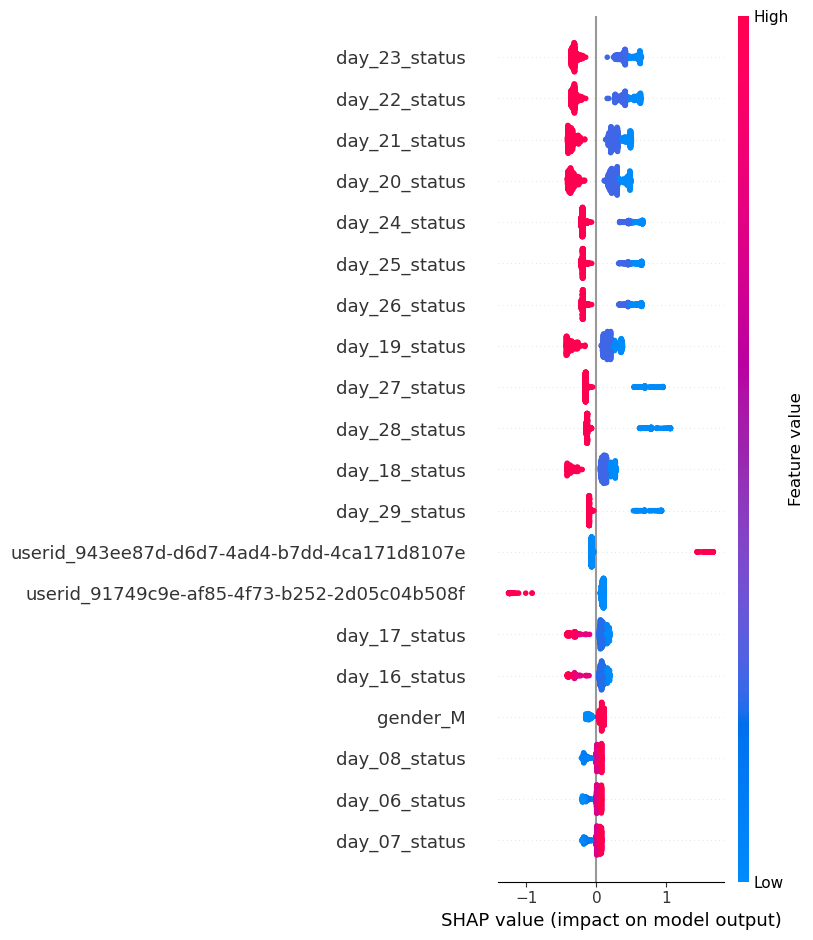

In [2]:
print(f'Test name: ks')

# 3-2) 추가 시각화 #@! 분할
# 예측값 vs 실제값의 산점도
plt.figure(figsize=(10, 5))
plt.scatter(y_val, predictions, alpha=0.3)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red')
plt.show()

# 잔차 플롯
# 잔차 계산
residuals = y_val - predictions.flatten()

plt.figure(figsize=(10, 5))
plt.scatter(predictions, residuals, alpha=0.3)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.hlines(0, min(predictions), max(predictions), colors='red')
plt.show()

# SHAP을 사용한 특성 중요도 시각화
shap.initjs()
explainer = shap.Explainer(model.predict, X_sub)
shap_values = explainer(X_val)
shap.summary_plot(shap_values, X_val, feature_names=X.columns.tolist())


Test name: ks


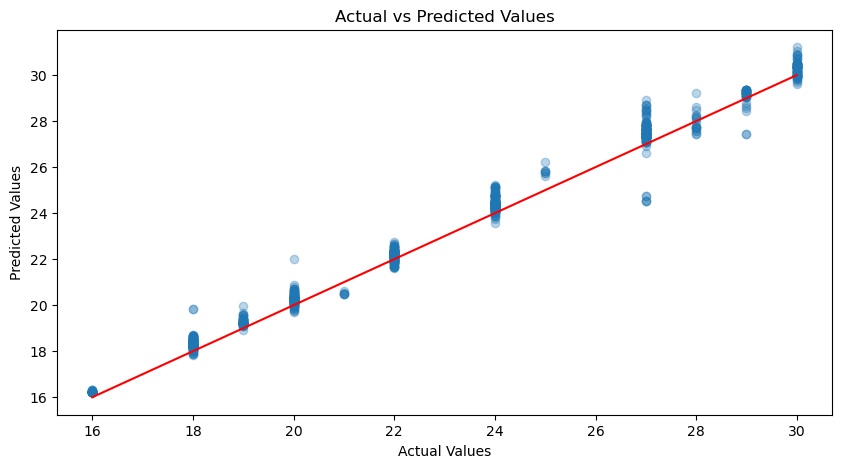

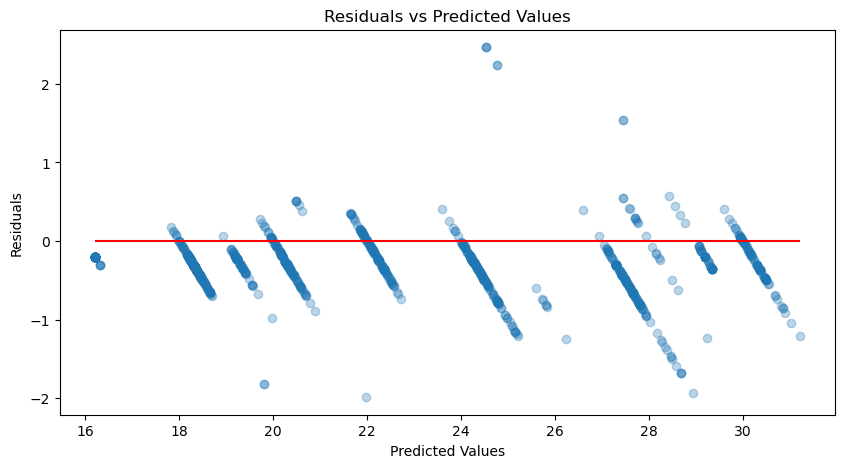

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step
171/171 ━━━

PermutationExplainer explainer:   3%|█▋                                                      | 32/1036 [00:00<?, ?it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step


PermutationExplainer explainer:   3%|█▌                                              | 34/1036 [00:10<02:27,  6.79it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step


PermutationExplainer explainer:   3%|█▌                                              | 35/1036 [00:10<03:43,  4.49it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step


PermutationExplainer explainer:   3%|█▋                                              | 36/1036 [00:11<04:38,  3.59it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step


PermutationExplainer explainer:   4%|█▋                                              | 37/1036 [00:11<37:49,  2.27s/it]


KeyboardInterrupt: 

In [3]:
print(f'Test name: ks')

# 3-2) 추가 시각화 #@! 분할
# 예측값 vs 실제값의 산점도
plt.figure(figsize=(10, 5))
plt.scatter(y_val, predictions, alpha=0.3)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red')
plt.show()

# 잔차 플롯
# 잔차 계산
residuals = y_val - predictions.flatten()

plt.figure(figsize=(10, 5))
plt.scatter(predictions, residuals, alpha=0.3)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.hlines(0, min(predictions), max(predictions), colors='red')
plt.show()

#  SHAP 특성 정확도랑 같이 돌릴려고 했지만, 이상 오류가나 잔차까지만 보고 바로 밑 셀에 다시 특성정확도만 보여줌.


D:\ANACONDA3_ENVS\DR\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 679us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
171/171 ━━━

PermutationExplainer explainer:   2%|█▏                                                      | 22/1036 [00:00<?, ?it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step


PermutationExplainer explainer:   2%|█                                               | 24/1036 [00:10<01:39, 10.22it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


PermutationExplainer explainer:   3%|█▏                                              | 26/1036 [00:10<02:58,  5.67it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step


PermutationExplainer explainer:   3%|█▎                                              | 27/1036 [00:11<03:19,  5.05it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step


PermutationExplainer explainer:   3%|█▎                                              | 28/1036 [00:11<03:20,  5.02it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step


PermutationExplainer explainer:   3%|█▎                                              | 29/1036 [00:11<03:37,  4.64it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step


PermutationExplainer explainer:   3%|█▍                                              | 30/1036 [00:11<03:46,  4.45it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step


PermutationExplainer explainer:   3%|█▍                                              | 31/1036 [00:11<03:38,  4.59it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step


PermutationExplainer explainer:   3%|█▍                                              | 32/1036 [00:12<03:31,  4.76it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


PermutationExplainer explainer:   3%|█▌                                              | 33/1036 [00:12<03:27,  4.84it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step


PermutationExplainer explainer:   3%|█▌                                              | 34/1036 [00:12<03:23,  4.93it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step


PermutationExplainer explainer:   3%|█▌                                              | 35/1036 [00:12<03:40,  4.55it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step


PermutationExplainer explainer:   3%|█▋                                              | 36/1036 [00:13<03:52,  4.30it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step


PermutationExplainer explainer:   4%|█▋                                              | 37/1036 [00:13<03:58,  4.19it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step


PermutationExplainer explainer:   4%|█▊                                              | 38/1036 [00:13<04:03,  4.11it/s]

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step


PermutationExplainer explainer:   4%|█▊                                              | 39/1036 [00:13<04:07,  4.03it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step


PermutationExplainer explainer:   4%|█▊                                              | 40/1036 [00:14<04:14,  3.91it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


PermutationExplainer explainer:   4%|█▉                                              | 41/1036 [00:14<04:01,  4.13it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step


PermutationExplainer explainer:   4%|█▉                                              | 42/1036 [00:14<04:01,  4.12it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step


PermutationExplainer explainer:   4%|█▉                                              | 43/1036 [00:14<04:07,  4.01it/s]

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


PermutationExplainer explainer:   4%|██                                              | 44/1036 [00:15<03:55,  4.21it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step


PermutationExplainer explainer:   4%|██                                              | 45/1036 [00:15<03:54,  4.23it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step


PermutationExplainer explainer:   4%|██▏                                             | 46/1036 [00:15<03:55,  4.21it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step


PermutationExplainer explainer:   5%|██▏                                             | 47/1036 [00:15<03:46,  4.36it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


PermutationExplainer explainer:   5%|██▏                                             | 48/1036 [00:15<03:47,  4.34it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


PermutationExplainer explainer:   5%|██▎                                             | 49/1036 [00:16<03:36,  4.55it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


PermutationExplainer explainer:   5%|██▎                                             | 50/1036 [00:16<03:42,  4.43it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step


PermutationExplainer explainer:   5%|██▎                                             | 51/1036 [00:16<04:02,  4.07it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step


PermutationExplainer explainer:   5%|██▍                                             | 52/1036 [00:16<03:53,  4.21it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step


PermutationExplainer explainer:   5%|██▍                                             | 53/1036 [00:17<03:41,  4.44it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step


PermutationExplainer explainer:   5%|██▌                                             | 54/1036 [00:17<03:55,  4.16it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


PermutationExplainer explainer:   5%|██▌                                             | 55/1036 [00:17<03:41,  4.43it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step


PermutationExplainer explainer:   5%|██▌                                             | 56/1036 [00:17<03:53,  4.20it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step


PermutationExplainer explainer:   6%|██▋                                             | 57/1036 [00:18<03:39,  4.46it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


PermutationExplainer explainer:   6%|██▋                                             | 58/1036 [00:18<03:42,  4.39it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step


PermutationExplainer explainer:   6%|██▋                                             | 59/1036 [00:18<03:36,  4.51it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step


PermutationExplainer explainer:   6%|██▊                                             | 60/1036 [00:18<03:38,  4.46it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step


PermutationExplainer explainer:   6%|██▊                                             | 61/1036 [00:18<03:33,  4.57it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


PermutationExplainer explainer:   6%|██▊                                             | 62/1036 [00:19<03:35,  4.51it/s]

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step


PermutationExplainer explainer:   6%|██▉                                             | 63/1036 [00:19<03:40,  4.42it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step


PermutationExplainer explainer:   6%|██▉                                             | 64/1036 [00:19<03:31,  4.60it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step


PermutationExplainer explainer:   6%|███                                             | 65/1036 [00:19<03:31,  4.59it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step


PermutationExplainer explainer:   6%|███                                             | 66/1036 [00:20<03:32,  4.56it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


PermutationExplainer explainer:   6%|███                                             | 67/1036 [00:20<03:35,  4.50it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step


PermutationExplainer explainer:   7%|███▏                                            | 68/1036 [00:20<03:37,  4.44it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step


PermutationExplainer explainer:   7%|███▏                                            | 69/1036 [00:20<03:31,  4.57it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step


PermutationExplainer explainer:   7%|███▏                                            | 70/1036 [00:20<03:34,  4.51it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step


PermutationExplainer explainer:   7%|███▎                                            | 71/1036 [00:21<03:32,  4.53it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step


PermutationExplainer explainer:   7%|███▎                                            | 72/1036 [00:21<03:35,  4.48it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step


PermutationExplainer explainer:   7%|███▍                                            | 73/1036 [00:21<03:44,  4.29it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


PermutationExplainer explainer:   7%|███▍                                            | 74/1036 [00:21<03:34,  4.48it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step


PermutationExplainer explainer:   7%|███▍                                            | 75/1036 [00:22<03:38,  4.40it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


PermutationExplainer explainer:   7%|███▌                                            | 76/1036 [00:22<03:27,  4.62it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


PermutationExplainer explainer:   7%|███▌                                            | 77/1036 [00:22<03:20,  4.79it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step


PermutationExplainer explainer:   8%|███▌                                            | 78/1036 [00:22<03:16,  4.87it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step


PermutationExplainer explainer:   8%|███▋                                            | 79/1036 [00:22<03:26,  4.63it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


PermutationExplainer explainer:   8%|███▋                                            | 80/1036 [00:23<03:25,  4.64it/s]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step


PermutationExplainer explainer:   8%|███▊                                            | 81/1036 [00:23<03:40,  4.33it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step


PermutationExplainer explainer:   8%|███▊                                            | 82/1036 [00:23<03:50,  4.13it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step


PermutationExplainer explainer:   8%|███▊                                            | 83/1036 [00:23<03:52,  4.11it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:   8%|███▉                                            | 84/1036 [00:24<03:39,  4.34it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:   8%|███▉                                            | 85/1036 [00:24<03:30,  4.52it/s]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


PermutationExplainer explainer:   8%|███▉                                            | 86/1036 [00:24<03:38,  4.34it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step


PermutationExplainer explainer:   8%|████                                            | 87/1036 [00:24<03:28,  4.55it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step


PermutationExplainer explainer:   8%|████                                            | 88/1036 [00:24<03:35,  4.39it/s]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step


PermutationExplainer explainer:   9%|████                                            | 89/1036 [00:25<03:44,  4.22it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step


PermutationExplainer explainer:   9%|████▏                                           | 90/1036 [00:25<03:33,  4.42it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


PermutationExplainer explainer:   9%|████▏                                           | 91/1036 [00:25<03:24,  4.62it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step


PermutationExplainer explainer:   9%|████▎                                           | 92/1036 [00:25<03:34,  4.40it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step


PermutationExplainer explainer:   9%|████▎                                           | 93/1036 [00:26<03:24,  4.62it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step


PermutationExplainer explainer:   9%|████▎                                           | 94/1036 [00:26<03:16,  4.80it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step


PermutationExplainer explainer:   9%|████▍                                           | 95/1036 [00:26<03:11,  4.91it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step


PermutationExplainer explainer:   9%|████▍                                           | 96/1036 [00:26<03:15,  4.80it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step


PermutationExplainer explainer:   9%|████▍                                           | 97/1036 [00:26<03:17,  4.76it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


PermutationExplainer explainer:   9%|████▌                                           | 98/1036 [00:27<03:11,  4.89it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step


PermutationExplainer explainer:  10%|████▌                                           | 99/1036 [00:27<03:18,  4.71it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


PermutationExplainer explainer:  10%|████▌                                          | 100/1036 [00:27<03:28,  4.49it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  10%|████▌                                          | 101/1036 [00:27<03:34,  4.36it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step


PermutationExplainer explainer:  10%|████▋                                          | 102/1036 [00:28<03:34,  4.35it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step


PermutationExplainer explainer:  10%|████▋                                          | 103/1036 [00:28<03:41,  4.21it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step


PermutationExplainer explainer:  10%|████▋                                          | 104/1036 [00:28<03:39,  4.25it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step


PermutationExplainer explainer:  10%|████▊                                          | 105/1036 [00:28<03:49,  4.05it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step


PermutationExplainer explainer:  10%|████▊                                          | 106/1036 [00:29<03:47,  4.09it/s]

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step


PermutationExplainer explainer:  10%|████▊                                          | 107/1036 [00:29<03:43,  4.16it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step


PermutationExplainer explainer:  10%|████▉                                          | 108/1036 [00:29<03:35,  4.31it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step


PermutationExplainer explainer:  11%|████▉                                          | 109/1036 [00:29<03:43,  4.15it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


PermutationExplainer explainer:  11%|████▉                                          | 110/1036 [00:29<03:33,  4.34it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step


PermutationExplainer explainer:  11%|█████                                          | 111/1036 [00:30<03:25,  4.50it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step


PermutationExplainer explainer:  11%|█████                                          | 112/1036 [00:30<03:16,  4.70it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


PermutationExplainer explainer:  11%|█████▏                                         | 113/1036 [00:30<03:17,  4.68it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


PermutationExplainer explainer:  11%|█████▏                                         | 114/1036 [00:30<03:22,  4.55it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step


PermutationExplainer explainer:  11%|█████▏                                         | 115/1036 [00:30<03:24,  4.51it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step


PermutationExplainer explainer:  11%|█████▎                                         | 116/1036 [00:31<03:26,  4.46it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


PermutationExplainer explainer:  11%|█████▎                                         | 117/1036 [00:31<03:30,  4.36it/s]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step


PermutationExplainer explainer:  11%|█████▎                                         | 118/1036 [00:31<03:44,  4.10it/s]

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step


PermutationExplainer explainer:  11%|█████▍                                         | 119/1036 [00:31<03:32,  4.31it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step


PermutationExplainer explainer:  12%|█████▍                                         | 120/1036 [00:32<03:35,  4.25it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


PermutationExplainer explainer:  12%|█████▍                                         | 121/1036 [00:32<03:40,  4.15it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


PermutationExplainer explainer:  12%|█████▌                                         | 122/1036 [00:32<03:32,  4.30it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step


PermutationExplainer explainer:  12%|█████▌                                         | 123/1036 [00:32<03:43,  4.08it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step


PermutationExplainer explainer:  12%|█████▋                                         | 124/1036 [00:33<03:38,  4.17it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step


PermutationExplainer explainer:  12%|█████▋                                         | 125/1036 [00:33<04:06,  3.70it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  12%|█████▋                                         | 126/1036 [00:33<04:01,  3.77it/s]

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step


PermutationExplainer explainer:  12%|█████▊                                         | 127/1036 [00:33<03:43,  4.07it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step


PermutationExplainer explainer:  12%|█████▊                                         | 128/1036 [00:34<03:42,  4.07it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step


PermutationExplainer explainer:  12%|█████▊                                         | 129/1036 [00:34<03:29,  4.34it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  13%|█████▉                                         | 130/1036 [00:34<03:20,  4.53it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step


PermutationExplainer explainer:  13%|█████▉                                         | 131/1036 [00:34<03:31,  4.28it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step


PermutationExplainer explainer:  13%|█████▉                                         | 132/1036 [00:35<03:34,  4.21it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  13%|██████                                         | 133/1036 [00:35<03:28,  4.32it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


PermutationExplainer explainer:  13%|██████                                         | 134/1036 [00:35<03:33,  4.23it/s]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step


PermutationExplainer explainer:  13%|██████                                         | 135/1036 [00:35<03:30,  4.29it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


PermutationExplainer explainer:  13%|██████▏                                        | 136/1036 [00:36<03:33,  4.23it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step


PermutationExplainer explainer:  13%|██████▏                                        | 137/1036 [00:36<03:20,  4.47it/s]

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


PermutationExplainer explainer:  13%|██████▎                                        | 138/1036 [00:36<03:50,  3.90it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step


PermutationExplainer explainer:  13%|██████▎                                        | 139/1036 [00:36<03:43,  4.01it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step


PermutationExplainer explainer:  14%|██████▎                                        | 140/1036 [00:37<03:34,  4.17it/s]

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step


PermutationExplainer explainer:  14%|██████▍                                        | 141/1036 [00:37<03:26,  4.34it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step


PermutationExplainer explainer:  14%|██████▍                                        | 142/1036 [00:37<03:19,  4.48it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


PermutationExplainer explainer:  14%|██████▍                                        | 143/1036 [00:37<03:14,  4.60it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step


PermutationExplainer explainer:  14%|██████▌                                        | 144/1036 [00:37<03:13,  4.61it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step


PermutationExplainer explainer:  14%|██████▌                                        | 145/1036 [00:38<03:06,  4.78it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step


PermutationExplainer explainer:  14%|██████▌                                        | 146/1036 [00:38<03:01,  4.91it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step


PermutationExplainer explainer:  14%|██████▋                                        | 147/1036 [00:38<02:58,  4.99it/s]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


PermutationExplainer explainer:  14%|██████▋                                        | 148/1036 [00:38<03:12,  4.62it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step


PermutationExplainer explainer:  14%|██████▊                                        | 149/1036 [00:38<03:15,  4.54it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  14%|██████▊                                        | 150/1036 [00:39<03:08,  4.70it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step


PermutationExplainer explainer:  15%|██████▊                                        | 151/1036 [00:39<03:17,  4.47it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step


PermutationExplainer explainer:  15%|██████▉                                        | 152/1036 [00:39<03:24,  4.32it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step


PermutationExplainer explainer:  15%|██████▉                                        | 153/1036 [00:39<03:18,  4.45it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step


PermutationExplainer explainer:  15%|██████▉                                        | 154/1036 [00:40<03:09,  4.65it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step


PermutationExplainer explainer:  15%|███████                                        | 155/1036 [00:40<03:05,  4.76it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step


PermutationExplainer explainer:  15%|███████                                        | 156/1036 [00:40<03:09,  4.64it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step


PermutationExplainer explainer:  15%|███████                                        | 157/1036 [00:40<03:03,  4.80it/s]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  15%|███████▏                                       | 158/1036 [00:40<03:16,  4.46it/s]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


PermutationExplainer explainer:  15%|███████▏                                       | 159/1036 [00:41<03:20,  4.37it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step


PermutationExplainer explainer:  15%|███████▎                                       | 160/1036 [00:41<03:23,  4.30it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


PermutationExplainer explainer:  16%|███████▎                                       | 161/1036 [00:41<03:12,  4.54it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step


PermutationExplainer explainer:  16%|███████▎                                       | 162/1036 [00:41<03:06,  4.68it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step


PermutationExplainer explainer:  16%|███████▍                                       | 163/1036 [00:41<03:04,  4.72it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step


PermutationExplainer explainer:  16%|███████▍                                       | 164/1036 [00:42<03:00,  4.84it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step


PermutationExplainer explainer:  16%|███████▍                                       | 165/1036 [00:42<02:56,  4.95it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step


PermutationExplainer explainer:  16%|███████▌                                       | 166/1036 [00:42<03:02,  4.77it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step


PermutationExplainer explainer:  16%|███████▌                                       | 167/1036 [00:42<03:31,  4.11it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step


PermutationExplainer explainer:  16%|███████▌                                       | 168/1036 [00:43<03:17,  4.40it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step


PermutationExplainer explainer:  16%|███████▋                                       | 169/1036 [00:43<03:07,  4.62it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step


PermutationExplainer explainer:  16%|███████▋                                       | 170/1036 [00:43<03:01,  4.77it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step


PermutationExplainer explainer:  17%|███████▊                                       | 171/1036 [00:43<03:04,  4.70it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step


PermutationExplainer explainer:  17%|███████▊                                       | 172/1036 [00:43<03:02,  4.73it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step


PermutationExplainer explainer:  17%|███████▊                                       | 173/1036 [00:44<02:57,  4.87it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step


PermutationExplainer explainer:  17%|███████▉                                       | 174/1036 [00:44<03:02,  4.73it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step


PermutationExplainer explainer:  17%|███████▉                                       | 175/1036 [00:44<02:56,  4.88it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


PermutationExplainer explainer:  17%|███████▉                                       | 176/1036 [00:44<02:51,  5.00it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step


PermutationExplainer explainer:  17%|████████                                       | 177/1036 [00:44<03:00,  4.77it/s]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step


PermutationExplainer explainer:  17%|████████                                       | 178/1036 [00:45<03:14,  4.41it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step


PermutationExplainer explainer:  17%|████████                                       | 179/1036 [00:45<03:19,  4.29it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step


PermutationExplainer explainer:  17%|████████▏                                      | 180/1036 [00:45<03:09,  4.52it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step


PermutationExplainer explainer:  17%|████████▏                                      | 181/1036 [00:45<03:16,  4.36it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step


PermutationExplainer explainer:  18%|████████▎                                      | 182/1036 [00:46<03:15,  4.38it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step


PermutationExplainer explainer:  18%|████████▎                                      | 183/1036 [00:46<03:13,  4.40it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


PermutationExplainer explainer:  18%|████████▎                                      | 184/1036 [00:46<03:06,  4.57it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step


PermutationExplainer explainer:  18%|████████▍                                      | 185/1036 [00:46<02:59,  4.75it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


PermutationExplainer explainer:  18%|████████▍                                      | 186/1036 [00:46<02:54,  4.86it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step


PermutationExplainer explainer:  18%|████████▍                                      | 187/1036 [00:47<03:07,  4.53it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


PermutationExplainer explainer:  18%|████████▌                                      | 188/1036 [00:47<03:10,  4.46it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


PermutationExplainer explainer:  18%|████████▌                                      | 189/1036 [00:47<03:00,  4.69it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


PermutationExplainer explainer:  18%|████████▌                                      | 190/1036 [00:47<02:56,  4.79it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step


PermutationExplainer explainer:  18%|████████▋                                      | 191/1036 [00:47<02:53,  4.87it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step


PermutationExplainer explainer:  19%|████████▋                                      | 192/1036 [00:48<02:48,  5.02it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step


PermutationExplainer explainer:  19%|████████▊                                      | 193/1036 [00:48<02:47,  5.03it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step


PermutationExplainer explainer:  19%|████████▊                                      | 194/1036 [00:48<02:44,  5.13it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


PermutationExplainer explainer:  19%|████████▊                                      | 195/1036 [00:48<02:44,  5.12it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


PermutationExplainer explainer:  19%|████████▉                                      | 196/1036 [00:48<02:52,  4.88it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  19%|████████▉                                      | 197/1036 [00:49<03:02,  4.60it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step


PermutationExplainer explainer:  19%|████████▉                                      | 198/1036 [00:49<03:03,  4.57it/s]

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


PermutationExplainer explainer:  19%|█████████                                      | 199/1036 [00:49<03:07,  4.47it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


PermutationExplainer explainer:  19%|█████████                                      | 200/1036 [00:49<02:59,  4.65it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


PermutationExplainer explainer:  19%|█████████                                      | 201/1036 [00:50<03:02,  4.59it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


PermutationExplainer explainer:  19%|█████████▏                                     | 202/1036 [00:50<02:55,  4.76it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step


PermutationExplainer explainer:  20%|█████████▏                                     | 203/1036 [00:50<02:58,  4.67it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


PermutationExplainer explainer:  20%|█████████▎                                     | 204/1036 [00:50<02:50,  4.87it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step


PermutationExplainer explainer:  20%|█████████▎                                     | 205/1036 [00:50<02:47,  4.97it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step


PermutationExplainer explainer:  20%|█████████▎                                     | 206/1036 [00:51<02:48,  4.94it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


PermutationExplainer explainer:  20%|█████████▍                                     | 207/1036 [00:51<02:54,  4.76it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step


PermutationExplainer explainer:  20%|█████████▍                                     | 208/1036 [00:51<02:51,  4.84it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step


PermutationExplainer explainer:  20%|█████████▍                                     | 209/1036 [00:51<03:00,  4.58it/s]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step


PermutationExplainer explainer:  20%|█████████▌                                     | 210/1036 [00:52<03:07,  4.40it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step


PermutationExplainer explainer:  20%|█████████▌                                     | 211/1036 [00:52<03:12,  4.29it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step


PermutationExplainer explainer:  20%|█████████▌                                     | 212/1036 [00:52<03:10,  4.32it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


PermutationExplainer explainer:  21%|█████████▋                                     | 213/1036 [00:52<03:11,  4.29it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step


PermutationExplainer explainer:  21%|█████████▋                                     | 214/1036 [00:52<03:12,  4.27it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step


PermutationExplainer explainer:  21%|█████████▊                                     | 215/1036 [00:53<03:13,  4.24it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step


PermutationExplainer explainer:  21%|█████████▊                                     | 216/1036 [00:53<03:11,  4.28it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


PermutationExplainer explainer:  21%|█████████▊                                     | 217/1036 [00:53<03:07,  4.36it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step


PermutationExplainer explainer:  21%|█████████▉                                     | 218/1036 [00:53<03:02,  4.48it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


PermutationExplainer explainer:  21%|█████████▉                                     | 219/1036 [00:54<02:56,  4.62it/s]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


PermutationExplainer explainer:  21%|█████████▉                                     | 220/1036 [00:54<03:03,  4.44it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step


PermutationExplainer explainer:  21%|██████████                                     | 221/1036 [00:54<02:55,  4.64it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


PermutationExplainer explainer:  21%|██████████                                     | 222/1036 [00:54<02:48,  4.83it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step


PermutationExplainer explainer:  22%|██████████                                     | 223/1036 [00:54<02:54,  4.65it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step


PermutationExplainer explainer:  22%|██████████▏                                    | 224/1036 [00:55<02:48,  4.82it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


PermutationExplainer explainer:  22%|██████████▏                                    | 225/1036 [00:55<02:44,  4.93it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step


PermutationExplainer explainer:  22%|██████████▎                                    | 226/1036 [00:55<02:55,  4.60it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step


PermutationExplainer explainer:  22%|██████████▎                                    | 227/1036 [00:55<03:04,  4.39it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  22%|██████████▎                                    | 228/1036 [00:56<02:58,  4.53it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step


PermutationExplainer explainer:  22%|██████████▍                                    | 229/1036 [00:56<02:59,  4.49it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step


PermutationExplainer explainer:  22%|██████████▍                                    | 230/1036 [00:56<02:52,  4.67it/s]

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step


PermutationExplainer explainer:  22%|██████████▍                                    | 231/1036 [00:56<02:51,  4.68it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step


PermutationExplainer explainer:  22%|██████████▌                                    | 232/1036 [00:56<02:46,  4.82it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step


PermutationExplainer explainer:  22%|██████████▌                                    | 233/1036 [00:57<02:45,  4.86it/s]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


PermutationExplainer explainer:  23%|██████████▌                                    | 234/1036 [00:57<02:40,  5.01it/s]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step


PermutationExplainer explainer:  23%|██████████▋                                    | 235/1036 [00:57<02:37,  5.09it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


PermutationExplainer explainer:  23%|██████████▋                                    | 236/1036 [00:57<02:41,  4.96it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step


PermutationExplainer explainer:  23%|██████████▊                                    | 237/1036 [00:57<02:49,  4.72it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


PermutationExplainer explainer:  23%|██████████▊                                    | 238/1036 [00:58<02:44,  4.85it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step


PermutationExplainer explainer:  23%|██████████▊                                    | 239/1036 [00:58<02:41,  4.95it/s]

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


PermutationExplainer explainer:  23%|██████████▉                                    | 240/1036 [00:58<02:49,  4.70it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step


PermutationExplainer explainer:  23%|██████████▉                                    | 241/1036 [00:58<02:56,  4.51it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step


PermutationExplainer explainer:  23%|██████████▉                                    | 242/1036 [00:58<03:00,  4.40it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step


PermutationExplainer explainer:  23%|███████████                                    | 243/1036 [00:59<02:52,  4.60it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


PermutationExplainer explainer:  24%|███████████                                    | 244/1036 [00:59<02:45,  4.79it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step


PermutationExplainer explainer:  24%|███████████                                    | 245/1036 [00:59<02:50,  4.63it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step


PermutationExplainer explainer:  24%|███████████▏                                   | 246/1036 [00:59<02:47,  4.72it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step


PermutationExplainer explainer:  24%|███████████▏                                   | 247/1036 [01:00<02:49,  4.67it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step


PermutationExplainer explainer:  24%|███████████▎                                   | 248/1036 [01:00<02:42,  4.84it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step


PermutationExplainer explainer:  24%|███████████▎                                   | 249/1036 [01:00<02:40,  4.92it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step


PermutationExplainer explainer:  24%|███████████▎                                   | 250/1036 [01:00<02:53,  4.54it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step


PermutationExplainer explainer:  24%|███████████▍                                   | 251/1036 [01:00<02:54,  4.50it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step


PermutationExplainer explainer:  24%|███████████▍                                   | 252/1036 [01:01<02:49,  4.62it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step


PermutationExplainer explainer:  24%|███████████▍                                   | 253/1036 [01:01<02:48,  4.64it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step


PermutationExplainer explainer:  25%|███████████▌                                   | 254/1036 [01:01<02:49,  4.62it/s]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step


PermutationExplainer explainer:  25%|███████████▌                                   | 255/1036 [01:01<02:45,  4.72it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step


PermutationExplainer explainer:  25%|███████████▌                                   | 256/1036 [01:01<02:40,  4.85it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


PermutationExplainer explainer:  25%|███████████▋                                   | 257/1036 [01:02<02:47,  4.66it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


PermutationExplainer explainer:  25%|███████████▋                                   | 258/1036 [01:02<02:46,  4.68it/s]

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


PermutationExplainer explainer:  25%|███████████▊                                   | 259/1036 [01:02<02:41,  4.80it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step


PermutationExplainer explainer:  25%|███████████▊                                   | 260/1036 [01:02<02:44,  4.72it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step


PermutationExplainer explainer:  25%|███████████▊                                   | 261/1036 [01:03<02:52,  4.48it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step


PermutationExplainer explainer:  25%|███████████▉                                   | 262/1036 [01:03<02:49,  4.56it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


PermutationExplainer explainer:  25%|███████████▉                                   | 263/1036 [01:03<02:44,  4.71it/s]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step


PermutationExplainer explainer:  25%|███████████▉                                   | 264/1036 [01:03<02:53,  4.46it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


PermutationExplainer explainer:  26%|████████████                                   | 265/1036 [01:03<02:53,  4.45it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step


PermutationExplainer explainer:  26%|████████████                                   | 266/1036 [01:04<02:53,  4.44it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step


PermutationExplainer explainer:  26%|████████████                                   | 267/1036 [01:04<03:00,  4.26it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


PermutationExplainer explainer:  26%|████████████▏                                  | 268/1036 [01:04<02:58,  4.29it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step


PermutationExplainer explainer:  26%|████████████▏                                  | 269/1036 [01:04<02:58,  4.30it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step


PermutationExplainer explainer:  26%|████████████▏                                  | 270/1036 [01:05<02:56,  4.35it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


PermutationExplainer explainer:  26%|████████████▎                                  | 271/1036 [01:05<02:54,  4.37it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


PermutationExplainer explainer:  26%|████████████▎                                  | 272/1036 [01:05<02:50,  4.49it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step


PermutationExplainer explainer:  26%|████████████▍                                  | 273/1036 [01:05<02:42,  4.69it/s]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


PermutationExplainer explainer:  26%|████████████▍                                  | 274/1036 [01:05<02:52,  4.41it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step


PermutationExplainer explainer:  27%|████████████▍                                  | 275/1036 [01:06<02:57,  4.28it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step


PermutationExplainer explainer:  27%|████████████▌                                  | 276/1036 [01:06<02:48,  4.52it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


PermutationExplainer explainer:  27%|████████████▌                                  | 277/1036 [01:06<02:44,  4.61it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step


PermutationExplainer explainer:  27%|████████████▌                                  | 278/1036 [01:06<02:39,  4.75it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step


PermutationExplainer explainer:  27%|████████████▋                                  | 279/1036 [01:07<02:47,  4.51it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step


PermutationExplainer explainer:  27%|████████████▋                                  | 280/1036 [01:07<02:41,  4.69it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step


PermutationExplainer explainer:  27%|████████████▋                                  | 281/1036 [01:07<02:36,  4.84it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


PermutationExplainer explainer:  27%|████████████▊                                  | 282/1036 [01:07<02:32,  4.96it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


PermutationExplainer explainer:  27%|████████████▊                                  | 283/1036 [01:07<02:31,  4.99it/s]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


PermutationExplainer explainer:  27%|████████████▉                                  | 284/1036 [01:08<02:42,  4.63it/s]

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step


PermutationExplainer explainer:  28%|████████████▉                                  | 285/1036 [01:08<02:37,  4.76it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


PermutationExplainer explainer:  28%|████████████▉                                  | 286/1036 [01:08<02:33,  4.89it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step


PermutationExplainer explainer:  28%|█████████████                                  | 287/1036 [01:08<02:30,  4.99it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step


PermutationExplainer explainer:  28%|█████████████                                  | 288/1036 [01:08<02:35,  4.81it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


PermutationExplainer explainer:  28%|█████████████                                  | 289/1036 [01:09<02:41,  4.62it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


PermutationExplainer explainer:  28%|█████████████▏                                 | 290/1036 [01:09<02:37,  4.74it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


PermutationExplainer explainer:  28%|█████████████▏                                 | 291/1036 [01:09<02:31,  4.90it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step


PermutationExplainer explainer:  28%|█████████████▏                                 | 292/1036 [01:09<02:29,  4.97it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step


PermutationExplainer explainer:  28%|█████████████▎                                 | 293/1036 [01:09<02:34,  4.80it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step


PermutationExplainer explainer:  28%|█████████████▎                                 | 294/1036 [01:10<02:32,  4.86it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step


PermutationExplainer explainer:  28%|█████████████▍                                 | 295/1036 [01:10<02:30,  4.93it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


PermutationExplainer explainer:  29%|█████████████▍                                 | 296/1036 [01:10<02:38,  4.68it/s]

136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step


PermutationExplainer explainer:  29%|█████████████▍                                 | 297/1036 [01:10<02:33,  4.82it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


PermutationExplainer explainer:  29%|█████████████▌                                 | 298/1036 [01:10<02:29,  4.93it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step


PermutationExplainer explainer:  29%|█████████████▌                                 | 299/1036 [01:11<02:29,  4.93it/s]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step


PermutationExplainer explainer:  29%|█████████████▌                                 | 300/1036 [01:11<02:39,  4.60it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


PermutationExplainer explainer:  29%|█████████████▋                                 | 301/1036 [01:11<02:36,  4.69it/s]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step


PermutationExplainer explainer:  29%|█████████████▋                                 | 302/1036 [01:11<02:45,  4.45it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step


PermutationExplainer explainer:  29%|█████████████▋                                 | 303/1036 [01:12<02:38,  4.61it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step


PermutationExplainer explainer:  29%|█████████████▊                                 | 304/1036 [01:12<02:34,  4.75it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step


PermutationExplainer explainer:  29%|█████████████▊                                 | 305/1036 [01:12<02:41,  4.54it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step


PermutationExplainer explainer:  30%|█████████████▉                                 | 306/1036 [01:12<02:43,  4.47it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


PermutationExplainer explainer:  30%|█████████████▉                                 | 307/1036 [01:12<02:36,  4.65it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step


PermutationExplainer explainer:  30%|█████████████▉                                 | 308/1036 [01:13<02:37,  4.63it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step


PermutationExplainer explainer:  30%|██████████████                                 | 309/1036 [01:13<02:37,  4.62it/s]

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


PermutationExplainer explainer:  30%|██████████████                                 | 310/1036 [01:13<02:40,  4.51it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


PermutationExplainer explainer:  30%|██████████████                                 | 311/1036 [01:13<02:47,  4.33it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step


PermutationExplainer explainer:  30%|██████████████▏                                | 312/1036 [01:14<02:50,  4.25it/s]

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


PermutationExplainer explainer:  30%|██████████████▏                                | 313/1036 [01:14<02:41,  4.47it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step


PermutationExplainer explainer:  30%|██████████████▏                                | 314/1036 [01:14<02:35,  4.66it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


PermutationExplainer explainer:  30%|██████████████▎                                | 315/1036 [01:14<02:28,  4.84it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step


PermutationExplainer explainer:  31%|██████████████▎                                | 316/1036 [01:14<02:28,  4.84it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step


PermutationExplainer explainer:  31%|██████████████▍                                | 317/1036 [01:15<02:33,  4.69it/s]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step


PermutationExplainer explainer:  31%|██████████████▍                                | 318/1036 [01:15<02:28,  4.83it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step


PermutationExplainer explainer:  31%|██████████████▍                                | 319/1036 [01:15<02:34,  4.65it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step


PermutationExplainer explainer:  31%|██████████████▌                                | 320/1036 [01:15<02:37,  4.54it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step


PermutationExplainer explainer:  31%|██████████████▌                                | 321/1036 [01:15<02:31,  4.72it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step


PermutationExplainer explainer:  31%|██████████████▌                                | 322/1036 [01:16<02:37,  4.53it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


PermutationExplainer explainer:  31%|██████████████▋                                | 323/1036 [01:16<02:31,  4.69it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


PermutationExplainer explainer:  31%|██████████████▋                                | 324/1036 [01:16<02:38,  4.50it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


PermutationExplainer explainer:  31%|██████████████▋                                | 325/1036 [01:16<02:43,  4.35it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step


PermutationExplainer explainer:  31%|██████████████▊                                | 326/1036 [01:17<02:37,  4.52it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step


PermutationExplainer explainer:  32%|██████████████▊                                | 327/1036 [01:17<02:33,  4.63it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


PermutationExplainer explainer:  32%|██████████████▉                                | 328/1036 [01:17<02:36,  4.52it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step


PermutationExplainer explainer:  32%|██████████████▉                                | 329/1036 [01:17<02:31,  4.68it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


PermutationExplainer explainer:  32%|██████████████▉                                | 330/1036 [01:17<02:29,  4.73it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step


PermutationExplainer explainer:  32%|███████████████                                | 331/1036 [01:18<02:26,  4.80it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step


PermutationExplainer explainer:  32%|███████████████                                | 332/1036 [01:18<02:23,  4.90it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step


PermutationExplainer explainer:  32%|███████████████                                | 333/1036 [01:18<02:21,  4.96it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


PermutationExplainer explainer:  32%|███████████████▏                               | 334/1036 [01:18<02:20,  5.01it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


PermutationExplainer explainer:  32%|███████████████▏                               | 335/1036 [01:18<02:23,  4.87it/s]

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step


PermutationExplainer explainer:  32%|███████████████▏                               | 336/1036 [01:19<02:22,  4.91it/s]

174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  33%|███████████████▎                               | 337/1036 [01:19<02:26,  4.78it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  33%|███████████████▎                               | 338/1036 [01:19<02:30,  4.65it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


PermutationExplainer explainer:  33%|███████████████▍                               | 339/1036 [01:19<02:32,  4.57it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step


PermutationExplainer explainer:  33%|███████████████▍                               | 340/1036 [01:20<02:39,  4.36it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step


PermutationExplainer explainer:  33%|███████████████▍                               | 341/1036 [01:20<02:36,  4.43it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step


PermutationExplainer explainer:  33%|███████████████▌                               | 342/1036 [01:20<02:35,  4.47it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step


PermutationExplainer explainer:  33%|███████████████▌                               | 343/1036 [01:20<02:40,  4.31it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step


PermutationExplainer explainer:  33%|███████████████▌                               | 344/1036 [01:20<02:38,  4.36it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


PermutationExplainer explainer:  33%|███████████████▋                               | 345/1036 [01:21<02:32,  4.52it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step


PermutationExplainer explainer:  33%|███████████████▋                               | 346/1036 [01:21<02:27,  4.69it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step


PermutationExplainer explainer:  33%|███████████████▋                               | 347/1036 [01:21<02:33,  4.50it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


PermutationExplainer explainer:  34%|███████████████▊                               | 348/1036 [01:21<02:36,  4.39it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step


PermutationExplainer explainer:  34%|███████████████▊                               | 349/1036 [01:22<02:36,  4.40it/s]

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


PermutationExplainer explainer:  34%|███████████████▉                               | 350/1036 [01:22<02:32,  4.51it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step


PermutationExplainer explainer:  34%|███████████████▉                               | 351/1036 [01:22<02:36,  4.38it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step


PermutationExplainer explainer:  34%|███████████████▉                               | 352/1036 [01:22<02:38,  4.32it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step


PermutationExplainer explainer:  34%|████████████████                               | 353/1036 [01:22<02:30,  4.55it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step


PermutationExplainer explainer:  34%|████████████████                               | 354/1036 [01:23<02:23,  4.75it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step


PermutationExplainer explainer:  34%|████████████████                               | 355/1036 [01:23<02:19,  4.89it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


PermutationExplainer explainer:  34%|████████████████▏                              | 356/1036 [01:23<02:17,  4.94it/s]

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step


PermutationExplainer explainer:  34%|████████████████▏                              | 357/1036 [01:23<02:24,  4.69it/s]

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step


PermutationExplainer explainer:  35%|████████████████▏                              | 358/1036 [01:23<02:22,  4.77it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step


PermutationExplainer explainer:  35%|████████████████▎                              | 359/1036 [01:24<02:21,  4.79it/s]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step


PermutationExplainer explainer:  35%|████████████████▎                              | 360/1036 [01:24<02:27,  4.59it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  35%|████████████████▍                              | 361/1036 [01:24<02:27,  4.59it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step


PermutationExplainer explainer:  35%|████████████████▍                              | 362/1036 [01:24<02:22,  4.73it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step


PermutationExplainer explainer:  35%|████████████████▍                              | 363/1036 [01:25<02:18,  4.85it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step


PermutationExplainer explainer:  35%|████████████████▌                              | 364/1036 [01:25<02:26,  4.58it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step


PermutationExplainer explainer:  35%|████████████████▌                              | 365/1036 [01:25<02:22,  4.69it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


PermutationExplainer explainer:  35%|████████████████▌                              | 366/1036 [01:25<02:22,  4.71it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step


PermutationExplainer explainer:  35%|████████████████▋                              | 367/1036 [01:25<02:24,  4.62it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  36%|████████████████▋                              | 368/1036 [01:26<02:29,  4.48it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step


PermutationExplainer explainer:  36%|████████████████▋                              | 369/1036 [01:26<02:27,  4.53it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step


PermutationExplainer explainer:  36%|████████████████▊                              | 370/1036 [01:26<02:29,  4.45it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step


PermutationExplainer explainer:  36%|████████████████▊                              | 371/1036 [01:26<02:25,  4.56it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step


PermutationExplainer explainer:  36%|████████████████▉                              | 372/1036 [01:27<02:24,  4.60it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step


PermutationExplainer explainer:  36%|████████████████▉                              | 373/1036 [01:27<02:30,  4.40it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step


PermutationExplainer explainer:  36%|████████████████▉                              | 374/1036 [01:27<02:32,  4.33it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


PermutationExplainer explainer:  36%|█████████████████                              | 375/1036 [01:27<02:25,  4.55it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


PermutationExplainer explainer:  36%|█████████████████                              | 376/1036 [01:27<02:25,  4.53it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step


PermutationExplainer explainer:  36%|█████████████████                              | 377/1036 [01:28<02:27,  4.47it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step


PermutationExplainer explainer:  36%|█████████████████▏                             | 378/1036 [01:28<02:21,  4.66it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step


PermutationExplainer explainer:  37%|█████████████████▏                             | 379/1036 [01:28<02:20,  4.69it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  37%|█████████████████▏                             | 380/1036 [01:28<02:17,  4.77it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


PermutationExplainer explainer:  37%|█████████████████▎                             | 381/1036 [01:28<02:19,  4.68it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


PermutationExplainer explainer:  37%|█████████████████▎                             | 382/1036 [01:29<02:16,  4.80it/s]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step


PermutationExplainer explainer:  37%|█████████████████▍                             | 383/1036 [01:29<02:23,  4.57it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step


PermutationExplainer explainer:  37%|█████████████████▍                             | 384/1036 [01:29<02:18,  4.72it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step


PermutationExplainer explainer:  37%|█████████████████▍                             | 385/1036 [01:29<02:27,  4.43it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step


PermutationExplainer explainer:  37%|█████████████████▌                             | 386/1036 [01:30<02:29,  4.36it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step


PermutationExplainer explainer:  37%|█████████████████▌                             | 387/1036 [01:30<02:21,  4.59it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step


PermutationExplainer explainer:  37%|█████████████████▌                             | 388/1036 [01:30<02:22,  4.55it/s]

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step


PermutationExplainer explainer:  38%|█████████████████▋                             | 389/1036 [01:30<02:28,  4.36it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step


PermutationExplainer explainer:  38%|█████████████████▋                             | 390/1036 [01:31<02:26,  4.40it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step


PermutationExplainer explainer:  38%|█████████████████▋                             | 391/1036 [01:31<02:20,  4.59it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


PermutationExplainer explainer:  38%|█████████████████▊                             | 392/1036 [01:31<02:15,  4.75it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


PermutationExplainer explainer:  38%|█████████████████▊                             | 393/1036 [01:31<02:18,  4.65it/s]

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step


PermutationExplainer explainer:  38%|█████████████████▊                             | 394/1036 [01:31<02:21,  4.54it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step


PermutationExplainer explainer:  38%|█████████████████▉                             | 395/1036 [01:32<02:25,  4.41it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step


PermutationExplainer explainer:  38%|█████████████████▉                             | 396/1036 [01:32<02:26,  4.38it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step


PermutationExplainer explainer:  38%|██████████████████                             | 397/1036 [01:32<02:25,  4.40it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step


PermutationExplainer explainer:  38%|██████████████████                             | 398/1036 [01:32<02:27,  4.32it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step


PermutationExplainer explainer:  39%|██████████████████                             | 399/1036 [01:32<02:19,  4.57it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step


PermutationExplainer explainer:  39%|██████████████████▏                            | 400/1036 [01:33<02:22,  4.45it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step


PermutationExplainer explainer:  39%|██████████████████▏                            | 401/1036 [01:33<02:17,  4.62it/s]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step


PermutationExplainer explainer:  39%|██████████████████▏                            | 402/1036 [01:33<02:22,  4.44it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step


PermutationExplainer explainer:  39%|██████████████████▎                            | 403/1036 [01:33<02:27,  4.29it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step


PermutationExplainer explainer:  39%|██████████████████▎                            | 404/1036 [01:34<02:19,  4.54it/s]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


PermutationExplainer explainer:  39%|██████████████████▎                            | 405/1036 [01:34<02:28,  4.25it/s]

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step


PermutationExplainer explainer:  39%|██████████████████▍                            | 406/1036 [01:34<02:28,  4.23it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step


PermutationExplainer explainer:  39%|██████████████████▍                            | 407/1036 [01:34<02:28,  4.25it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step


PermutationExplainer explainer:  39%|██████████████████▌                            | 408/1036 [01:35<02:23,  4.38it/s]

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step


PermutationExplainer explainer:  39%|██████████████████▌                            | 409/1036 [01:35<02:24,  4.34it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


PermutationExplainer explainer:  40%|██████████████████▌                            | 410/1036 [01:35<02:27,  4.23it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step


PermutationExplainer explainer:  40%|██████████████████▋                            | 411/1036 [01:35<02:19,  4.48it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


PermutationExplainer explainer:  40%|██████████████████▋                            | 412/1036 [01:35<02:14,  4.65it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step


PermutationExplainer explainer:  40%|██████████████████▋                            | 413/1036 [01:36<02:16,  4.58it/s]

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step


PermutationExplainer explainer:  40%|██████████████████▊                            | 414/1036 [01:36<02:19,  4.45it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


PermutationExplainer explainer:  40%|██████████████████▊                            | 415/1036 [01:36<02:17,  4.52it/s]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step


PermutationExplainer explainer:  40%|██████████████████▊                            | 416/1036 [01:36<02:20,  4.40it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


PermutationExplainer explainer:  40%|██████████████████▉                            | 417/1036 [01:37<02:13,  4.63it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


PermutationExplainer explainer:  40%|██████████████████▉                            | 418/1036 [01:37<02:09,  4.76it/s]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step


PermutationExplainer explainer:  40%|███████████████████                            | 419/1036 [01:37<02:18,  4.45it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step


PermutationExplainer explainer:  41%|███████████████████                            | 420/1036 [01:37<02:19,  4.43it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step


PermutationExplainer explainer:  41%|███████████████████                            | 421/1036 [01:37<02:13,  4.61it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step


PermutationExplainer explainer:  41%|███████████████████▏                           | 422/1036 [01:38<02:20,  4.38it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step


PermutationExplainer explainer:  41%|███████████████████▏                           | 423/1036 [01:38<02:13,  4.59it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step


PermutationExplainer explainer:  41%|███████████████████▏                           | 424/1036 [01:38<02:08,  4.76it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step


PermutationExplainer explainer:  41%|███████████████████▎                           | 425/1036 [01:38<02:06,  4.83it/s]

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step


PermutationExplainer explainer:  41%|███████████████████▎                           | 426/1036 [01:38<02:06,  4.83it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step


PermutationExplainer explainer:  41%|███████████████████▎                           | 427/1036 [01:39<02:09,  4.71it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step


PermutationExplainer explainer:  41%|███████████████████▍                           | 428/1036 [01:39<02:07,  4.77it/s]

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


PermutationExplainer explainer:  41%|███████████████████▍                           | 429/1036 [01:39<02:11,  4.62it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step


PermutationExplainer explainer:  42%|███████████████████▌                           | 430/1036 [01:39<02:30,  4.03it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step


PermutationExplainer explainer:  42%|███████████████████▌                           | 431/1036 [01:40<02:31,  4.00it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step


PermutationExplainer explainer:  42%|███████████████████▌                           | 432/1036 [01:40<02:21,  4.27it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step


PermutationExplainer explainer:  42%|███████████████████▋                           | 433/1036 [01:40<02:14,  4.47it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step


PermutationExplainer explainer:  42%|███████████████████▋                           | 434/1036 [01:40<02:18,  4.34it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step


PermutationExplainer explainer:  42%|███████████████████▋                           | 435/1036 [01:41<02:15,  4.42it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step


PermutationExplainer explainer:  42%|███████████████████▊                           | 436/1036 [01:41<02:20,  4.26it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step


PermutationExplainer explainer:  42%|███████████████████▊                           | 437/1036 [01:41<02:22,  4.20it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step


PermutationExplainer explainer:  42%|███████████████████▊                           | 438/1036 [01:41<02:14,  4.43it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step


PermutationExplainer explainer:  42%|███████████████████▉                           | 439/1036 [01:41<02:08,  4.63it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step


PermutationExplainer explainer:  42%|███████████████████▉                           | 440/1036 [01:42<02:05,  4.77it/s]

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step


PermutationExplainer explainer:  43%|████████████████████                           | 441/1036 [01:42<02:14,  4.44it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step


PermutationExplainer explainer:  43%|████████████████████                           | 442/1036 [01:42<02:07,  4.65it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


PermutationExplainer explainer:  43%|████████████████████                           | 443/1036 [01:42<02:09,  4.58it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


PermutationExplainer explainer:  43%|████████████████████▏                          | 444/1036 [01:43<02:07,  4.64it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


PermutationExplainer explainer:  43%|████████████████████▏                          | 445/1036 [01:43<02:07,  4.65it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


PermutationExplainer explainer:  43%|████████████████████▏                          | 446/1036 [01:43<02:15,  4.34it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


PermutationExplainer explainer:  43%|████████████████████▎                          | 447/1036 [01:43<02:11,  4.47it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step


PermutationExplainer explainer:  43%|████████████████████▎                          | 448/1036 [01:43<02:15,  4.35it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step


PermutationExplainer explainer:  43%|████████████████████▎                          | 449/1036 [01:44<02:08,  4.56it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step


PermutationExplainer explainer:  43%|████████████████████▍                          | 450/1036 [01:44<02:10,  4.50it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step


PermutationExplainer explainer:  44%|████████████████████▍                          | 451/1036 [01:44<02:15,  4.32it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


PermutationExplainer explainer:  44%|████████████████████▌                          | 452/1036 [01:44<02:12,  4.42it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step


PermutationExplainer explainer:  44%|████████████████████▌                          | 453/1036 [01:45<02:13,  4.38it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step


PermutationExplainer explainer:  44%|████████████████████▌                          | 454/1036 [01:45<02:16,  4.27it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step


PermutationExplainer explainer:  44%|████████████████████▋                          | 455/1036 [01:45<02:20,  4.14it/s]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step


PermutationExplainer explainer:  44%|████████████████████▋                          | 456/1036 [01:45<02:22,  4.08it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step


PermutationExplainer explainer:  44%|████████████████████▋                          | 457/1036 [01:46<02:18,  4.20it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


PermutationExplainer explainer:  44%|████████████████████▊                          | 458/1036 [01:46<02:21,  4.10it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


PermutationExplainer explainer:  44%|████████████████████▊                          | 459/1036 [01:46<02:19,  4.13it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step


PermutationExplainer explainer:  44%|████████████████████▊                          | 460/1036 [01:46<02:13,  4.30it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step


PermutationExplainer explainer:  44%|████████████████████▉                          | 461/1036 [01:47<02:12,  4.34it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step


PermutationExplainer explainer:  45%|████████████████████▉                          | 462/1036 [01:47<02:13,  4.30it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step


PermutationExplainer explainer:  45%|█████████████████████                          | 463/1036 [01:47<02:13,  4.30it/s]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step


PermutationExplainer explainer:  45%|█████████████████████                          | 464/1036 [01:47<02:17,  4.17it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step


PermutationExplainer explainer:  45%|█████████████████████                          | 465/1036 [01:47<02:15,  4.22it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step


PermutationExplainer explainer:  45%|█████████████████████▏                         | 466/1036 [01:48<02:07,  4.47it/s]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


PermutationExplainer explainer:  45%|█████████████████████▏                         | 467/1036 [01:48<02:12,  4.29it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step


PermutationExplainer explainer:  45%|█████████████████████▏                         | 468/1036 [01:48<02:08,  4.42it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step


PermutationExplainer explainer:  45%|█████████████████████▎                         | 469/1036 [01:48<02:10,  4.33it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step


PermutationExplainer explainer:  45%|█████████████████████▎                         | 470/1036 [01:49<02:10,  4.35it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step


PermutationExplainer explainer:  45%|█████████████████████▎                         | 471/1036 [01:49<02:04,  4.56it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step


PermutationExplainer explainer:  46%|█████████████████████▍                         | 472/1036 [01:49<02:05,  4.51it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step


PermutationExplainer explainer:  46%|█████████████████████▍                         | 473/1036 [01:49<02:00,  4.68it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step


PermutationExplainer explainer:  46%|█████████████████████▌                         | 474/1036 [01:49<01:56,  4.81it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step


PermutationExplainer explainer:  46%|█████████████████████▌                         | 475/1036 [01:50<01:58,  4.75it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step


PermutationExplainer explainer:  46%|█████████████████████▌                         | 476/1036 [01:50<02:01,  4.60it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


PermutationExplainer explainer:  46%|█████████████████████▋                         | 477/1036 [01:50<02:04,  4.51it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step


PermutationExplainer explainer:  46%|█████████████████████▋                         | 478/1036 [01:50<01:58,  4.69it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


PermutationExplainer explainer:  46%|█████████████████████▋                         | 479/1036 [01:50<01:55,  4.82it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step


PermutationExplainer explainer:  46%|█████████████████████▊                         | 480/1036 [01:51<01:52,  4.92it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step


PermutationExplainer explainer:  46%|█████████████████████▊                         | 481/1036 [01:51<01:57,  4.74it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


PermutationExplainer explainer:  47%|█████████████████████▊                         | 482/1036 [01:51<01:58,  4.67it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


PermutationExplainer explainer:  47%|█████████████████████▉                         | 483/1036 [01:51<02:03,  4.47it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step


PermutationExplainer explainer:  47%|█████████████████████▉                         | 484/1036 [01:52<02:03,  4.46it/s]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step


PermutationExplainer explainer:  47%|██████████████████████                         | 485/1036 [01:52<02:10,  4.24it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step


PermutationExplainer explainer:  47%|██████████████████████                         | 486/1036 [01:52<02:03,  4.47it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  47%|██████████████████████                         | 487/1036 [01:52<02:08,  4.27it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step


PermutationExplainer explainer:  47%|██████████████████████▏                        | 488/1036 [01:53<02:02,  4.47it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step


PermutationExplainer explainer:  47%|██████████████████████▏                        | 489/1036 [01:53<02:03,  4.45it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


PermutationExplainer explainer:  47%|██████████████████████▏                        | 490/1036 [01:53<01:58,  4.61it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


PermutationExplainer explainer:  47%|██████████████████████▎                        | 491/1036 [01:53<01:58,  4.58it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


PermutationExplainer explainer:  47%|██████████████████████▎                        | 492/1036 [01:53<01:54,  4.75it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step


PermutationExplainer explainer:  48%|██████████████████████▎                        | 493/1036 [01:54<01:58,  4.58it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step


PermutationExplainer explainer:  48%|██████████████████████▍                        | 494/1036 [01:54<01:59,  4.54it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step


PermutationExplainer explainer:  48%|██████████████████████▍                        | 495/1036 [01:54<02:04,  4.35it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


PermutationExplainer explainer:  48%|██████████████████████▌                        | 496/1036 [01:54<01:58,  4.55it/s]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step


PermutationExplainer explainer:  48%|██████████████████████▌                        | 497/1036 [01:55<02:03,  4.38it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step


PermutationExplainer explainer:  48%|██████████████████████▌                        | 498/1036 [01:55<02:06,  4.26it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step


PermutationExplainer explainer:  48%|██████████████████████▋                        | 499/1036 [01:55<02:03,  4.36it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step


PermutationExplainer explainer:  48%|██████████████████████▋                        | 500/1036 [01:55<02:05,  4.29it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step


PermutationExplainer explainer:  48%|██████████████████████▋                        | 501/1036 [01:55<02:07,  4.21it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step


PermutationExplainer explainer:  48%|██████████████████████▊                        | 502/1036 [01:56<01:59,  4.47it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step


PermutationExplainer explainer:  49%|██████████████████████▊                        | 503/1036 [01:56<02:22,  3.75it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step


PermutationExplainer explainer:  49%|██████████████████████▊                        | 504/1036 [01:56<02:14,  3.97it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


PermutationExplainer explainer:  49%|██████████████████████▉                        | 505/1036 [01:56<02:08,  4.12it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


PermutationExplainer explainer:  49%|██████████████████████▉                        | 506/1036 [01:57<02:10,  4.07it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step


PermutationExplainer explainer:  49%|███████████████████████                        | 507/1036 [01:57<02:08,  4.13it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step


PermutationExplainer explainer:  49%|███████████████████████                        | 508/1036 [01:57<02:00,  4.39it/s]

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step


PermutationExplainer explainer:  49%|███████████████████████                        | 509/1036 [01:57<02:15,  3.90it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


PermutationExplainer explainer:  49%|███████████████████████▏                       | 510/1036 [01:58<02:04,  4.21it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step


PermutationExplainer explainer:  49%|███████████████████████▏                       | 511/1036 [01:58<02:04,  4.21it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step


PermutationExplainer explainer:  49%|███████████████████████▏                       | 512/1036 [01:58<02:01,  4.33it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step


PermutationExplainer explainer:  50%|███████████████████████▎                       | 513/1036 [01:58<01:59,  4.38it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step


PermutationExplainer explainer:  50%|███████████████████████▎                       | 514/1036 [01:59<01:56,  4.48it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step


PermutationExplainer explainer:  50%|███████████████████████▎                       | 515/1036 [01:59<01:59,  4.36it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step


PermutationExplainer explainer:  50%|███████████████████████▍                       | 516/1036 [01:59<01:59,  4.34it/s]

136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step


PermutationExplainer explainer:  50%|███████████████████████▍                       | 517/1036 [01:59<01:53,  4.58it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step


PermutationExplainer explainer:  50%|███████████████████████▌                       | 518/1036 [01:59<01:57,  4.41it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step


PermutationExplainer explainer:  50%|███████████████████████▌                       | 519/1036 [02:00<01:53,  4.57it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step


PermutationExplainer explainer:  50%|███████████████████████▌                       | 520/1036 [02:00<01:57,  4.41it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step


PermutationExplainer explainer:  50%|███████████████████████▋                       | 521/1036 [02:00<01:57,  4.38it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step


PermutationExplainer explainer:  50%|███████████████████████▋                       | 522/1036 [02:00<02:00,  4.26it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


PermutationExplainer explainer:  50%|███████████████████████▋                       | 523/1036 [02:01<01:59,  4.28it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step


PermutationExplainer explainer:  51%|███████████████████████▊                       | 524/1036 [02:01<01:53,  4.51it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step


PermutationExplainer explainer:  51%|███████████████████████▊                       | 525/1036 [02:01<01:57,  4.35it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step


PermutationExplainer explainer:  51%|███████████████████████▊                       | 526/1036 [02:01<01:55,  4.43it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step


PermutationExplainer explainer:  51%|███████████████████████▉                       | 527/1036 [02:01<01:52,  4.54it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step


PermutationExplainer explainer:  51%|███████████████████████▉                       | 528/1036 [02:02<01:53,  4.49it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step


PermutationExplainer explainer:  51%|███████████████████████▉                       | 529/1036 [02:02<01:50,  4.59it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


PermutationExplainer explainer:  51%|████████████████████████                       | 530/1036 [02:02<01:50,  4.59it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step


PermutationExplainer explainer:  51%|████████████████████████                       | 531/1036 [02:02<01:49,  4.60it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step


PermutationExplainer explainer:  51%|████████████████████████▏                      | 532/1036 [02:03<01:54,  4.42it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step


PermutationExplainer explainer:  51%|████████████████████████▏                      | 533/1036 [02:03<01:48,  4.62it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step


PermutationExplainer explainer:  52%|████████████████████████▏                      | 534/1036 [02:03<01:52,  4.47it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


PermutationExplainer explainer:  52%|████████████████████████▎                      | 535/1036 [02:03<01:48,  4.63it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


PermutationExplainer explainer:  52%|████████████████████████▎                      | 536/1036 [02:03<01:47,  4.64it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


PermutationExplainer explainer:  52%|████████████████████████▎                      | 537/1036 [02:04<01:50,  4.52it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step


PermutationExplainer explainer:  52%|████████████████████████▍                      | 538/1036 [02:04<01:46,  4.68it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


PermutationExplainer explainer:  52%|████████████████████████▍                      | 539/1036 [02:04<01:48,  4.59it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step


PermutationExplainer explainer:  52%|████████████████████████▍                      | 540/1036 [02:04<01:44,  4.75it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


PermutationExplainer explainer:  52%|████████████████████████▌                      | 541/1036 [02:04<01:42,  4.82it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  52%|████████████████████████▌                      | 542/1036 [02:05<01:43,  4.78it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step


PermutationExplainer explainer:  52%|████████████████████████▋                      | 543/1036 [02:05<01:49,  4.49it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


PermutationExplainer explainer:  53%|████████████████████████▋                      | 544/1036 [02:05<01:45,  4.67it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step


PermutationExplainer explainer:  53%|████████████████████████▋                      | 545/1036 [02:05<01:41,  4.82it/s]

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step


PermutationExplainer explainer:  53%|████████████████████████▊                      | 546/1036 [02:06<01:44,  4.69it/s]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


PermutationExplainer explainer:  53%|████████████████████████▊                      | 547/1036 [02:06<01:52,  4.35it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step


PermutationExplainer explainer:  53%|████████████████████████▊                      | 548/1036 [02:06<01:47,  4.55it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step


PermutationExplainer explainer:  53%|████████████████████████▉                      | 549/1036 [02:06<01:42,  4.77it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step


PermutationExplainer explainer:  53%|████████████████████████▉                      | 550/1036 [02:06<01:45,  4.60it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step


PermutationExplainer explainer:  53%|████████████████████████▉                      | 551/1036 [02:07<01:49,  4.42it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step


PermutationExplainer explainer:  53%|█████████████████████████                      | 552/1036 [02:07<01:45,  4.58it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step


PermutationExplainer explainer:  53%|█████████████████████████                      | 553/1036 [02:07<01:46,  4.54it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step


PermutationExplainer explainer:  53%|█████████████████████████▏                     | 554/1036 [02:07<01:48,  4.44it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step


PermutationExplainer explainer:  54%|█████████████████████████▏                     | 555/1036 [02:08<01:43,  4.64it/s]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step


PermutationExplainer explainer:  54%|█████████████████████████▏                     | 556/1036 [02:08<01:48,  4.42it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  54%|█████████████████████████▎                     | 557/1036 [02:08<01:44,  4.59it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


PermutationExplainer explainer:  54%|█████████████████████████▎                     | 558/1036 [02:08<01:41,  4.73it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step


PermutationExplainer explainer:  54%|█████████████████████████▎                     | 559/1036 [02:08<01:44,  4.58it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step


PermutationExplainer explainer:  54%|█████████████████████████▍                     | 560/1036 [02:09<01:40,  4.73it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step


PermutationExplainer explainer:  54%|█████████████████████████▍                     | 561/1036 [02:09<01:43,  4.61it/s]

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step


PermutationExplainer explainer:  54%|█████████████████████████▍                     | 562/1036 [02:09<01:40,  4.70it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


PermutationExplainer explainer:  54%|█████████████████████████▌                     | 563/1036 [02:09<01:38,  4.81it/s]

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


PermutationExplainer explainer:  54%|█████████████████████████▌                     | 564/1036 [02:09<01:37,  4.85it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step


PermutationExplainer explainer:  55%|█████████████████████████▋                     | 565/1036 [02:10<01:35,  4.93it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


PermutationExplainer explainer:  55%|█████████████████████████▋                     | 566/1036 [02:10<01:40,  4.68it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


PermutationExplainer explainer:  55%|█████████████████████████▋                     | 567/1036 [02:10<01:38,  4.76it/s]

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step


PermutationExplainer explainer:  55%|█████████████████████████▊                     | 568/1036 [02:10<01:41,  4.60it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


PermutationExplainer explainer:  55%|█████████████████████████▊                     | 569/1036 [02:11<01:38,  4.75it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  55%|█████████████████████████▊                     | 570/1036 [02:11<01:41,  4.57it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step


PermutationExplainer explainer:  55%|█████████████████████████▉                     | 571/1036 [02:11<01:39,  4.66it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step


PermutationExplainer explainer:  55%|█████████████████████████▉                     | 572/1036 [02:11<01:41,  4.57it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step


PermutationExplainer explainer:  55%|█████████████████████████▉                     | 573/1036 [02:11<01:39,  4.66it/s]

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


PermutationExplainer explainer:  55%|██████████████████████████                     | 574/1036 [02:12<01:37,  4.74it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step


PermutationExplainer explainer:  56%|██████████████████████████                     | 575/1036 [02:12<01:40,  4.58it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step


PermutationExplainer explainer:  56%|██████████████████████████▏                    | 576/1036 [02:12<01:40,  4.56it/s]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step


PermutationExplainer explainer:  56%|██████████████████████████▏                    | 577/1036 [02:12<01:46,  4.30it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step


PermutationExplainer explainer:  56%|██████████████████████████▏                    | 578/1036 [02:13<01:46,  4.30it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


PermutationExplainer explainer:  56%|██████████████████████████▎                    | 579/1036 [02:13<01:42,  4.44it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step


PermutationExplainer explainer:  56%|██████████████████████████▎                    | 580/1036 [02:13<01:41,  4.49it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step


PermutationExplainer explainer:  56%|██████████████████████████▎                    | 581/1036 [02:13<01:41,  4.49it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step


PermutationExplainer explainer:  56%|██████████████████████████▍                    | 582/1036 [02:13<01:38,  4.63it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step


PermutationExplainer explainer:  56%|██████████████████████████▍                    | 583/1036 [02:14<01:36,  4.69it/s]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step


PermutationExplainer explainer:  56%|██████████████████████████▍                    | 584/1036 [02:14<01:44,  4.32it/s]

227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step


PermutationExplainer explainer:  56%|██████████████████████████▌                    | 585/1036 [02:14<01:59,  3.78it/s]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step


PermutationExplainer explainer:  57%|██████████████████████████▌                    | 586/1036 [02:14<01:54,  3.95it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step


PermutationExplainer explainer:  57%|██████████████████████████▋                    | 587/1036 [02:15<01:56,  3.87it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step


PermutationExplainer explainer:  57%|██████████████████████████▋                    | 588/1036 [02:15<01:49,  4.08it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step


PermutationExplainer explainer:  57%|██████████████████████████▋                    | 589/1036 [02:15<01:51,  4.01it/s]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step


PermutationExplainer explainer:  57%|██████████████████████████▊                    | 590/1036 [02:15<01:56,  3.84it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step


PermutationExplainer explainer:  57%|██████████████████████████▊                    | 591/1036 [02:16<01:49,  4.07it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step


PermutationExplainer explainer:  57%|██████████████████████████▊                    | 592/1036 [02:16<01:51,  3.99it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step


PermutationExplainer explainer:  57%|██████████████████████████▉                    | 593/1036 [02:16<01:54,  3.87it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step


PermutationExplainer explainer:  57%|██████████████████████████▉                    | 594/1036 [02:16<01:48,  4.08it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step


PermutationExplainer explainer:  57%|██████████████████████████▉                    | 595/1036 [02:17<01:44,  4.22it/s]

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step


PermutationExplainer explainer:  58%|███████████████████████████                    | 596/1036 [02:17<01:51,  3.94it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step


PermutationExplainer explainer:  58%|███████████████████████████                    | 597/1036 [02:17<01:46,  4.11it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step


PermutationExplainer explainer:  58%|███████████████████████████▏                   | 598/1036 [02:17<01:52,  3.90it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step


PermutationExplainer explainer:  58%|███████████████████████████▏                   | 599/1036 [02:18<01:50,  3.97it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step


PermutationExplainer explainer:  58%|███████████████████████████▏                   | 600/1036 [02:18<01:49,  3.97it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step


PermutationExplainer explainer:  58%|███████████████████████████▎                   | 601/1036 [02:18<01:45,  4.14it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step


PermutationExplainer explainer:  58%|███████████████████████████▎                   | 602/1036 [02:18<01:48,  3.99it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step


PermutationExplainer explainer:  58%|███████████████████████████▎                   | 603/1036 [02:19<01:44,  4.14it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step


PermutationExplainer explainer:  58%|███████████████████████████▍                   | 604/1036 [02:19<01:46,  4.07it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step


PermutationExplainer explainer:  58%|███████████████████████████▍                   | 605/1036 [02:19<01:41,  4.26it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step


PermutationExplainer explainer:  58%|███████████████████████████▍                   | 606/1036 [02:19<01:41,  4.22it/s]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step


PermutationExplainer explainer:  59%|███████████████████████████▌                   | 607/1036 [02:20<01:44,  4.09it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step


PermutationExplainer explainer:  59%|███████████████████████████▌                   | 608/1036 [02:20<01:46,  4.03it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step


PermutationExplainer explainer:  59%|███████████████████████████▋                   | 609/1036 [02:20<01:47,  3.98it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step


PermutationExplainer explainer:  59%|███████████████████████████▋                   | 610/1036 [02:20<01:48,  3.94it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step


PermutationExplainer explainer:  59%|███████████████████████████▋                   | 611/1036 [02:21<01:43,  4.10it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step


PermutationExplainer explainer:  59%|███████████████████████████▊                   | 612/1036 [02:21<01:43,  4.08it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step


PermutationExplainer explainer:  59%|███████████████████████████▊                   | 613/1036 [02:21<01:51,  3.80it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step


PermutationExplainer explainer:  59%|███████████████████████████▊                   | 614/1036 [02:21<01:45,  4.00it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step


PermutationExplainer explainer:  59%|███████████████████████████▉                   | 615/1036 [02:22<01:48,  3.88it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step


PermutationExplainer explainer:  59%|███████████████████████████▉                   | 616/1036 [02:22<01:44,  4.04it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step


PermutationExplainer explainer:  60%|███████████████████████████▉                   | 617/1036 [02:22<01:45,  3.96it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step


PermutationExplainer explainer:  60%|████████████████████████████                   | 618/1036 [02:22<01:48,  3.84it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step


PermutationExplainer explainer:  60%|████████████████████████████                   | 619/1036 [02:23<01:50,  3.77it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step


PermutationExplainer explainer:  60%|████████████████████████████▏                  | 620/1036 [02:23<01:52,  3.70it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step


PermutationExplainer explainer:  60%|████████████████████████████▏                  | 621/1036 [02:23<01:52,  3.70it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step


PermutationExplainer explainer:  60%|████████████████████████████▏                  | 622/1036 [02:24<01:52,  3.67it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step


PermutationExplainer explainer:  60%|████████████████████████████▎                  | 623/1036 [02:24<01:50,  3.74it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step


PermutationExplainer explainer:  60%|████████████████████████████▎                  | 624/1036 [02:24<01:50,  3.73it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step


PermutationExplainer explainer:  60%|████████████████████████████▎                  | 625/1036 [02:24<01:43,  3.97it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


PermutationExplainer explainer:  60%|████████████████████████████▍                  | 626/1036 [02:25<01:41,  4.05it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step


PermutationExplainer explainer:  61%|████████████████████████████▍                  | 627/1036 [02:25<01:35,  4.30it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step


PermutationExplainer explainer:  61%|████████████████████████████▍                  | 628/1036 [02:25<01:29,  4.56it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step


PermutationExplainer explainer:  61%|████████████████████████████▌                  | 629/1036 [02:25<01:29,  4.56it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step


PermutationExplainer explainer:  61%|████████████████████████████▌                  | 630/1036 [02:25<01:32,  4.39it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


PermutationExplainer explainer:  61%|████████████████████████████▋                  | 631/1036 [02:26<01:28,  4.60it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


PermutationExplainer explainer:  61%|████████████████████████████▋                  | 632/1036 [02:26<01:29,  4.52it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step


PermutationExplainer explainer:  61%|████████████████████████████▋                  | 633/1036 [02:26<01:29,  4.50it/s]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step


PermutationExplainer explainer:  61%|████████████████████████████▊                  | 634/1036 [02:26<01:33,  4.29it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step


PermutationExplainer explainer:  61%|████████████████████████████▊                  | 635/1036 [02:26<01:28,  4.53it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step


PermutationExplainer explainer:  61%|████████████████████████████▊                  | 636/1036 [02:27<01:28,  4.54it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step


PermutationExplainer explainer:  61%|████████████████████████████▉                  | 637/1036 [02:27<01:27,  4.57it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step


PermutationExplainer explainer:  62%|████████████████████████████▉                  | 638/1036 [02:27<01:27,  4.53it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


PermutationExplainer explainer:  62%|████████████████████████████▉                  | 639/1036 [02:27<01:28,  4.46it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step


PermutationExplainer explainer:  62%|█████████████████████████████                  | 640/1036 [02:28<01:24,  4.66it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step


PermutationExplainer explainer:  62%|█████████████████████████████                  | 641/1036 [02:28<01:22,  4.79it/s]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


PermutationExplainer explainer:  62%|█████████████████████████████▏                 | 642/1036 [02:28<01:21,  4.81it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step


PermutationExplainer explainer:  62%|█████████████████████████████▏                 | 643/1036 [02:28<01:21,  4.84it/s]

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step


PermutationExplainer explainer:  62%|█████████████████████████████▏                 | 644/1036 [02:28<01:19,  4.91it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


PermutationExplainer explainer:  62%|█████████████████████████████▎                 | 645/1036 [02:29<01:17,  5.02it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step


PermutationExplainer explainer:  62%|█████████████████████████████▎                 | 646/1036 [02:29<01:19,  4.91it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


PermutationExplainer explainer:  62%|█████████████████████████████▎                 | 647/1036 [02:29<01:18,  4.97it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


PermutationExplainer explainer:  63%|█████████████████████████████▍                 | 648/1036 [02:29<01:17,  4.98it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step


PermutationExplainer explainer:  63%|█████████████████████████████▍                 | 649/1036 [02:29<01:18,  4.91it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step


PermutationExplainer explainer:  63%|█████████████████████████████▍                 | 650/1036 [02:30<01:21,  4.71it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step


PermutationExplainer explainer:  63%|█████████████████████████████▌                 | 651/1036 [02:30<01:24,  4.56it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


PermutationExplainer explainer:  63%|█████████████████████████████▌                 | 652/1036 [02:30<01:22,  4.66it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step


PermutationExplainer explainer:  63%|█████████████████████████████▌                 | 653/1036 [02:30<01:23,  4.60it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step


PermutationExplainer explainer:  63%|█████████████████████████████▋                 | 654/1036 [02:31<01:25,  4.45it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


PermutationExplainer explainer:  63%|█████████████████████████████▋                 | 655/1036 [02:31<01:27,  4.35it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step


PermutationExplainer explainer:  63%|█████████████████████████████▊                 | 656/1036 [02:31<01:22,  4.58it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


PermutationExplainer explainer:  63%|█████████████████████████████▊                 | 657/1036 [02:31<01:24,  4.48it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step


PermutationExplainer explainer:  64%|█████████████████████████████▊                 | 658/1036 [02:31<01:25,  4.41it/s]

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step


PermutationExplainer explainer:  64%|█████████████████████████████▉                 | 659/1036 [02:32<01:26,  4.36it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step


PermutationExplainer explainer:  64%|█████████████████████████████▉                 | 660/1036 [02:32<01:25,  4.40it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step


PermutationExplainer explainer:  64%|█████████████████████████████▉                 | 661/1036 [02:32<01:21,  4.58it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  64%|██████████████████████████████                 | 662/1036 [02:32<01:18,  4.74it/s]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


PermutationExplainer explainer:  64%|██████████████████████████████                 | 663/1036 [02:33<01:22,  4.53it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step


PermutationExplainer explainer:  64%|██████████████████████████████                 | 664/1036 [02:33<01:22,  4.49it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  64%|██████████████████████████████▏                | 665/1036 [02:33<01:22,  4.51it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


PermutationExplainer explainer:  64%|██████████████████████████████▏                | 666/1036 [02:33<01:25,  4.35it/s]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


PermutationExplainer explainer:  64%|██████████████████████████████▎                | 667/1036 [02:33<01:27,  4.22it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


PermutationExplainer explainer:  64%|██████████████████████████████▎                | 668/1036 [02:34<01:27,  4.18it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step


PermutationExplainer explainer:  65%|██████████████████████████████▎                | 669/1036 [02:34<01:26,  4.25it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step


PermutationExplainer explainer:  65%|██████████████████████████████▍                | 670/1036 [02:34<01:22,  4.46it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step


PermutationExplainer explainer:  65%|██████████████████████████████▍                | 671/1036 [02:34<01:18,  4.66it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


PermutationExplainer explainer:  65%|██████████████████████████████▍                | 672/1036 [02:35<01:15,  4.79it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step


PermutationExplainer explainer:  65%|██████████████████████████████▌                | 673/1036 [02:35<01:15,  4.82it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step


PermutationExplainer explainer:  65%|██████████████████████████████▌                | 674/1036 [02:35<01:13,  4.94it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step


PermutationExplainer explainer:  65%|██████████████████████████████▌                | 675/1036 [02:35<01:12,  5.01it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


PermutationExplainer explainer:  65%|██████████████████████████████▋                | 676/1036 [02:35<01:15,  4.75it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step


PermutationExplainer explainer:  65%|██████████████████████████████▋                | 677/1036 [02:36<01:21,  4.41it/s]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step


PermutationExplainer explainer:  65%|██████████████████████████████▊                | 678/1036 [02:36<01:24,  4.22it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step


PermutationExplainer explainer:  66%|██████████████████████████████▊                | 679/1036 [02:36<01:23,  4.25it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step


PermutationExplainer explainer:  66%|██████████████████████████████▊                | 680/1036 [02:36<01:19,  4.46it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step


PermutationExplainer explainer:  66%|██████████████████████████████▉                | 681/1036 [02:36<01:16,  4.66it/s]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


PermutationExplainer explainer:  66%|██████████████████████████████▉                | 682/1036 [02:37<01:19,  4.43it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


PermutationExplainer explainer:  66%|██████████████████████████████▉                | 683/1036 [02:37<01:19,  4.43it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step


PermutationExplainer explainer:  66%|███████████████████████████████                | 684/1036 [02:37<01:16,  4.59it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step


PermutationExplainer explainer:  66%|███████████████████████████████                | 685/1036 [02:37<01:18,  4.49it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


PermutationExplainer explainer:  66%|███████████████████████████████                | 686/1036 [02:38<01:14,  4.67it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


PermutationExplainer explainer:  66%|███████████████████████████████▏               | 687/1036 [02:38<01:11,  4.85it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step


PermutationExplainer explainer:  66%|███████████████████████████████▏               | 688/1036 [02:38<01:14,  4.65it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


PermutationExplainer explainer:  67%|███████████████████████████████▎               | 689/1036 [02:38<01:12,  4.81it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step


PermutationExplainer explainer:  67%|███████████████████████████████▎               | 690/1036 [02:38<01:13,  4.69it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step


PermutationExplainer explainer:  67%|███████████████████████████████▎               | 691/1036 [02:39<01:15,  4.57it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step


PermutationExplainer explainer:  67%|███████████████████████████████▍               | 692/1036 [02:39<01:15,  4.58it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step


PermutationExplainer explainer:  67%|███████████████████████████████▍               | 693/1036 [02:39<01:15,  4.52it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step


PermutationExplainer explainer:  67%|███████████████████████████████▍               | 694/1036 [02:39<01:12,  4.70it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step


PermutationExplainer explainer:  67%|███████████████████████████████▌               | 695/1036 [02:40<01:14,  4.60it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step


PermutationExplainer explainer:  67%|███████████████████████████████▌               | 696/1036 [02:40<01:11,  4.78it/s]

174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


PermutationExplainer explainer:  67%|███████████████████████████████▌               | 697/1036 [02:40<01:11,  4.74it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step


PermutationExplainer explainer:  67%|███████████████████████████████▋               | 698/1036 [02:40<01:15,  4.45it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


PermutationExplainer explainer:  67%|███████████████████████████████▋               | 699/1036 [02:40<01:16,  4.42it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


PermutationExplainer explainer:  68%|███████████████████████████████▊               | 700/1036 [02:41<01:14,  4.49it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


PermutationExplainer explainer:  68%|███████████████████████████████▊               | 701/1036 [02:41<01:14,  4.52it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step


PermutationExplainer explainer:  68%|███████████████████████████████▊               | 702/1036 [02:41<01:12,  4.62it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step


PermutationExplainer explainer:  68%|███████████████████████████████▉               | 703/1036 [02:41<01:09,  4.80it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step


PermutationExplainer explainer:  68%|███████████████████████████████▉               | 704/1036 [02:41<01:09,  4.80it/s]

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step


PermutationExplainer explainer:  68%|███████████████████████████████▉               | 705/1036 [02:42<01:11,  4.65it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step


PermutationExplainer explainer:  68%|████████████████████████████████               | 706/1036 [02:42<01:12,  4.58it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step


PermutationExplainer explainer:  68%|████████████████████████████████               | 707/1036 [02:42<01:10,  4.69it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step


PermutationExplainer explainer:  68%|████████████████████████████████               | 708/1036 [02:42<01:08,  4.81it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step


PermutationExplainer explainer:  68%|████████████████████████████████▏              | 709/1036 [02:43<01:09,  4.72it/s]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step


PermutationExplainer explainer:  69%|████████████████████████████████▏              | 710/1036 [02:43<01:14,  4.38it/s]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step


PermutationExplainer explainer:  69%|████████████████████████████████▎              | 711/1036 [02:43<01:16,  4.26it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step


PermutationExplainer explainer:  69%|████████████████████████████████▎              | 712/1036 [02:43<01:12,  4.44it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step


PermutationExplainer explainer:  69%|████████████████████████████████▎              | 713/1036 [02:43<01:11,  4.52it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step


PermutationExplainer explainer:  69%|████████████████████████████████▍              | 714/1036 [02:44<01:10,  4.58it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


PermutationExplainer explainer:  69%|████████████████████████████████▍              | 715/1036 [02:44<01:10,  4.55it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step


PermutationExplainer explainer:  69%|████████████████████████████████▍              | 716/1036 [02:44<01:11,  4.45it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step


PermutationExplainer explainer:  69%|████████████████████████████████▌              | 717/1036 [02:44<01:08,  4.64it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


PermutationExplainer explainer:  69%|████████████████████████████████▌              | 718/1036 [02:45<01:09,  4.58it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step


PermutationExplainer explainer:  69%|████████████████████████████████▌              | 719/1036 [02:45<01:06,  4.77it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step


PermutationExplainer explainer:  69%|████████████████████████████████▋              | 720/1036 [02:45<01:04,  4.91it/s]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step


PermutationExplainer explainer:  70%|████████████████████████████████▋              | 721/1036 [02:45<01:03,  4.98it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


PermutationExplainer explainer:  70%|████████████████████████████████▊              | 722/1036 [02:45<01:02,  5.02it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step


PermutationExplainer explainer:  70%|████████████████████████████████▊              | 723/1036 [02:46<01:03,  4.90it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step


PermutationExplainer explainer:  70%|████████████████████████████████▊              | 724/1036 [02:46<01:02,  4.97it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step


PermutationExplainer explainer:  70%|████████████████████████████████▉              | 725/1036 [02:46<01:03,  4.86it/s]

226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step


PermutationExplainer explainer:  70%|████████████████████████████████▉              | 726/1036 [02:46<01:09,  4.47it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


PermutationExplainer explainer:  70%|████████████████████████████████▉              | 727/1036 [02:46<01:12,  4.28it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  70%|█████████████████████████████████              | 728/1036 [02:47<01:08,  4.52it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


PermutationExplainer explainer:  70%|█████████████████████████████████              | 729/1036 [02:47<01:09,  4.45it/s]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


PermutationExplainer explainer:  70%|█████████████████████████████████              | 730/1036 [02:47<01:11,  4.27it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step


PermutationExplainer explainer:  71%|█████████████████████████████████▏             | 731/1036 [02:47<01:07,  4.50it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step


PermutationExplainer explainer:  71%|█████████████████████████████████▏             | 732/1036 [02:48<01:08,  4.44it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


PermutationExplainer explainer:  71%|█████████████████████████████████▎             | 733/1036 [02:48<01:08,  4.43it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step


PermutationExplainer explainer:  71%|█████████████████████████████████▎             | 734/1036 [02:48<01:05,  4.59it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


PermutationExplainer explainer:  71%|█████████████████████████████████▎             | 735/1036 [02:48<01:03,  4.72it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step


PermutationExplainer explainer:  71%|█████████████████████████████████▍             | 736/1036 [02:48<01:02,  4.81it/s]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step


PermutationExplainer explainer:  71%|█████████████████████████████████▍             | 737/1036 [02:49<01:02,  4.76it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step


PermutationExplainer explainer:  71%|█████████████████████████████████▍             | 738/1036 [02:49<01:05,  4.54it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


PermutationExplainer explainer:  71%|█████████████████████████████████▌             | 739/1036 [02:49<01:04,  4.64it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step


PermutationExplainer explainer:  71%|█████████████████████████████████▌             | 740/1036 [02:49<01:01,  4.82it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


PermutationExplainer explainer:  72%|█████████████████████████████████▌             | 741/1036 [02:49<01:01,  4.81it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step


PermutationExplainer explainer:  72%|█████████████████████████████████▋             | 742/1036 [02:50<01:02,  4.67it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


PermutationExplainer explainer:  72%|█████████████████████████████████▋             | 743/1036 [02:50<01:00,  4.81it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step


PermutationExplainer explainer:  72%|█████████████████████████████████▊             | 744/1036 [02:50<01:03,  4.63it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


PermutationExplainer explainer:  72%|█████████████████████████████████▊             | 745/1036 [02:50<01:04,  4.55it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step


PermutationExplainer explainer:  72%|█████████████████████████████████▊             | 746/1036 [02:51<01:06,  4.37it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step


PermutationExplainer explainer:  72%|█████████████████████████████████▉             | 747/1036 [02:51<01:06,  4.34it/s]

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step


PermutationExplainer explainer:  72%|█████████████████████████████████▉             | 748/1036 [02:51<01:04,  4.44it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step


PermutationExplainer explainer:  72%|█████████████████████████████████▉             | 749/1036 [02:51<01:06,  4.33it/s]

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


PermutationExplainer explainer:  72%|██████████████████████████████████             | 750/1036 [02:52<01:05,  4.36it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step


PermutationExplainer explainer:  72%|██████████████████████████████████             | 751/1036 [02:52<01:02,  4.56it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step


PermutationExplainer explainer:  73%|██████████████████████████████████             | 752/1036 [02:52<01:00,  4.71it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step


PermutationExplainer explainer:  73%|██████████████████████████████████▏            | 753/1036 [02:52<00:58,  4.81it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step


PermutationExplainer explainer:  73%|██████████████████████████████████▏            | 754/1036 [02:52<00:57,  4.88it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


PermutationExplainer explainer:  73%|██████████████████████████████████▎            | 755/1036 [02:53<00:56,  4.97it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


PermutationExplainer explainer:  73%|██████████████████████████████████▎            | 756/1036 [02:53<01:00,  4.62it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step


PermutationExplainer explainer:  73%|██████████████████████████████████▎            | 757/1036 [02:53<00:58,  4.76it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step


PermutationExplainer explainer:  73%|██████████████████████████████████▍            | 758/1036 [02:53<01:02,  4.48it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step


PermutationExplainer explainer:  73%|██████████████████████████████████▍            | 759/1036 [02:53<01:00,  4.55it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step


PermutationExplainer explainer:  73%|██████████████████████████████████▍            | 760/1036 [02:54<00:58,  4.72it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step


PermutationExplainer explainer:  73%|██████████████████████████████████▌            | 761/1036 [02:54<00:58,  4.69it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step


PermutationExplainer explainer:  74%|██████████████████████████████████▌            | 762/1036 [02:54<01:00,  4.56it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step


PermutationExplainer explainer:  74%|██████████████████████████████████▌            | 763/1036 [02:54<00:59,  4.60it/s]

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step


PermutationExplainer explainer:  74%|██████████████████████████████████▋            | 764/1036 [02:55<01:02,  4.33it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step


PermutationExplainer explainer:  74%|██████████████████████████████████▋            | 765/1036 [02:55<01:03,  4.27it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


PermutationExplainer explainer:  74%|██████████████████████████████████▊            | 766/1036 [02:55<01:04,  4.21it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step


PermutationExplainer explainer:  74%|██████████████████████████████████▊            | 767/1036 [02:55<00:59,  4.49it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step


PermutationExplainer explainer:  74%|██████████████████████████████████▊            | 768/1036 [02:55<01:00,  4.39it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step


PermutationExplainer explainer:  74%|██████████████████████████████████▉            | 769/1036 [02:56<00:57,  4.61it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step


PermutationExplainer explainer:  74%|██████████████████████████████████▉            | 770/1036 [02:56<00:55,  4.80it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step


PermutationExplainer explainer:  74%|██████████████████████████████████▉            | 771/1036 [02:56<00:54,  4.86it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step


PermutationExplainer explainer:  75%|███████████████████████████████████            | 772/1036 [02:56<00:54,  4.88it/s]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step


PermutationExplainer explainer:  75%|███████████████████████████████████            | 773/1036 [02:56<00:57,  4.57it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step


PermutationExplainer explainer:  75%|███████████████████████████████████            | 774/1036 [02:57<00:56,  4.60it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  75%|███████████████████████████████████▏           | 775/1036 [02:57<00:59,  4.38it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step


PermutationExplainer explainer:  75%|███████████████████████████████████▏           | 776/1036 [02:57<00:56,  4.57it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


PermutationExplainer explainer:  75%|███████████████████████████████████▎           | 777/1036 [02:57<00:55,  4.69it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


PermutationExplainer explainer:  75%|███████████████████████████████████▎           | 778/1036 [02:58<00:53,  4.85it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step


PermutationExplainer explainer:  75%|███████████████████████████████████▎           | 779/1036 [02:58<00:55,  4.62it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


PermutationExplainer explainer:  75%|███████████████████████████████████▍           | 780/1036 [02:58<00:55,  4.63it/s]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step


PermutationExplainer explainer:  75%|███████████████████████████████████▍           | 781/1036 [02:58<00:57,  4.42it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step


PermutationExplainer explainer:  75%|███████████████████████████████████▍           | 782/1036 [02:58<00:57,  4.38it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step


PermutationExplainer explainer:  76%|███████████████████████████████████▌           | 783/1036 [02:59<00:55,  4.59it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step


PermutationExplainer explainer:  76%|███████████████████████████████████▌           | 784/1036 [02:59<00:53,  4.75it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step


PermutationExplainer explainer:  76%|███████████████████████████████████▌           | 785/1036 [02:59<00:54,  4.60it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step


PermutationExplainer explainer:  76%|███████████████████████████████████▋           | 786/1036 [02:59<00:59,  4.20it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step


PermutationExplainer explainer:  76%|███████████████████████████████████▋           | 787/1036 [03:00<01:03,  3.95it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


PermutationExplainer explainer:  76%|███████████████████████████████████▋           | 788/1036 [03:00<00:59,  4.20it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step


PermutationExplainer explainer:  76%|███████████████████████████████████▊           | 789/1036 [03:00<00:58,  4.20it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step


PermutationExplainer explainer:  76%|███████████████████████████████████▊           | 790/1036 [03:00<00:59,  4.10it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step


PermutationExplainer explainer:  76%|███████████████████████████████████▉           | 791/1036 [03:01<01:00,  4.07it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step


PermutationExplainer explainer:  76%|███████████████████████████████████▉           | 792/1036 [03:01<00:57,  4.27it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step


PermutationExplainer explainer:  77%|███████████████████████████████████▉           | 793/1036 [03:01<00:57,  4.19it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step


PermutationExplainer explainer:  77%|████████████████████████████████████           | 794/1036 [03:01<00:57,  4.20it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


PermutationExplainer explainer:  77%|████████████████████████████████████           | 795/1036 [03:02<00:53,  4.47it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step


PermutationExplainer explainer:  77%|████████████████████████████████████           | 796/1036 [03:02<00:53,  4.49it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step


PermutationExplainer explainer:  77%|████████████████████████████████████▏          | 797/1036 [03:02<00:52,  4.57it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step


PermutationExplainer explainer:  77%|████████████████████████████████████▏          | 798/1036 [03:02<00:53,  4.45it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step


PermutationExplainer explainer:  77%|████████████████████████████████████▏          | 799/1036 [03:02<00:53,  4.42it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


PermutationExplainer explainer:  77%|████████████████████████████████████▎          | 800/1036 [03:03<00:50,  4.65it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


PermutationExplainer explainer:  77%|████████████████████████████████████▎          | 801/1036 [03:03<00:50,  4.66it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step


PermutationExplainer explainer:  77%|████████████████████████████████████▍          | 802/1036 [03:03<00:49,  4.68it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


PermutationExplainer explainer:  78%|████████████████████████████████████▍          | 803/1036 [03:03<00:49,  4.69it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step


PermutationExplainer explainer:  78%|████████████████████████████████████▍          | 804/1036 [03:03<00:47,  4.85it/s]

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step


PermutationExplainer explainer:  78%|████████████████████████████████████▌          | 805/1036 [03:04<00:47,  4.81it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


PermutationExplainer explainer:  78%|████████████████████████████████████▌          | 806/1036 [03:04<00:47,  4.83it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step


PermutationExplainer explainer:  78%|████████████████████████████████████▌          | 807/1036 [03:04<00:46,  4.94it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


PermutationExplainer explainer:  78%|████████████████████████████████████▋          | 808/1036 [03:04<00:48,  4.71it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


PermutationExplainer explainer:  78%|████████████████████████████████████▋          | 809/1036 [03:04<00:46,  4.84it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


PermutationExplainer explainer:  78%|████████████████████████████████████▋          | 810/1036 [03:05<00:49,  4.61it/s]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


PermutationExplainer explainer:  78%|████████████████████████████████████▊          | 811/1036 [03:05<00:49,  4.51it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step


PermutationExplainer explainer:  78%|████████████████████████████████████▊          | 812/1036 [03:05<00:51,  4.35it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step


PermutationExplainer explainer:  78%|████████████████████████████████████▉          | 813/1036 [03:05<00:49,  4.54it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step


PermutationExplainer explainer:  79%|████████████████████████████████████▉          | 814/1036 [03:06<00:50,  4.41it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step


PermutationExplainer explainer:  79%|████████████████████████████████████▉          | 815/1036 [03:06<00:47,  4.62it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


PermutationExplainer explainer:  79%|█████████████████████████████████████          | 816/1036 [03:06<00:47,  4.66it/s]

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step


PermutationExplainer explainer:  79%|█████████████████████████████████████          | 817/1036 [03:06<00:46,  4.71it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step


PermutationExplainer explainer:  79%|█████████████████████████████████████          | 818/1036 [03:06<00:45,  4.84it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step


PermutationExplainer explainer:  79%|█████████████████████████████████████▏         | 819/1036 [03:07<00:43,  4.95it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step


PermutationExplainer explainer:  79%|█████████████████████████████████████▏         | 820/1036 [03:07<00:44,  4.83it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step


PermutationExplainer explainer:  79%|█████████████████████████████████████▏         | 821/1036 [03:07<00:43,  4.94it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


PermutationExplainer explainer:  79%|█████████████████████████████████████▎         | 822/1036 [03:07<00:45,  4.66it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step


PermutationExplainer explainer:  79%|█████████████████████████████████████▎         | 823/1036 [03:07<00:44,  4.77it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step


PermutationExplainer explainer:  80%|█████████████████████████████████████▍         | 824/1036 [03:08<00:45,  4.65it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


PermutationExplainer explainer:  80%|█████████████████████████████████████▍         | 825/1036 [03:08<00:44,  4.78it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step


PermutationExplainer explainer:  80%|█████████████████████████████████████▍         | 826/1036 [03:08<00:44,  4.77it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step


PermutationExplainer explainer:  80%|█████████████████████████████████████▌         | 827/1036 [03:08<00:44,  4.66it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


PermutationExplainer explainer:  80%|█████████████████████████████████████▌         | 828/1036 [03:09<00:47,  4.38it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step


PermutationExplainer explainer:  80%|█████████████████████████████████████▌         | 829/1036 [03:09<00:47,  4.33it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step


PermutationExplainer explainer:  80%|█████████████████████████████████████▋         | 830/1036 [03:09<00:45,  4.56it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step


PermutationExplainer explainer:  80%|█████████████████████████████████████▋         | 831/1036 [03:09<00:43,  4.66it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step


PermutationExplainer explainer:  80%|█████████████████████████████████████▋         | 832/1036 [03:09<00:43,  4.74it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step


PermutationExplainer explainer:  80%|█████████████████████████████████████▊         | 833/1036 [03:10<00:43,  4.63it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


PermutationExplainer explainer:  81%|█████████████████████████████████████▊         | 834/1036 [03:10<00:42,  4.79it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step


PermutationExplainer explainer:  81%|█████████████████████████████████████▉         | 835/1036 [03:10<00:40,  4.94it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step


PermutationExplainer explainer:  81%|█████████████████████████████████████▉         | 836/1036 [03:10<00:42,  4.71it/s]

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


PermutationExplainer explainer:  81%|█████████████████████████████████████▉         | 837/1036 [03:10<00:43,  4.57it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step


PermutationExplainer explainer:  81%|██████████████████████████████████████         | 838/1036 [03:11<00:41,  4.77it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step


PermutationExplainer explainer:  81%|██████████████████████████████████████         | 839/1036 [03:11<00:41,  4.71it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step


PermutationExplainer explainer:  81%|██████████████████████████████████████         | 840/1036 [03:11<00:43,  4.48it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step


PermutationExplainer explainer:  81%|██████████████████████████████████████▏        | 841/1036 [03:11<00:41,  4.65it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step


PermutationExplainer explainer:  81%|██████████████████████████████████████▏        | 842/1036 [03:12<00:40,  4.80it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step


PermutationExplainer explainer:  81%|██████████████████████████████████████▏        | 843/1036 [03:12<00:41,  4.62it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  81%|██████████████████████████████████████▎        | 844/1036 [03:12<00:42,  4.52it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step


PermutationExplainer explainer:  82%|██████████████████████████████████████▎        | 845/1036 [03:12<00:41,  4.65it/s]

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step


PermutationExplainer explainer:  82%|██████████████████████████████████████▍        | 846/1036 [03:12<00:39,  4.76it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step


PermutationExplainer explainer:  82%|██████████████████████████████████████▍        | 847/1036 [03:13<00:39,  4.83it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step


PermutationExplainer explainer:  82%|██████████████████████████████████████▍        | 848/1036 [03:13<00:38,  4.93it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step


PermutationExplainer explainer:  82%|██████████████████████████████████████▌        | 849/1036 [03:13<00:40,  4.67it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step


PermutationExplainer explainer:  82%|██████████████████████████████████████▌        | 850/1036 [03:13<00:41,  4.43it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


PermutationExplainer explainer:  82%|██████████████████████████████████████▌        | 851/1036 [03:13<00:39,  4.66it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  82%|██████████████████████████████████████▋        | 852/1036 [03:14<00:38,  4.80it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step


PermutationExplainer explainer:  82%|██████████████████████████████████████▋        | 853/1036 [03:14<00:37,  4.88it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step


PermutationExplainer explainer:  82%|██████████████████████████████████████▋        | 854/1036 [03:14<00:38,  4.73it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step


PermutationExplainer explainer:  83%|██████████████████████████████████████▊        | 855/1036 [03:14<00:39,  4.62it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  83%|██████████████████████████████████████▊        | 856/1036 [03:15<00:37,  4.77it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step


PermutationExplainer explainer:  83%|██████████████████████████████████████▉        | 857/1036 [03:15<00:36,  4.87it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step


PermutationExplainer explainer:  83%|██████████████████████████████████████▉        | 858/1036 [03:15<00:36,  4.92it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


PermutationExplainer explainer:  83%|██████████████████████████████████████▉        | 859/1036 [03:15<00:35,  4.98it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step


PermutationExplainer explainer:  83%|███████████████████████████████████████        | 860/1036 [03:15<00:37,  4.72it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  83%|███████████████████████████████████████        | 861/1036 [03:16<00:35,  4.88it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


PermutationExplainer explainer:  83%|███████████████████████████████████████        | 862/1036 [03:16<00:36,  4.72it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step


PermutationExplainer explainer:  83%|███████████████████████████████████████▏       | 863/1036 [03:16<00:35,  4.82it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step


PermutationExplainer explainer:  83%|███████████████████████████████████████▏       | 864/1036 [03:16<00:37,  4.59it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


PermutationExplainer explainer:  83%|███████████████████████████████████████▏       | 865/1036 [03:16<00:38,  4.48it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step


PermutationExplainer explainer:  84%|███████████████████████████████████████▎       | 866/1036 [03:17<00:36,  4.65it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


PermutationExplainer explainer:  84%|███████████████████████████████████████▎       | 867/1036 [03:17<00:37,  4.46it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step


PermutationExplainer explainer:  84%|███████████████████████████████████████▍       | 868/1036 [03:17<00:36,  4.65it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step


PermutationExplainer explainer:  84%|███████████████████████████████████████▍       | 869/1036 [03:17<00:37,  4.51it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


PermutationExplainer explainer:  84%|███████████████████████████████████████▍       | 870/1036 [03:18<00:35,  4.66it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step


PermutationExplainer explainer:  84%|███████████████████████████████████████▌       | 871/1036 [03:18<00:35,  4.61it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step


PermutationExplainer explainer:  84%|███████████████████████████████████████▌       | 872/1036 [03:18<00:36,  4.54it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step


PermutationExplainer explainer:  84%|███████████████████████████████████████▌       | 873/1036 [03:18<00:34,  4.74it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step


PermutationExplainer explainer:  84%|███████████████████████████████████████▋       | 874/1036 [03:18<00:34,  4.70it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step


PermutationExplainer explainer:  84%|███████████████████████████████████████▋       | 875/1036 [03:19<00:34,  4.72it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step


PermutationExplainer explainer:  85%|███████████████████████████████████████▋       | 876/1036 [03:19<00:36,  4.42it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


PermutationExplainer explainer:  85%|███████████████████████████████████████▊       | 877/1036 [03:19<00:36,  4.39it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step


PermutationExplainer explainer:  85%|███████████████████████████████████████▊       | 878/1036 [03:19<00:36,  4.32it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


PermutationExplainer explainer:  85%|███████████████████████████████████████▉       | 879/1036 [03:20<00:40,  3.85it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step


PermutationExplainer explainer:  85%|███████████████████████████████████████▉       | 880/1036 [03:20<00:37,  4.14it/s]

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


PermutationExplainer explainer:  85%|███████████████████████████████████████▉       | 881/1036 [03:20<00:38,  4.08it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step


PermutationExplainer explainer:  85%|████████████████████████████████████████       | 882/1036 [03:20<00:35,  4.31it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step


PermutationExplainer explainer:  85%|████████████████████████████████████████       | 883/1036 [03:21<00:36,  4.25it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


PermutationExplainer explainer:  85%|████████████████████████████████████████       | 884/1036 [03:21<00:33,  4.49it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


PermutationExplainer explainer:  85%|████████████████████████████████████████▏      | 885/1036 [03:21<00:32,  4.67it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step


PermutationExplainer explainer:  86%|████████████████████████████████████████▏      | 886/1036 [03:21<00:31,  4.72it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step


PermutationExplainer explainer:  86%|████████████████████████████████████████▏      | 887/1036 [03:21<00:31,  4.80it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step


PermutationExplainer explainer:  86%|████████████████████████████████████████▎      | 888/1036 [03:22<00:31,  4.65it/s]

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step


PermutationExplainer explainer:  86%|████████████████████████████████████████▎      | 889/1036 [03:22<00:31,  4.63it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step


PermutationExplainer explainer:  86%|████████████████████████████████████████▍      | 890/1036 [03:22<00:32,  4.55it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step


PermutationExplainer explainer:  86%|████████████████████████████████████████▍      | 891/1036 [03:22<00:31,  4.62it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step


PermutationExplainer explainer:  86%|████████████████████████████████████████▍      | 892/1036 [03:22<00:30,  4.74it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


PermutationExplainer explainer:  86%|████████████████████████████████████████▌      | 893/1036 [03:23<00:30,  4.65it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step


PermutationExplainer explainer:  86%|████████████████████████████████████████▌      | 894/1036 [03:23<00:31,  4.54it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step


PermutationExplainer explainer:  86%|████████████████████████████████████████▌      | 895/1036 [03:23<00:31,  4.44it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step


PermutationExplainer explainer:  86%|████████████████████████████████████████▋      | 896/1036 [03:23<00:31,  4.41it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step


PermutationExplainer explainer:  87%|████████████████████████████████████████▋      | 897/1036 [03:24<00:31,  4.42it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step


PermutationExplainer explainer:  87%|████████████████████████████████████████▋      | 898/1036 [03:24<00:30,  4.54it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step


PermutationExplainer explainer:  87%|████████████████████████████████████████▊      | 899/1036 [03:24<00:29,  4.63it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


PermutationExplainer explainer:  87%|████████████████████████████████████████▊      | 900/1036 [03:24<00:28,  4.83it/s]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


PermutationExplainer explainer:  87%|████████████████████████████████████████▉      | 901/1036 [03:24<00:30,  4.46it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step


PermutationExplainer explainer:  87%|████████████████████████████████████████▉      | 902/1036 [03:25<00:28,  4.63it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step


PermutationExplainer explainer:  87%|████████████████████████████████████████▉      | 903/1036 [03:25<00:28,  4.63it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  87%|█████████████████████████████████████████      | 904/1036 [03:25<00:28,  4.67it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


PermutationExplainer explainer:  87%|█████████████████████████████████████████      | 905/1036 [03:25<00:27,  4.68it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step


PermutationExplainer explainer:  87%|█████████████████████████████████████████      | 906/1036 [03:25<00:28,  4.52it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step


PermutationExplainer explainer:  88%|█████████████████████████████████████████▏     | 907/1036 [03:26<00:28,  4.47it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step


PermutationExplainer explainer:  88%|█████████████████████████████████████████▏     | 908/1036 [03:26<00:27,  4.66it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step


PermutationExplainer explainer:  88%|█████████████████████████████████████████▏     | 909/1036 [03:26<00:27,  4.65it/s]

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step


PermutationExplainer explainer:  88%|█████████████████████████████████████████▎     | 910/1036 [03:26<00:27,  4.52it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


PermutationExplainer explainer:  88%|█████████████████████████████████████████▎     | 911/1036 [03:27<00:27,  4.47it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  88%|█████████████████████████████████████████▎     | 912/1036 [03:27<00:29,  4.26it/s]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step


PermutationExplainer explainer:  88%|█████████████████████████████████████████▍     | 913/1036 [03:27<00:27,  4.49it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step


PermutationExplainer explainer:  88%|█████████████████████████████████████████▍     | 914/1036 [03:27<00:27,  4.40it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step


PermutationExplainer explainer:  88%|█████████████████████████████████████████▌     | 915/1036 [03:28<00:27,  4.39it/s]

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


PermutationExplainer explainer:  88%|█████████████████████████████████████████▌     | 916/1036 [03:28<00:26,  4.58it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step


PermutationExplainer explainer:  89%|█████████████████████████████████████████▌     | 917/1036 [03:28<00:25,  4.71it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step


PermutationExplainer explainer:  89%|█████████████████████████████████████████▋     | 918/1036 [03:28<00:25,  4.56it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step


PermutationExplainer explainer:  89%|█████████████████████████████████████████▋     | 919/1036 [03:28<00:24,  4.70it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step


PermutationExplainer explainer:  89%|█████████████████████████████████████████▋     | 920/1036 [03:29<00:24,  4.82it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step


PermutationExplainer explainer:  89%|█████████████████████████████████████████▊     | 921/1036 [03:29<00:24,  4.63it/s]

226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


PermutationExplainer explainer:  89%|█████████████████████████████████████████▊     | 922/1036 [03:29<00:26,  4.37it/s]

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step


PermutationExplainer explainer:  89%|█████████████████████████████████████████▊     | 923/1036 [03:29<00:25,  4.49it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step


PermutationExplainer explainer:  89%|█████████████████████████████████████████▉     | 924/1036 [03:29<00:24,  4.64it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


PermutationExplainer explainer:  89%|█████████████████████████████████████████▉     | 925/1036 [03:30<00:23,  4.80it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step


PermutationExplainer explainer:  89%|██████████████████████████████████████████     | 926/1036 [03:30<00:22,  4.92it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step


PermutationExplainer explainer:  89%|██████████████████████████████████████████     | 927/1036 [03:30<00:22,  4.93it/s]

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step


PermutationExplainer explainer:  90%|██████████████████████████████████████████     | 928/1036 [03:30<00:23,  4.58it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


PermutationExplainer explainer:  90%|██████████████████████████████████████████▏    | 929/1036 [03:30<00:22,  4.73it/s]

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step


PermutationExplainer explainer:  90%|██████████████████████████████████████████▏    | 930/1036 [03:31<00:23,  4.42it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step


PermutationExplainer explainer:  90%|██████████████████████████████████████████▏    | 931/1036 [03:31<00:23,  4.43it/s]

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step


PermutationExplainer explainer:  90%|██████████████████████████████████████████▎    | 932/1036 [03:31<00:24,  4.32it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step


PermutationExplainer explainer:  90%|██████████████████████████████████████████▎    | 933/1036 [03:31<00:24,  4.26it/s]

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step


PermutationExplainer explainer:  90%|██████████████████████████████████████████▎    | 934/1036 [03:32<00:23,  4.43it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step


PermutationExplainer explainer:  90%|██████████████████████████████████████████▍    | 935/1036 [03:32<00:21,  4.62it/s]

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


PermutationExplainer explainer:  90%|██████████████████████████████████████████▍    | 936/1036 [03:32<00:21,  4.74it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step


PermutationExplainer explainer:  90%|██████████████████████████████████████████▌    | 937/1036 [03:32<00:20,  4.83it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  91%|██████████████████████████████████████████▌    | 938/1036 [03:32<00:20,  4.85it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step


PermutationExplainer explainer:  91%|██████████████████████████████████████████▌    | 939/1036 [03:33<00:19,  4.96it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


PermutationExplainer explainer:  91%|██████████████████████████████████████████▋    | 940/1036 [03:33<00:19,  5.03it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


PermutationExplainer explainer:  91%|██████████████████████████████████████████▋    | 941/1036 [03:33<00:19,  4.76it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


PermutationExplainer explainer:  91%|██████████████████████████████████████████▋    | 942/1036 [03:33<00:19,  4.87it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


PermutationExplainer explainer:  91%|██████████████████████████████████████████▊    | 943/1036 [03:33<00:19,  4.83it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step


PermutationExplainer explainer:  91%|██████████████████████████████████████████▊    | 944/1036 [03:34<00:18,  4.95it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


PermutationExplainer explainer:  91%|██████████████████████████████████████████▊    | 945/1036 [03:34<00:18,  4.80it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step


PermutationExplainer explainer:  91%|██████████████████████████████████████████▉    | 946/1036 [03:34<00:18,  4.89it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step


PermutationExplainer explainer:  91%|██████████████████████████████████████████▉    | 947/1036 [03:34<00:18,  4.94it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


PermutationExplainer explainer:  92%|███████████████████████████████████████████    | 948/1036 [03:35<00:19,  4.57it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step


PermutationExplainer explainer:  92%|███████████████████████████████████████████    | 949/1036 [03:35<00:18,  4.75it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step


PermutationExplainer explainer:  92%|███████████████████████████████████████████    | 950/1036 [03:35<00:19,  4.51it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step


PermutationExplainer explainer:  92%|███████████████████████████████████████████▏   | 951/1036 [03:35<00:18,  4.68it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step


PermutationExplainer explainer:  92%|███████████████████████████████████████████▏   | 952/1036 [03:35<00:17,  4.79it/s]

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step


PermutationExplainer explainer:  92%|███████████████████████████████████████████▏   | 953/1036 [03:36<00:17,  4.68it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step


PermutationExplainer explainer:  92%|███████████████████████████████████████████▎   | 954/1036 [03:36<00:17,  4.58it/s]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step


PermutationExplainer explainer:  92%|███████████████████████████████████████████▎   | 955/1036 [03:36<00:18,  4.38it/s]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step


PermutationExplainer explainer:  92%|███████████████████████████████████████████▎   | 956/1036 [03:36<00:17,  4.51it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


PermutationExplainer explainer:  92%|███████████████████████████████████████████▍   | 957/1036 [03:36<00:17,  4.61it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


PermutationExplainer explainer:  92%|███████████████████████████████████████████▍   | 958/1036 [03:37<00:17,  4.43it/s]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step


PermutationExplainer explainer:  93%|███████████████████████████████████████████▌   | 959/1036 [03:37<00:17,  4.37it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step


PermutationExplainer explainer:  93%|███████████████████████████████████████████▌   | 960/1036 [03:37<00:16,  4.62it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step


PermutationExplainer explainer:  93%|███████████████████████████████████████████▌   | 961/1036 [03:37<00:16,  4.60it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step


PermutationExplainer explainer:  93%|███████████████████████████████████████████▋   | 962/1036 [03:38<00:16,  4.51it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step


PermutationExplainer explainer:  93%|███████████████████████████████████████████▋   | 963/1036 [03:38<00:15,  4.68it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step


PermutationExplainer explainer:  93%|███████████████████████████████████████████▋   | 964/1036 [03:38<00:14,  4.83it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


PermutationExplainer explainer:  93%|███████████████████████████████████████████▊   | 965/1036 [03:38<00:14,  4.83it/s]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step


PermutationExplainer explainer:  93%|███████████████████████████████████████████▊   | 966/1036 [03:38<00:14,  4.83it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step


PermutationExplainer explainer:  93%|███████████████████████████████████████████▊   | 967/1036 [03:39<00:14,  4.78it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


PermutationExplainer explainer:  93%|███████████████████████████████████████████▉   | 968/1036 [03:39<00:14,  4.67it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step


PermutationExplainer explainer:  94%|███████████████████████████████████████████▉   | 969/1036 [03:39<00:14,  4.66it/s]

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step


PermutationExplainer explainer:  94%|████████████████████████████████████████████   | 970/1036 [03:39<00:14,  4.70it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


PermutationExplainer explainer:  94%|████████████████████████████████████████████   | 971/1036 [03:40<00:14,  4.49it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step


PermutationExplainer explainer:  94%|████████████████████████████████████████████   | 972/1036 [03:40<00:13,  4.67it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step


PermutationExplainer explainer:  94%|████████████████████████████████████████████▏  | 973/1036 [03:40<00:13,  4.80it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step


PermutationExplainer explainer:  94%|████████████████████████████████████████████▏  | 974/1036 [03:40<00:13,  4.53it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step


PermutationExplainer explainer:  94%|████████████████████████████████████████████▏  | 975/1036 [03:40<00:13,  4.69it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step


PermutationExplainer explainer:  94%|████████████████████████████████████████████▎  | 976/1036 [03:41<00:13,  4.51it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step


PermutationExplainer explainer:  94%|████████████████████████████████████████████▎  | 977/1036 [03:41<00:12,  4.72it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


PermutationExplainer explainer:  94%|████████████████████████████████████████████▎  | 978/1036 [03:41<00:12,  4.57it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step


PermutationExplainer explainer:  94%|████████████████████████████████████████████▍  | 979/1036 [03:41<00:13,  4.35it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step


PermutationExplainer explainer:  95%|████████████████████████████████████████████▍  | 980/1036 [03:42<00:12,  4.33it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step


PermutationExplainer explainer:  95%|████████████████████████████████████████████▌  | 981/1036 [03:42<00:12,  4.55it/s]

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


PermutationExplainer explainer:  95%|████████████████████████████████████████████▌  | 982/1036 [03:42<00:12,  4.28it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step


PermutationExplainer explainer:  95%|████████████████████████████████████████████▌  | 983/1036 [03:42<00:12,  4.38it/s]

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


PermutationExplainer explainer:  95%|████████████████████████████████████████████▋  | 984/1036 [03:42<00:12,  4.25it/s]

202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step


PermutationExplainer explainer:  95%|████████████████████████████████████████████▋  | 985/1036 [03:43<00:12,  4.21it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


PermutationExplainer explainer:  95%|████████████████████████████████████████████▋  | 986/1036 [03:43<00:11,  4.25it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


PermutationExplainer explainer:  95%|████████████████████████████████████████████▊  | 987/1036 [03:43<00:11,  4.28it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step


PermutationExplainer explainer:  95%|████████████████████████████████████████████▊  | 988/1036 [03:43<00:11,  4.33it/s]

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


PermutationExplainer explainer:  95%|████████████████████████████████████████████▊  | 989/1036 [03:44<00:10,  4.46it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step


PermutationExplainer explainer:  96%|████████████████████████████████████████████▉  | 990/1036 [03:44<00:10,  4.28it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step


PermutationExplainer explainer:  96%|████████████████████████████████████████████▉  | 991/1036 [03:44<00:10,  4.48it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step


PermutationExplainer explainer:  96%|█████████████████████████████████████████████  | 992/1036 [03:44<00:10,  4.33it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


PermutationExplainer explainer:  96%|█████████████████████████████████████████████  | 993/1036 [03:44<00:09,  4.46it/s]

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step


PermutationExplainer explainer:  96%|█████████████████████████████████████████████  | 994/1036 [03:45<00:09,  4.61it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


PermutationExplainer explainer:  96%|█████████████████████████████████████████████▏ | 995/1036 [03:45<00:08,  4.76it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step


PermutationExplainer explainer:  96%|█████████████████████████████████████████████▏ | 996/1036 [03:45<00:08,  4.65it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step


PermutationExplainer explainer:  96%|█████████████████████████████████████████████▏ | 997/1036 [03:45<00:08,  4.43it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


PermutationExplainer explainer:  96%|█████████████████████████████████████████████▎ | 998/1036 [03:46<00:08,  4.58it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


PermutationExplainer explainer:  96%|█████████████████████████████████████████████▎ | 999/1036 [03:46<00:07,  4.74it/s]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


PermutationExplainer explainer:  97%|████████████████████████████████████████████▍ | 1000/1036 [03:46<00:07,  4.70it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


PermutationExplainer explainer:  97%|████████████████████████████████████████████▍ | 1001/1036 [03:46<00:07,  4.60it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step


PermutationExplainer explainer:  97%|████████████████████████████████████████████▍ | 1002/1036 [03:46<00:07,  4.47it/s]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step


PermutationExplainer explainer:  97%|████████████████████████████████████████████▌ | 1003/1036 [03:47<00:07,  4.51it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step


PermutationExplainer explainer:  97%|████████████████████████████████████████████▌ | 1004/1036 [03:47<00:07,  4.30it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


PermutationExplainer explainer:  97%|████████████████████████████████████████████▌ | 1005/1036 [03:47<00:06,  4.52it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


PermutationExplainer explainer:  97%|████████████████████████████████████████████▋ | 1006/1036 [03:47<00:06,  4.55it/s]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step


PermutationExplainer explainer:  97%|████████████████████████████████████████████▋ | 1007/1036 [03:48<00:06,  4.39it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step


PermutationExplainer explainer:  97%|████████████████████████████████████████████▊ | 1008/1036 [03:48<00:06,  4.59it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step


PermutationExplainer explainer:  97%|████████████████████████████████████████████▊ | 1009/1036 [03:48<00:05,  4.67it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step


PermutationExplainer explainer:  97%|████████████████████████████████████████████▊ | 1010/1036 [03:48<00:05,  4.63it/s]

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step


PermutationExplainer explainer:  98%|████████████████████████████████████████████▉ | 1011/1036 [03:48<00:05,  4.65it/s]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step


PermutationExplainer explainer:  98%|████████████████████████████████████████████▉ | 1012/1036 [03:49<00:05,  4.59it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step


PermutationExplainer explainer:  98%|████████████████████████████████████████████▉ | 1013/1036 [03:49<00:04,  4.77it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


PermutationExplainer explainer:  98%|█████████████████████████████████████████████ | 1014/1036 [03:49<00:04,  4.83it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


PermutationExplainer explainer:  98%|█████████████████████████████████████████████ | 1015/1036 [03:49<00:04,  4.68it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step


PermutationExplainer explainer:  98%|█████████████████████████████████████████████ | 1016/1036 [03:49<00:04,  4.76it/s]

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step


PermutationExplainer explainer:  98%|█████████████████████████████████████████████▏| 1017/1036 [03:50<00:03,  4.87it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step


PermutationExplainer explainer:  98%|█████████████████████████████████████████████▏| 1018/1036 [03:50<00:03,  4.67it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


PermutationExplainer explainer:  98%|█████████████████████████████████████████████▏| 1019/1036 [03:50<00:03,  4.61it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step


PermutationExplainer explainer:  98%|█████████████████████████████████████████████▎| 1020/1036 [03:50<00:03,  4.76it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step


PermutationExplainer explainer:  99%|█████████████████████████████████████████████▎| 1021/1036 [03:51<00:03,  4.57it/s]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step


PermutationExplainer explainer:  99%|█████████████████████████████████████████████▍| 1022/1036 [03:51<00:03,  4.49it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step


PermutationExplainer explainer:  99%|█████████████████████████████████████████████▍| 1023/1036 [03:51<00:02,  4.67it/s]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


PermutationExplainer explainer:  99%|█████████████████████████████████████████████▍| 1024/1036 [03:51<00:02,  4.79it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step


PermutationExplainer explainer:  99%|█████████████████████████████████████████████▌| 1025/1036 [03:51<00:02,  4.83it/s]

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


PermutationExplainer explainer:  99%|█████████████████████████████████████████████▌| 1026/1036 [03:52<00:02,  4.90it/s]

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step


PermutationExplainer explainer:  99%|█████████████████████████████████████████████▌| 1027/1036 [03:52<00:01,  4.62it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step


PermutationExplainer explainer:  99%|█████████████████████████████████████████████▋| 1028/1036 [03:52<00:01,  4.63it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


PermutationExplainer explainer:  99%|█████████████████████████████████████████████▋| 1029/1036 [03:52<00:01,  4.54it/s]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step


PermutationExplainer explainer:  99%|█████████████████████████████████████████████▋| 1030/1036 [03:52<00:01,  4.66it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step


PermutationExplainer explainer: 100%|█████████████████████████████████████████████▊| 1031/1036 [03:53<00:01,  4.50it/s]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step


PermutationExplainer explainer: 100%|█████████████████████████████████████████████▊| 1032/1036 [03:53<00:00,  4.52it/s]

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


PermutationExplainer explainer: 100%|█████████████████████████████████████████████▊| 1033/1036 [03:53<00:00,  4.34it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


PermutationExplainer explainer: 100%|█████████████████████████████████████████████▉| 1034/1036 [03:53<00:00,  4.31it/s]

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step


PermutationExplainer explainer: 100%|█████████████████████████████████████████████▉| 1035/1036 [03:54<00:00,  4.52it/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step


PermutationExplainer explainer: 100%|██████████████████████████████████████████████| 1036/1036 [03:54<00:00,  4.70it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


PermutationExplainer explainer: 1037it [03:54,  4.33it/s]                                                              


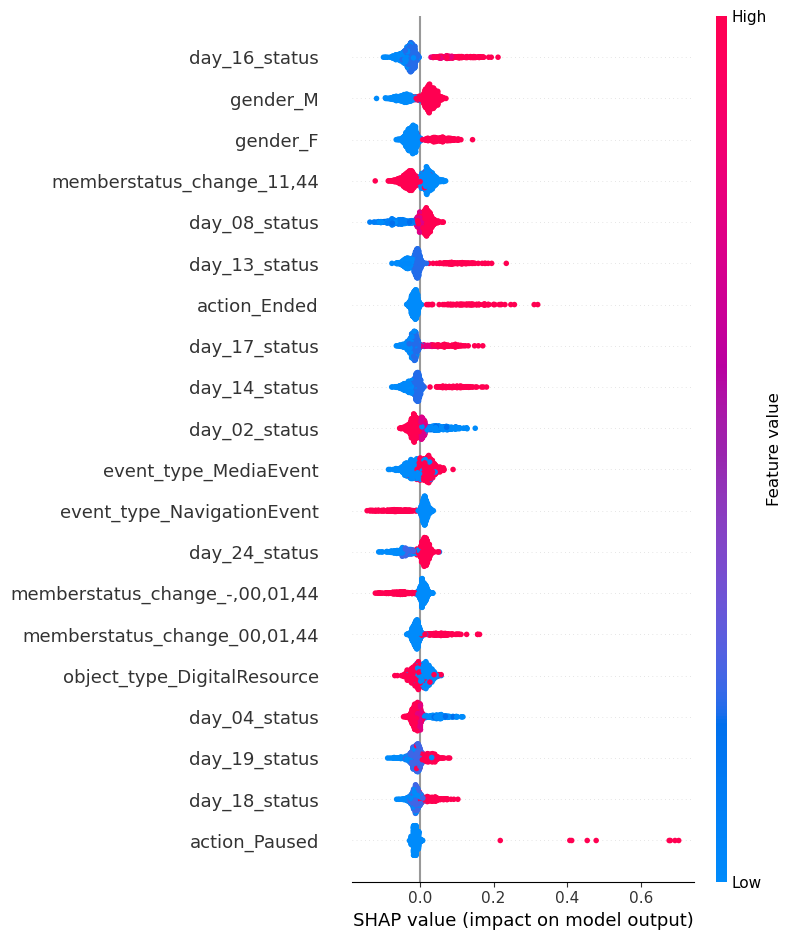

In [3]:
import shap

# SHAP을 사용한 특성 중요도 시각화
shap.initjs()
explainer = shap.Explainer(model.predict, X_sub)
shap_values = explainer(X_val)
shap.summary_plot(shap_values, X_val, feature_names=X.columns.tolist())